## Import library

In [1]:
import sys
sys.path.insert(
    1,
    '/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/lib'
)

import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import math
import timeit
import utils
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import KFold

import dowhy.datasets
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt

from econml.drlearner import ForestDRLearner, LinearDRLearner
from econml.metalearners import SLearner, XLearner, TLearner
from econml.ortho_forest import CausalTree, ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.dml import ForestDMLCateEstimator, LinearDMLCateEstimator, SparseLinearDMLCateEstimator
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

### Import sklearn
from scipy.stats import sem
import scipy.stats as st
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LassoCV, ElasticNetCV
from cforest.forest import CausalForest


/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data

In [2]:
figure_path = "/home/dtd/Documents/PhD_Life/Source Code/my_work/figure"

In [3]:
file_path = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_path)

In [4]:
train_data.price.value_counts()

1.0    4346
0.8    3089
0.9    2565
Name: price, dtype: int64

In [5]:
train_data['treatment'] = np.where(train_data['price'] == 1, 1, 0)
train_data['price'] = np.where(train_data['price'] == 1, 1, 0.85)

In [6]:
train_data.price.value_counts()

0.85    5654
1.00    4346
Name: price, dtype: int64

In [7]:
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand,treatment
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.00,3.917117,1
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.00,11.585706,1
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.00,24.675960,1
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.00,6.361776,1
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.85,12.624123,0


## Features engineering

In [8]:
outcome = "demand"
treatment = "treatment"
col = list(train_data.columns)
col.remove("price")
print(col)

cov = col[:]
cov.remove(treatment)
cov.remove(outcome)
cov.remove('income')
print(cov)

features = col[:]
features.remove(outcome)

print(features)

['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'demand', 'treatment']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'treatment']


In [9]:
train_data.treatment.value_counts()

0    5654
1    4346
Name: treatment, dtype: int64

In [10]:
# Get test data
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
X_test_data = pd.DataFrame(X_test, columns=["income"])

## Synthesis function

In [11]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

In [12]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

In [13]:
print("Estimation true effect {}".format(np.mean(truth_te_estimate)))
print("Upper bound true effect {}".format(np.mean(truth_te_upper)))
print("Lower bound true effect {}".format(np.mean(truth_te_lower)))

Estimation true effect -0.45414588660812233
Upper bound true effect -0.2798161042380279
Lower bound true effect -0.7656288461652991


In [14]:
te_array = train_data["price"] * gamma_fn(train_data) / (train_data["demand"])
true_effect = np.mean(te_array)

## Estimation effect with incremental propensity score

In [15]:
features

['account_age',
 'age',
 'avg_hours',
 'days_visited',
 'friends_count',
 'has_membership',
 'is_US',
 'songs_purchased',
 'income',
 'treatment']

In [16]:
x = cov.copy()
x.append(treatment)
x

['account_age',
 'age',
 'avg_hours',
 'days_visited',
 'friends_count',
 'has_membership',
 'is_US',
 'songs_purchased',
 'treatment']

In [17]:
## Fit treatment
model_t = LogisticRegression()
model_t.fit(train_data[cov], train_data[treatment])

train_data['p1'] = model_t.predict_proba(train_data[cov])[:,1]
train_data['p0'] = 1 - train_data['p1']

train_data["prediction"] = np.where(train_data["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train_data["prediction"], train_data["treatment"])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(train_data[features], train_data[outcome])

Accuracy score of train data 0.5654


GradientBoostingRegressor(n_estimators=5000, random_state=0)

In [18]:
delta = -0.015843108
influence = ipse.influence_function(train_data, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

print("Estimation effect {:.2f}".format(means_incre))
print("MAE {:.2f}".format(utils.abs_ate(true_effect, means_incre)))

Estimation effect -0.94
MAE 0.01


### Estimation effect in train-test

In [19]:
train, test = train_test_split(train_data, test_size=0.1, random_state = 1)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
## Fit treatment
model_t = LogisticRegression()
model_t.fit(train[cov], train[treatment])

train['p1'] = model_t.predict_proba(train[cov])[:,1]
train['p0'] = 1 - train['p1']

train["prediction"] = np.where(train["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train["prediction"], train["treatment"])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(train[features], train[outcome])


Accuracy score of train data 0.5644444444444444


GradientBoostingRegressor(n_estimators=5000, random_state=0)

In [20]:
delta = 2.0

te_array = test["price"] * gamma_fn(test) / (test["demand"])
true_effect_test = np.mean(te_array)

te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect_train = np.mean(te_array)

influence = ipse.influence_function(train, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_train, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

influence = ipse.influence_function(test, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_test, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

origin_mae_train = utils.abs_ate(true_effect_train, means_incre_train)
origin_mae_test = utils.abs_ate(true_effect_test, means_incre_test)


## Optimization with single delta

In [21]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence), influence

def optimization(train, test, true_effect):
    threhold = tf.constant([0.005])
    delta = tf.Variable(np.random.randint(low=1, high=100, size=1), 
                        trainable = True, 
                        dtype = tf.float32)
    delta_seq = []
    losses = []
    losses_test = []
    effects_train = []
    effects_test = []
    influences_train = []
    influences_test = []
    for i in tqdm(range(10000)):
        with tf.GradientTape() as tape:
            mu_influence_train, influence_train = incre_ps(delta, train)
            mu_influence_test, influence_test = incre_ps(delta, test)
            loss = tf.math.abs(true_effect - mu_influence_train)
            loss_test = tf.math.abs(true_effect - mu_influence_test)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.01)
            opt.apply_gradients(zip([d_delta], [delta]))
            ## early stopping 
            if tf.math.less(loss, threhold):
                print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
                break
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            losses_test.append(loss_test.numpy())
            effects_train.append(mu_influence_train.numpy())
            effects_test.append(mu_influence_test.numpy())
            influences_train.append(influence_train.numpy())
            influences_test.append(influence_test.numpy())
        if i % 1000 == 0:
            print("Epoch {}. Loss {:.4f}".format(i, loss))
    print("Loss {:.3f}".format(loss))
    return delta, delta_seq, losses, losses_test, influences_train, influences_test

In [22]:
te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect = np.mean(te_array)
delta, delta_seq, losses, losses_test, influences_train, influences_test = optimization(train, test, true_effect)

  0%|          | 21/10000 [00:00<02:43, 61.10it/s]

Epoch 0. Loss 1.0423


 10%|▉         | 997/10000 [00:06<01:01, 147.01it/s]

The performance reach MAE: 0.001. Cancelling the training at step 997
Loss 0.005


In [23]:
losses[-1]

0.013707101

In [24]:
te_array = test["price"] * gamma_fn(test) / (test["demand"])
true_effect_test = np.mean(te_array)

te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect_train = np.mean(te_array)

mean_train = np.mean(influences_train[-1])
mean_test = np.mean(influences_test[-1])

optimal_mae_train = utils.abs_ate(true_effect_train, mean_train)
optimal_mae_test = utils.abs_ate(true_effect_test, mean_test)

## Conclusion

In [25]:
print("Before Optimization")
print("MAE on training {} and testing {}".format(origin_mae_train, origin_mae_test))
print("After Optimization")
print("MAE on training {} and testing {}".format(optimal_mae_train, optimal_mae_test))


Before Optimization
MAE on training 0.7068891358439671 and testing 0.739408703015396
After Optimization
MAE on training 0.013707237313926202 and testing 0.06484974786014441


## Confidence interval

In [26]:
lowers_train, uppers_train = [], []
lowers_test, uppers_test = [], []
means_train, means_test = [], []

for i in tqdm(range(len(delta_seq))):

    mean_train, mean_test = np.mean(influences_train[i]), np.mean(influences_test[i])
    stds_incre_train, stds_incre_test = sem(influences_train[i], axis=0), sem(influences_test[i], axis=0)

    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influences_train[i])-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)
    lower_test, upper_test = st.t.interval(0.90, 
                                             len(influences_test[i])-1, 
                                             loc=mean_test, 
                                             scale=stds_incre_test)
    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    lowers_test.append(lower_test)
    uppers_test.append(upper_test)
    means_train.append(mean_train)
    means_test.append(mean_test)

100%|██████████| 997/997 [00:00<00:00, 1384.98it/s]


In [27]:
len(uppers_train), len(lowers_train), len(delta_seq), len(means_train)

In [28]:
lowers_train = np.array(lowers_train)
uppers_train = np.array(uppers_train)
delta_seq = np.array(delta_seq)

In [29]:
lowers_train[0], uppers_train[0]

In [30]:
delta_seq = delta_seq.reshape(-1)

In [31]:
delta_seq[-1]

0.030971996

In [32]:
lowers_train.shape, uppers_train.shape, delta_seq.shape

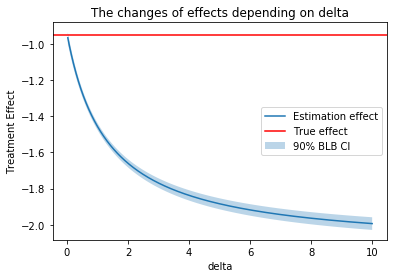

In [33]:
fig = plt.figure()
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.axhline(y=true_effect_train, color='r', linestyle='-', label = "True effect")
plt.fill_between(delta_seq, lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(figure_path + '/demand_train.png')


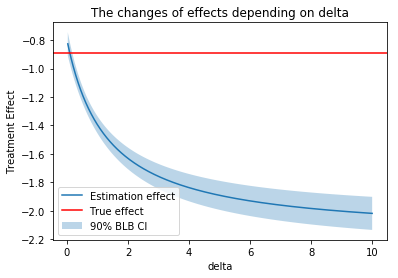

In [34]:
fig = plt.figure()
plt.plot(delta_seq, means_test, label='Estimation effect')
plt.axhline(y=true_effect_test, color='r', linestyle='-', label = "True effect")
plt.fill_between(delta_seq, lowers_test, uppers_test, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(figure_path + '/demand_test.png')


In [35]:
-----

SyntaxError: invalid syntax (<ipython-input-35-0855cc4c4ee0>, line 1)

## K-Fold

In [ ]:
# cv = KFold(n_splits=5, random_state=42, shuffle=False)
# mae_seq_train = []
# mae_seq_test = []

# for train_index, test_index in tqdm(cv.split(train_data)):
#     df_train, df_test = train_data.loc[train_index, :], train_data.loc[test_index, :]

#     model_t = LogisticRegression()
#     model_t.fit(train[cov], train[treatment])

#     train['p1'] = model_t.predict_proba(train[cov])[:,1]
#     train['p0'] = 1 - train['p1']

#     train["prediction"] = np.where(train["p1"] >= 0.5, 1, 0)
#     acc = accuracy_score(train["prediction"], train["treatment"])

#     ## Fit outcome
#     model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
#     model_y.fit(train[features], train[outcome])

#     delta = 0.025128545

#     te_array = test["price"] * gamma_fn(test) / (test["demand"])
#     true_effect_test = np.mean(te_array)

#     te_array = train["price"] * gamma_fn(train) / (train["demand"])
#     true_effect_train = np.mean(te_array)

#     influence = ipse.influence_function(train, treatment, cov, outcome, features, delta, model_y, model_t)
#     means_incre_train, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

#     influence = ipse.influence_function(test, treatment, cov, outcome, features, delta, model_y, model_t)
#     means_incre_test, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

#     origin_mae_train = utils.abs_ate(true_effect_train, means_incre_train)
#     origin_mae_test = utils.abs_ate(true_effect_test, means_incre_test)
    
#     mae_seq_train.append(origin_mae_train)
#     mae_seq_test.append(origin_mae_test)


In [ ]:
# means_train, stds_train = np.mean(mae_seq_train, axis=0), sem(mae_seq_train, axis=0)
# means_test, stds_test = np.mean(mae_seq_test, axis=0), sem(mae_seq_test, axis=0)

# print("Training {} +- {}".format(means_train, stds_train))
# print("Testing {} +- {}".format(means_test, stds_test))

## Optimization individual treatment effects

In [ ]:
# def incre_ps(delta, data):
#     q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
#     q1 = tf.math.abs(q1)
#     a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
#     a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
#     influence = a1 - a0
#     return influence

# def optimization(data):
#     threhold = tf.constant([0.01])
#     '''
#     delta = tf.Variable(
#         tf.random.uniform([data.shape[0],], 
#                           minval=1, 
#                           maxval=100, 
#                           dtype=tf.dtypes.float32), 
#                           trainable = True)
#     '''
#     delta = tf.Variable(tf.random.normal(
#         [data.shape[0],], 
#         mean=10, 
#         stddev=10, 
#         dtype=tf.dtypes.float32, 
#         seed=1, 
#         name='delta'
#     ), trainable = True)
    
#     true_effect = data['mu1'] - data['mu0']
    
#     for i in range(50000):
#         with tf.GradientTape() as tape:
#             influence = incre_ps(delta, data)
#             loss = tf.keras.losses.MSE(true_effect, influence)
#             d_delta = tape.gradient(loss, delta)
#             opt = tf.keras.optimizers.Adam(learning_rate=1)
#             opt.apply_gradients(zip([d_delta], [delta]))
#             print(loss)
#             if tf.math.less(loss, threhold):
#                 print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
#                 break
#     return delta, loss

In [ ]:
# te_array = train["price"] * gamma_fn(train) / (train["demand"])
# true_effect = np.mean(te_array)

# delta, loss = optimization(train, true_effect)

## Optimization with delta list 

In [ ]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence)

def optimization(data):
    threhold = tf.constant([0.001])
    delta = tf.Variable(
        tf.random.uniform([data.shape[0],], 
                          minval=0, 
                          maxval=3, 
                          dtype=tf.dtypes.float32), 
                          trainable = True)
    
    for i in range(50000):
        with tf.GradientTape() as tape:
            influence = incre_ps(delta, data)
            loss = tf.math.abs(true_effect - influence)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            opt.apply_gradients(zip([d_delta], [delta]))
        if i % 1000 == 0:
            print("Epoch: {}. Loss: {:.4f}".format(i, loss))
        if tf.math.less(loss, threhold):
            print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
            break
            
        """
        policy = np.where(data['q1'] >= 0.5, 1, 0)
        rev1 = np.mean(revenue_fn(data = data, 
                          discount_level1 = 0, 
                          discount_level2 = 0.1, 
                          baseline_T = 1,
                          policy = policy))
        print("Revenue {:.2f}".format(rev1))
        """
    return delta


In [ ]:
delta = optimization(train_data)

In [ ]:
delta.shape

In [ ]:
delta = delta.numpy()

In [ ]:
train['p1'] = model_t.predict_proba(train[cov])[:,1]
test['p1'] = model_t.predict_proba(test[cov])[:,1]

te_array = test["price"] * gamma_fn(test) / (test["demand"])
true_effect = np.mean(te_array)

treated_neighbors = (
        NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
        .fit(train['p1'].values.reshape(-1, 1))
)
distances, indices = treated_neighbors.kneighbors(test['p1'].values.reshape(-1, 1))
delta_r = delta[indices.reshape(-1)]
influence = ipse.influence_function(test, treatment, cov, outcome, features, delta_r, model_y, model_t)
means_incre, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)
mae_incre = utils.abs_ate(true_effect, means_incre)
mae_incre

In [ ]:
delta_re = delta.numpy()
influence = ipse.influence_function(train_data, treatment, cov, outcome, features, delta_re, model_y, model_t)
means_incre, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

print("Estimation effect {:.2f}".format(means_incre))
print("MAE {:.2f}".format(utils.abs_ate(true_effect, means_incre)))

## Optimization profit


In [36]:
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = df[df["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = df[df["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)
    
def revenue_fn(data, discount_level1, discount_level2, baseline_T, policy):
    policy_price = baseline_T * (1 - discount_level1) * policy + baseline_T * (1 - discount_level2) * (1 - policy)
    demand = demand_fn(data, policy_price)
    rev = demand * policy_price
    return rev

In [42]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = abs(q1)
    q1 = np.where(q1 >= 0.5, 1, 0)
    #a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    #a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    #influence = a1 - a0
    return q1

def fitness_function(policy, true_effect, data, discount_level1, discount_level2, baseline_T):
    return np.mean(revenue_fn(data, discount_level1, discount_level2, baseline_T, policy))

def select_mating_pool(number_parents, population, fitnesses):
    """
    Select number of individual with the highest fitness
    """
    
    
    indices = (-fitnesses).argsort()[:number_parents]
    parents = population[indices, :]
    return parents

def cross_over(parents, number_of_offspring, crossover_point):
    new_population = []
    
    for i in parents:
        new_population.append(i)
    
    offspring = np.zeros((number_of_offspring, 10000))
    for i in range(number_of_offspring):
        parent1_idx = i % parents.shape[0]
        parent2_idx = (i+1)% parents.shape[0]
        offspring[i, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[i, crossover_point:] = parents[parent2_idx, crossover_point:]
        new_population.append(offspring[i])
    new_population = np.array(new_population)
    return new_population

def mutation(new_population, mutation = 1):
    mutations_counter = 4
    for idx in range(new_population.shape[0]):
        gene_idx = mutations_counter - 1
        for mutation_num in range(mutation):
            random_value = np.random.uniform(-1.0, 1.0, 1)
            #new_population[idx, gene_idx] = new_population[idx, gene_idx] + random_value
            new_population[idx, gene_idx].append(new_population[idx, gene_idx] + random_value)
            gene_idx = gene_idx + mutations_counter
    return new_population


In [43]:
## Fit treatment
model_t = LogisticRegression()
model_t.fit(train_data[cov], train_data[treatment])

train_data['p1'] = model_t.predict_proba(train_data[cov])[:,1]
train_data['p0'] = 1 - train_data['p1']

train_data["prediction"] = np.where(train_data["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train_data["prediction"], train_data["treatment"])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(train_data[features], train_data[outcome])

In [48]:
### fully programming
initial_delta = np.concatenate((np.random.normal(50, 100, (3000,train_data.shape[0])),
                                np.random.normal(0, 0.9, (5000,train_data.shape[0]))))
number_of_generation = 4000
for i in tqdm(range(number_of_generation)):
    individuals = []
    fitnesses = []
    mae = []
    for delta in initial_delta:
        policy = incre_ps(delta, train_data)
        fitness = fitness_function(policy, true_effect, train_data, 0, 0.1, 1)
        fitnesses.append(fitness)
    
    print("Delta {}".format(initial_delta[np.argmin(fitnesses, axis=0)]))
    print("Generation {}. MAE {:.4f}".format(i, max(fitnesses)))
    fitnesses = np.array(fitnesses)
    selected_individuals = select_mating_pool(1500, initial_delta, fitnesses)
    number_of_offspring = initial_delta.shape[0] - len(selected_individuals)
    crossed_individuals = cross_over(selected_individuals, number_of_offspring, 5)
    initial_delta = mutation(crossed_individuals, 600)  
    print("\n")

  0%|          | 0/4000 [00:00<?, ?it/s]

Delta [-1.95114314 -0.55351434  0.83523743 ...  0.57061238  0.25765644
  1.03276243]
Generation 0. MAE 14.2949


  0%|          | 1/4000 [00:09<10:29:46,  9.45s/it]



Delta [-1.39146531  0.29377303  0.12273037 ...  0.13195425 -0.40771309
  0.0078042 ]
Generation 1. MAE 14.2950


  0%|          | 2/4000 [00:18<10:26:40,  9.40s/it]



Delta [123.99829897 -29.13799899  83.46856444 ...  16.5182683  142.67221466
  57.27227045]
Generation 2. MAE 14.2952


  0%|          | 3/4000 [00:27<10:21:28,  9.33s/it]



Delta [153.33564661 174.89370645  -5.32875346 ... 129.137599    81.88516225
 -40.7326776 ]
Generation 3. MAE 14.2955


  0%|          | 4/4000 [00:36<10:16:19,  9.25s/it]



Delta [261.18431736 255.19567433 168.31002219 ... 268.27417858  69.88668192
 -94.75735317]
Generation 4. MAE 14.2953


  0%|          | 5/4000 [00:46<10:12:07,  9.19s/it]



Delta [ 104.78746771  146.81354979 -129.16833201 ...  -49.59919087  -29.84460381
   12.58782437]
Generation 5. MAE 14.2953


  0%|          | 6/4000 [00:54<10:07:12,  9.12s/it]



Delta [179.58771924  92.85780883   1.74141077 ... -29.02648571 113.88919485
  68.07794577]
Generation 6. MAE 14.2955


  0%|          | 7/4000 [01:04<10:06:34,  9.11s/it]



Delta [  51.7384366  -136.0712498   227.65167575 ...  109.93944798   32.9261119
  146.8556739 ]
Generation 7. MAE 14.2955


  0%|          | 8/4000 [01:13<10:03:16,  9.07s/it]



Delta [ -25.41538301 -175.01582329  143.33261636 ...  -18.11505056   68.44092096
   74.50880946]
Generation 8. MAE 14.2955


  0%|          | 9/4000 [01:22<10:02:22,  9.06s/it]



Delta [ 43.12939756 -53.19425506  66.09614159 ...  12.09033949  45.79059352
 -66.75473343]
Generation 9. MAE 14.2956


  0%|          | 10/4000 [01:30<9:57:31,  8.99s/it]



Delta [ 80.24002171 -42.88567024  87.51913285 ...  23.26270305  70.57281465
 -38.51866272]
Generation 10. MAE 14.2955


  0%|          | 11/4000 [01:39<9:59:23,  9.02s/it]



Delta [ 76.42666882  78.12676947 192.28656349 ...  23.26270305  70.57281465
 -38.51866272]
Generation 11. MAE 14.2957


  0%|          | 12/4000 [01:49<10:01:54,  9.06s/it]



Delta [206.36615179  16.78331565  49.38772701 ...  23.26270305  70.57281465
 -38.51866272]
Generation 12. MAE 14.2957


  0%|          | 13/4000 [01:58<10:06:29,  9.13s/it]



Delta [ 123.43590247 -101.61969259   -6.8971557  ...  146.37514927   14.44052912
   36.80676692]
Generation 13. MAE 14.2959


  0%|          | 14/4000 [02:07<10:08:21,  9.16s/it]



Delta [-39.13036213  27.89987194  14.73632095 ... 146.37514927  14.44052912
  36.80676692]
Generation 14. MAE 14.2958


  0%|          | 15/4000 [02:16<10:09:45,  9.18s/it]



Delta [148.06803263 -56.69510856 111.27201899 ... 146.37514927  14.44052912
  36.80676692]
Generation 15. MAE 14.2958


  0%|          | 16/4000 [02:26<10:09:55,  9.19s/it]



Delta [ 123.43590247 -101.61969259   -6.8971557  ...  146.37514927   14.44052912
   36.80676692]
Generation 16. MAE 14.2957


  0%|          | 17/4000 [02:35<10:05:57,  9.13s/it]



Delta [-39.13036213  27.89987194  14.73632095 ... 146.37514927  14.44052912
  36.80676692]
Generation 17. MAE 14.2958


  0%|          | 18/4000 [02:43<9:58:32,  9.02s/it] 



Delta [ 123.43590247 -101.61969259   -6.8971557  ...  146.37514927   14.44052912
   36.80676692]
Generation 18. MAE 14.2958


  0%|          | 19/4000 [02:52<9:59:37,  9.04s/it]



Delta [  6.87469673  22.16422266 150.9294851  ... 146.37514927  14.44052912
  36.80676692]
Generation 19. MAE 14.2958


  0%|          | 20/4000 [03:01<9:53:31,  8.95s/it]



Delta [ 123.43590247 -101.61969259   -6.8971557  ...  146.37514927   14.44052912
   36.80676692]
Generation 20. MAE 14.2959


  1%|          | 21/4000 [03:10<9:51:50,  8.92s/it]



Delta [206.36615179  16.78331565  49.38772701 ... 146.37514927  14.44052912
  36.80676692]
Generation 21. MAE 14.2959


  1%|          | 22/4000 [03:20<10:05:21,  9.13s/it]



Delta [ 71.47816984  88.25181134  94.19500356 ... 146.37514927  14.44052912
  36.80676692]
Generation 22. MAE 14.2959


  1%|          | 23/4000 [03:29<10:06:50,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 23. MAE 14.2959


  1%|          | 24/4000 [03:38<10:07:39,  9.17s/it]



Delta [ 123.43590247 -101.61969259   -6.8971557  ...  146.37514927   14.44052912
   36.80676692]
Generation 24. MAE 14.2959


  1%|          | 25/4000 [03:47<10:05:48,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 25. MAE 14.2959


  1%|          | 26/4000 [03:56<10:05:19,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 26. MAE 14.2959


  1%|          | 27/4000 [04:05<9:57:16,  9.02s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 27. MAE 14.2959


  1%|          | 28/4000 [04:14<9:50:16,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 28. MAE 14.2959


  1%|          | 29/4000 [04:23<9:49:56,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 29. MAE 14.2959


  1%|          | 30/4000 [04:31<9:44:43,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 30. MAE 14.2959


  1%|          | 31/4000 [04:40<9:43:20,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 31. MAE 14.2960


  1%|          | 32/4000 [04:49<9:45:51,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 32. MAE 14.2960


  1%|          | 33/4000 [04:58<9:49:29,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 33. MAE 14.2960


  1%|          | 34/4000 [05:07<9:47:41,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 34. MAE 14.2959


  1%|          | 35/4000 [05:16<10:01:13,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 35. MAE 14.2959


  1%|          | 36/4000 [05:25<9:59:11,  9.07s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 36. MAE 14.2960


  1%|          | 37/4000 [05:34<9:56:38,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 37. MAE 14.2960


  1%|          | 38/4000 [05:44<9:59:21,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 38. MAE 14.2960


  1%|          | 39/4000 [05:53<9:58:09,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 39. MAE 14.2959


  1%|          | 40/4000 [06:01<9:51:52,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 40. MAE 14.2960


  1%|          | 41/4000 [06:10<9:46:08,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 41. MAE 14.2960


  1%|          | 42/4000 [06:19<9:48:46,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 42. MAE 14.2960


  1%|          | 43/4000 [06:29<10:00:32,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 43. MAE 14.2960


  1%|          | 44/4000 [06:38<10:07:35,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 44. MAE 14.2960


  1%|          | 45/4000 [06:48<10:13:57,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 45. MAE 14.2960


  1%|          | 46/4000 [06:57<10:12:52,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 46. MAE 14.2960


  1%|          | 47/4000 [07:06<10:01:56,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 47. MAE 14.2961


  1%|          | 48/4000 [07:14<9:54:52,  9.03s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 48. MAE 14.2961


  1%|          | 49/4000 [07:23<9:52:44,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 49. MAE 14.2961


  1%|▏         | 50/4000 [07:33<9:58:29,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 50. MAE 14.2960


  1%|▏         | 51/4000 [07:42<10:02:39,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 51. MAE 14.2961


  1%|▏         | 52/4000 [07:51<9:56:13,  9.06s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 52. MAE 14.2961


  1%|▏         | 53/4000 [08:00<9:59:35,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 53. MAE 14.2961


  1%|▏         | 54/4000 [08:09<10:02:59,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 54. MAE 14.2962


  1%|▏         | 55/4000 [08:18<10:00:04,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 55. MAE 14.2962


  1%|▏         | 56/4000 [08:27<9:55:13,  9.06s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 56. MAE 14.2962


  1%|▏         | 57/4000 [08:36<9:58:19,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 57. MAE 14.2961


  1%|▏         | 58/4000 [08:46<10:00:39,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 58. MAE 14.2961


  1%|▏         | 59/4000 [08:55<9:59:04,  9.12s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 59. MAE 14.2962


  2%|▏         | 60/4000 [09:04<9:58:39,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 60. MAE 14.2961


  2%|▏         | 61/4000 [09:13<9:58:59,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 61. MAE 14.2961


  2%|▏         | 62/4000 [09:22<9:59:07,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 62. MAE 14.2961


  2%|▏         | 63/4000 [09:31<9:51:53,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 63. MAE 14.2962


  2%|▏         | 64/4000 [09:40<9:49:19,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 64. MAE 14.2962


  2%|▏         | 65/4000 [09:49<9:48:53,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 65. MAE 14.2961


  2%|▏         | 66/4000 [09:58<9:52:12,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 66. MAE 14.2962


  2%|▏         | 67/4000 [10:07<9:57:58,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 67. MAE 14.2963


  2%|▏         | 68/4000 [10:16<9:50:15,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 68. MAE 14.2963


  2%|▏         | 69/4000 [10:25<9:46:37,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 69. MAE 14.2962


  2%|▏         | 70/4000 [10:34<9:45:25,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 70. MAE 14.2962


  2%|▏         | 71/4000 [10:43<9:47:04,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 71. MAE 14.2962


  2%|▏         | 72/4000 [10:52<9:49:21,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 72. MAE 14.2962


  2%|▏         | 73/4000 [11:00<9:41:47,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 73. MAE 14.2962


  2%|▏         | 74/4000 [11:09<9:38:15,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 74. MAE 14.2962


  2%|▏         | 75/4000 [11:18<9:40:15,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 75. MAE 14.2962


  2%|▏         | 76/4000 [11:27<9:46:26,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 76. MAE 14.2963


  2%|▏         | 77/4000 [11:37<9:52:44,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 77. MAE 14.2963


  2%|▏         | 78/4000 [11:46<9:50:08,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 78. MAE 14.2962


  2%|▏         | 79/4000 [11:55<9:59:55,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 79. MAE 14.2963


  2%|▏         | 80/4000 [12:04<9:55:26,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 80. MAE 14.2963


  2%|▏         | 81/4000 [12:13<9:47:54,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 81. MAE 14.2962


  2%|▏         | 82/4000 [12:22<9:46:22,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 82. MAE 14.2963


  2%|▏         | 83/4000 [12:31<9:53:33,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 83. MAE 14.2963


  2%|▏         | 84/4000 [12:41<9:59:44,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 84. MAE 14.2963


  2%|▏         | 85/4000 [12:50<10:03:49,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 85. MAE 14.2963


  2%|▏         | 86/4000 [12:59<10:05:32,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 86. MAE 14.2962


  2%|▏         | 87/4000 [13:09<10:07:43,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 87. MAE 14.2965


  2%|▏         | 88/4000 [13:18<10:06:05,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 88. MAE 14.2964


  2%|▏         | 89/4000 [13:27<10:05:33,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 89. MAE 14.2964


  2%|▏         | 90/4000 [13:37<10:18:06,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 90. MAE 14.2964


  2%|▏         | 91/4000 [13:47<10:24:56,  9.59s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 91. MAE 14.2965


  2%|▏         | 92/4000 [13:56<10:15:46,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 92. MAE 14.2963


  2%|▏         | 93/4000 [14:05<10:02:05,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 93. MAE 14.2963


  2%|▏         | 94/4000 [14:14<9:51:43,  9.09s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 94. MAE 14.2963


  2%|▏         | 95/4000 [14:23<9:48:19,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 95. MAE 14.2964


  2%|▏         | 96/4000 [14:32<9:52:54,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 96. MAE 14.2963


  2%|▏         | 97/4000 [14:41<9:49:37,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 97. MAE 14.2963


  2%|▏         | 98/4000 [14:50<9:46:32,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 98. MAE 14.2964


  2%|▏         | 99/4000 [14:59<9:51:57,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 99. MAE 14.2964


  2%|▎         | 100/4000 [15:08<9:54:24,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 100. MAE 14.2965


  3%|▎         | 101/4000 [15:18<9:58:48,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 101. MAE 14.2964


  3%|▎         | 102/4000 [15:27<10:06:59,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 102. MAE 14.2964


  3%|▎         | 103/4000 [15:37<10:17:31,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 103. MAE 14.2963


  3%|▎         | 104/4000 [15:47<10:25:35,  9.63s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 104. MAE 14.2965


  3%|▎         | 105/4000 [15:56<10:20:48,  9.56s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 105. MAE 14.2965


  3%|▎         | 106/4000 [16:06<10:23:59,  9.61s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 106. MAE 14.2964


  3%|▎         | 107/4000 [16:16<10:20:34,  9.56s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 107. MAE 14.2964


  3%|▎         | 108/4000 [16:25<10:19:05,  9.54s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 108. MAE 14.2965


  3%|▎         | 109/4000 [16:34<10:15:02,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 109. MAE 14.2964


  3%|▎         | 110/4000 [16:44<10:11:33,  9.43s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 110. MAE 14.2964


  3%|▎         | 111/4000 [16:53<10:14:08,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 111. MAE 14.2964


  3%|▎         | 112/4000 [17:03<10:13:44,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 112. MAE 14.2964


  3%|▎         | 113/4000 [17:12<10:08:09,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 113. MAE 14.2964


  3%|▎         | 114/4000 [17:21<10:05:47,  9.35s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 114. MAE 14.2964


  3%|▎         | 115/4000 [17:30<9:55:15,  9.19s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 115. MAE 14.2966


  3%|▎         | 116/4000 [17:39<9:51:04,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 116. MAE 14.2966


  3%|▎         | 117/4000 [17:48<9:51:00,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 117. MAE 14.2964


  3%|▎         | 118/4000 [17:57<9:52:41,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 118. MAE 14.2965


  3%|▎         | 119/4000 [18:06<9:44:28,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 119. MAE 14.2965


  3%|▎         | 120/4000 [18:15<9:48:08,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 120. MAE 14.2965


  3%|▎         | 121/4000 [18:24<9:41:59,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 121. MAE 14.2967


  3%|▎         | 122/4000 [18:33<9:35:55,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 122. MAE 14.2965


  3%|▎         | 123/4000 [18:42<9:32:46,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 123. MAE 14.2966


  3%|▎         | 124/4000 [18:50<9:29:05,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 124. MAE 14.2964


  3%|▎         | 125/4000 [18:59<9:28:52,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 125. MAE 14.2964


  3%|▎         | 126/4000 [19:08<9:38:26,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 126. MAE 14.2965


  3%|▎         | 127/4000 [19:18<9:43:40,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 127. MAE 14.2966


  3%|▎         | 128/4000 [19:27<9:41:56,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 128. MAE 14.2964


  3%|▎         | 129/4000 [19:36<9:47:44,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 129. MAE 14.2967


  3%|▎         | 130/4000 [19:45<9:43:41,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 130. MAE 14.2965


  3%|▎         | 131/4000 [19:54<9:44:09,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 131. MAE 14.2965


  3%|▎         | 132/4000 [20:03<9:45:26,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 132. MAE 14.2965


  3%|▎         | 133/4000 [20:12<9:47:24,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 133. MAE 14.2966


  3%|▎         | 134/4000 [20:21<9:43:51,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 134. MAE 14.2966


  3%|▎         | 135/4000 [20:30<9:41:41,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 135. MAE 14.2966


  3%|▎         | 136/4000 [20:39<9:44:50,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 136. MAE 14.2967


  3%|▎         | 137/4000 [20:48<9:39:57,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 137. MAE 14.2965


  3%|▎         | 138/4000 [20:57<9:38:32,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 138. MAE 14.2966


  3%|▎         | 139/4000 [21:06<9:44:03,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 139. MAE 14.2965


  4%|▎         | 140/4000 [21:16<9:48:03,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 140. MAE 14.2965


  4%|▎         | 141/4000 [21:25<9:42:55,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 141. MAE 14.2965


  4%|▎         | 142/4000 [21:34<9:46:09,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 142. MAE 14.2965


  4%|▎         | 143/4000 [21:43<9:50:28,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 143. MAE 14.2966


  4%|▎         | 144/4000 [21:52<9:51:00,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 144. MAE 14.2967


  4%|▎         | 145/4000 [22:02<9:49:50,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 145. MAE 14.2966


  4%|▎         | 146/4000 [22:10<9:42:53,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 146. MAE 14.2966


  4%|▎         | 147/4000 [22:19<9:34:17,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 147. MAE 14.2965


  4%|▎         | 148/4000 [22:28<9:36:19,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 148. MAE 14.2966


  4%|▎         | 149/4000 [22:37<9:41:57,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 149. MAE 14.2965


  4%|▍         | 150/4000 [22:46<9:40:43,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 150. MAE 14.2966


  4%|▍         | 151/4000 [22:55<9:36:15,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 151. MAE 14.2966


  4%|▍         | 152/4000 [23:04<9:29:58,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 152. MAE 14.2966


  4%|▍         | 153/4000 [23:13<9:28:03,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 153. MAE 14.2967


  4%|▍         | 154/4000 [23:22<9:30:22,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 154. MAE 14.2965


  4%|▍         | 155/4000 [23:31<9:35:00,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 155. MAE 14.2967


  4%|▍         | 156/4000 [23:40<9:34:49,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 156. MAE 14.2966


  4%|▍         | 157/4000 [23:49<9:30:14,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 157. MAE 14.2966


  4%|▍         | 158/4000 [23:57<9:27:48,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 158. MAE 14.2968


  4%|▍         | 159/4000 [24:06<9:25:54,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 159. MAE 14.2967


  4%|▍         | 160/4000 [24:15<9:33:59,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 160. MAE 14.2966


  4%|▍         | 161/4000 [24:24<9:30:21,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 161. MAE 14.2966


  4%|▍         | 162/4000 [24:33<9:28:19,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 162. MAE 14.2967


  4%|▍         | 163/4000 [24:42<9:27:35,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 163. MAE 14.2967


  4%|▍         | 164/4000 [24:50<9:23:42,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 164. MAE 14.2966


  4%|▍         | 165/4000 [25:00<9:34:49,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 165. MAE 14.2966


  4%|▍         | 166/4000 [25:09<9:42:56,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 166. MAE 14.2966


  4%|▍         | 167/4000 [25:18<9:43:56,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 167. MAE 14.2967


  4%|▍         | 168/4000 [25:27<9:41:03,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 168. MAE 14.2966


  4%|▍         | 169/4000 [25:38<10:01:43,  9.42s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 169. MAE 14.2966


  4%|▍         | 170/4000 [25:47<10:06:48,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 170. MAE 14.2966


  4%|▍         | 171/4000 [25:57<10:11:13,  9.58s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 171. MAE 14.2967


  4%|▍         | 172/4000 [26:07<10:16:11,  9.66s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 172. MAE 14.2967


  4%|▍         | 173/4000 [26:16<10:04:32,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 173. MAE 14.2967


  4%|▍         | 174/4000 [26:26<10:04:34,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 174. MAE 14.2967


  4%|▍         | 175/4000 [26:35<9:56:41,  9.36s/it] 



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 175. MAE 14.2967


  4%|▍         | 176/4000 [26:43<9:46:05,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 176. MAE 14.2966


  4%|▍         | 177/4000 [26:52<9:38:36,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 177. MAE 14.2966


  4%|▍         | 178/4000 [27:01<9:35:45,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 178. MAE 14.2967


  4%|▍         | 179/4000 [27:10<9:30:51,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 179. MAE 14.2966


  4%|▍         | 180/4000 [27:19<9:30:49,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 180. MAE 14.2967


  5%|▍         | 181/4000 [27:28<9:34:13,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 181. MAE 14.2967


  5%|▍         | 182/4000 [27:37<9:38:02,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 182. MAE 14.2967


  5%|▍         | 183/4000 [27:46<9:40:11,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 183. MAE 14.2969


  5%|▍         | 184/4000 [27:56<9:42:58,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 184. MAE 14.2967


  5%|▍         | 185/4000 [28:05<9:43:11,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 185. MAE 14.2967


  5%|▍         | 186/4000 [28:14<9:41:55,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 186. MAE 14.2967


  5%|▍         | 187/4000 [28:23<9:43:57,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 187. MAE 14.2966


  5%|▍         | 188/4000 [28:32<9:37:40,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 188. MAE 14.2967


  5%|▍         | 189/4000 [28:41<9:32:02,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 189. MAE 14.2967


  5%|▍         | 190/4000 [28:50<9:30:35,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 190. MAE 14.2967


  5%|▍         | 191/4000 [28:59<9:27:55,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 191. MAE 14.2967


  5%|▍         | 192/4000 [29:08<9:32:52,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 192. MAE 14.2966


  5%|▍         | 193/4000 [29:17<9:36:42,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 193. MAE 14.2968


  5%|▍         | 194/4000 [29:26<9:38:22,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 194. MAE 14.2966


  5%|▍         | 195/4000 [29:35<9:34:27,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 195. MAE 14.2967


  5%|▍         | 196/4000 [29:44<9:29:33,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 196. MAE 14.2968


  5%|▍         | 197/4000 [29:53<9:34:18,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 197. MAE 14.2966


  5%|▍         | 198/4000 [30:02<9:30:14,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 198. MAE 14.2967


  5%|▍         | 199/4000 [30:11<9:33:33,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 199. MAE 14.2967


  5%|▌         | 200/4000 [30:20<9:29:48,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 200. MAE 14.2967


  5%|▌         | 201/4000 [30:29<9:32:40,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 201. MAE 14.2967


  5%|▌         | 202/4000 [30:38<9:31:26,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 202. MAE 14.2967


  5%|▌         | 203/4000 [30:47<9:28:49,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 203. MAE 14.2968


  5%|▌         | 204/4000 [30:57<9:32:54,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 204. MAE 14.2967


  5%|▌         | 205/4000 [31:06<9:36:08,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 205. MAE 14.2967


  5%|▌         | 206/4000 [31:16<9:50:53,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 206. MAE 14.2968


  5%|▌         | 207/4000 [31:25<9:44:56,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 207. MAE 14.2967


  5%|▌         | 208/4000 [31:34<9:37:45,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 208. MAE 14.2967


  5%|▌         | 209/4000 [31:43<9:36:47,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 209. MAE 14.2967


  5%|▌         | 210/4000 [31:52<9:33:23,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 210. MAE 14.2967


  5%|▌         | 211/4000 [32:00<9:26:55,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 211. MAE 14.2968


  5%|▌         | 212/4000 [32:10<9:30:35,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 212. MAE 14.2967


  5%|▌         | 213/4000 [32:19<9:33:39,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 213. MAE 14.2967


  5%|▌         | 214/4000 [32:28<9:31:57,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 214. MAE 14.2969


  5%|▌         | 215/4000 [32:37<9:30:42,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 215. MAE 14.2967


  5%|▌         | 216/4000 [32:45<9:23:10,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 216. MAE 14.2967


  5%|▌         | 217/4000 [32:54<9:17:54,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 217. MAE 14.2967


  5%|▌         | 218/4000 [33:03<9:20:57,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 218. MAE 14.2967


  5%|▌         | 219/4000 [33:12<9:17:38,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 219. MAE 14.2968


  6%|▌         | 220/4000 [33:21<9:19:27,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 220. MAE 14.2967


  6%|▌         | 221/4000 [33:30<9:16:39,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 221. MAE 14.2967


  6%|▌         | 222/4000 [33:39<9:18:31,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 222. MAE 14.2967


  6%|▌         | 223/4000 [33:48<9:27:19,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 223. MAE 14.2967


  6%|▌         | 224/4000 [33:57<9:30:35,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 224. MAE 14.2967


  6%|▌         | 225/4000 [34:06<9:34:35,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 225. MAE 14.2967


  6%|▌         | 226/4000 [34:15<9:30:35,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 226. MAE 14.2967


  6%|▌         | 227/4000 [34:24<9:24:23,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 227. MAE 14.2967


  6%|▌         | 228/4000 [34:33<9:22:00,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 228. MAE 14.2967


  6%|▌         | 229/4000 [34:42<9:17:48,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 229. MAE 14.2968


  6%|▌         | 230/4000 [34:50<9:14:26,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 230. MAE 14.2968


  6%|▌         | 231/4000 [34:59<9:12:11,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 231. MAE 14.2967


  6%|▌         | 232/4000 [35:08<9:10:57,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 232. MAE 14.2969


  6%|▌         | 233/4000 [35:16<9:09:53,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 233. MAE 14.2967


  6%|▌         | 234/4000 [35:25<9:07:37,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 234. MAE 14.2967


  6%|▌         | 235/4000 [35:34<9:08:28,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 235. MAE 14.2968


  6%|▌         | 236/4000 [35:43<9:07:26,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 236. MAE 14.2967


  6%|▌         | 237/4000 [35:52<9:14:43,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 237. MAE 14.2967


  6%|▌         | 238/4000 [36:01<9:17:43,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 238. MAE 14.2968


  6%|▌         | 239/4000 [36:09<9:14:18,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 239. MAE 14.2967


  6%|▌         | 240/4000 [36:18<9:10:23,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 240. MAE 14.2967


  6%|▌         | 241/4000 [36:27<9:12:36,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 241. MAE 14.2968


  6%|▌         | 242/4000 [36:36<9:11:50,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 242. MAE 14.2968


  6%|▌         | 243/4000 [36:45<9:23:37,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 243. MAE 14.2969


  6%|▌         | 244/4000 [36:54<9:21:09,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 244. MAE 14.2968


  6%|▌         | 245/4000 [37:03<9:15:48,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 245. MAE 14.2967


  6%|▌         | 246/4000 [37:12<9:15:52,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 246. MAE 14.2968


  6%|▌         | 247/4000 [37:21<9:15:35,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 247. MAE 14.2968


  6%|▌         | 248/4000 [37:30<9:17:55,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 248. MAE 14.2967


  6%|▌         | 249/4000 [37:39<9:23:22,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 249. MAE 14.2969


  6%|▋         | 250/4000 [37:48<9:19:09,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 250. MAE 14.2968


  6%|▋         | 251/4000 [37:57<9:19:32,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 251. MAE 14.2969


  6%|▋         | 252/4000 [38:05<9:16:43,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 252. MAE 14.2967


  6%|▋         | 253/4000 [38:14<9:18:52,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 253. MAE 14.2969


  6%|▋         | 254/4000 [38:24<9:21:53,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 254. MAE 14.2968


  6%|▋         | 255/4000 [38:33<9:21:37,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 255. MAE 14.2968


  6%|▋         | 256/4000 [38:42<9:29:43,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 256. MAE 14.2968


  6%|▋         | 257/4000 [38:51<9:31:48,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 257. MAE 14.2968


  6%|▋         | 258/4000 [39:00<9:23:18,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 258. MAE 14.2968


  6%|▋         | 259/4000 [39:09<9:19:52,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 259. MAE 14.2967


  6%|▋         | 260/4000 [39:18<9:23:53,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 260. MAE 14.2967


  7%|▋         | 261/4000 [39:27<9:28:22,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 261. MAE 14.2968


  7%|▋         | 262/4000 [39:36<9:23:45,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 262. MAE 14.2969


  7%|▋         | 263/4000 [39:45<9:21:51,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 263. MAE 14.2968


  7%|▋         | 264/4000 [39:54<9:25:39,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 264. MAE 14.2968


  7%|▋         | 265/4000 [40:04<9:27:53,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 265. MAE 14.2968


  7%|▋         | 266/4000 [40:12<9:23:22,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 266. MAE 14.2968


  7%|▋         | 267/4000 [40:22<9:25:14,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 267. MAE 14.2968


  7%|▋         | 268/4000 [40:30<9:17:27,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 268. MAE 14.2970


  7%|▋         | 269/4000 [40:39<9:18:29,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 269. MAE 14.2970


  7%|▋         | 270/4000 [40:48<9:14:00,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 270. MAE 14.2968


  7%|▋         | 271/4000 [40:57<9:22:41,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 271. MAE 14.2968


  7%|▋         | 272/4000 [41:07<9:31:34,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 272. MAE 14.2969


  7%|▋         | 273/4000 [41:17<9:37:06,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 273. MAE 14.2969


  7%|▋         | 274/4000 [41:26<9:33:51,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 274. MAE 14.2968


  7%|▋         | 275/4000 [41:34<9:24:07,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 275. MAE 14.2970


  7%|▋         | 276/4000 [41:43<9:17:35,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 276. MAE 14.2968


  7%|▋         | 277/4000 [41:52<9:12:33,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 277. MAE 14.2970


  7%|▋         | 278/4000 [42:01<9:08:28,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 278. MAE 14.2969


  7%|▋         | 279/4000 [42:10<9:13:04,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 279. MAE 14.2968


  7%|▋         | 280/4000 [42:19<9:19:36,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 280. MAE 14.2968


  7%|▋         | 281/4000 [42:28<9:23:41,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 281. MAE 14.2969


  7%|▋         | 282/4000 [42:37<9:17:32,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 282. MAE 14.2969


  7%|▋         | 283/4000 [42:46<9:12:06,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 283. MAE 14.2969


  7%|▋         | 284/4000 [42:54<9:09:28,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 284. MAE 14.2970


  7%|▋         | 285/4000 [43:03<9:06:55,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 285. MAE 14.2968


  7%|▋         | 286/4000 [43:12<9:10:30,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 286. MAE 14.2969


  7%|▋         | 287/4000 [43:21<9:07:36,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 287. MAE 14.2970


  7%|▋         | 288/4000 [43:30<9:06:01,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 288. MAE 14.2969


  7%|▋         | 289/4000 [43:38<9:04:14,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 289. MAE 14.2969


  7%|▋         | 290/4000 [43:47<9:07:43,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 290. MAE 14.2969


  7%|▋         | 291/4000 [43:56<9:08:49,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 291. MAE 14.2969


  7%|▋         | 292/4000 [44:05<9:06:31,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 292. MAE 14.2970


  7%|▋         | 293/4000 [44:14<9:04:33,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 293. MAE 14.2969


  7%|▋         | 294/4000 [44:23<9:03:05,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 294. MAE 14.2969


  7%|▋         | 295/4000 [44:32<9:07:12,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 295. MAE 14.2969


  7%|▋         | 296/4000 [44:41<9:14:01,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 296. MAE 14.2969


  7%|▋         | 297/4000 [44:50<9:18:38,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 297. MAE 14.2969


  7%|▋         | 298/4000 [44:59<9:13:46,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 298. MAE 14.2970


  7%|▋         | 299/4000 [45:08<9:18:30,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 299. MAE 14.2971


  8%|▊         | 300/4000 [45:18<9:25:12,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 300. MAE 14.2970


  8%|▊         | 301/4000 [45:27<9:28:41,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 301. MAE 14.2971


  8%|▊         | 302/4000 [45:36<9:30:44,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 302. MAE 14.2971


  8%|▊         | 303/4000 [45:46<9:33:00,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 303. MAE 14.2969


  8%|▊         | 304/4000 [45:55<9:32:00,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 304. MAE 14.2971


  8%|▊         | 305/4000 [46:04<9:35:01,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 305. MAE 14.2971


  8%|▊         | 306/4000 [46:14<9:34:20,  9.33s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 306. MAE 14.2969


  8%|▊         | 307/4000 [46:23<9:31:50,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 307. MAE 14.2969


  8%|▊         | 308/4000 [46:32<9:30:46,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 308. MAE 14.2969


  8%|▊         | 309/4000 [46:41<9:32:27,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 309. MAE 14.2970


  8%|▊         | 310/4000 [46:51<9:28:30,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 310. MAE 14.2970


  8%|▊         | 311/4000 [47:00<9:27:54,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 311. MAE 14.2970


  8%|▊         | 312/4000 [47:09<9:27:41,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 312. MAE 14.2969


  8%|▊         | 313/4000 [47:18<9:25:42,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 313. MAE 14.2970


  8%|▊         | 314/4000 [47:27<9:25:02,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 314. MAE 14.2971


  8%|▊         | 315/4000 [47:36<9:15:22,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 315. MAE 14.2970


  8%|▊         | 316/4000 [47:45<9:09:45,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 316. MAE 14.2970


  8%|▊         | 317/4000 [47:54<9:05:21,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 317. MAE 14.2970


  8%|▊         | 318/4000 [48:02<9:06:30,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 318. MAE 14.2970


  8%|▊         | 319/4000 [48:12<9:13:14,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 319. MAE 14.2969


  8%|▊         | 320/4000 [48:21<9:16:11,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 320. MAE 14.2971


  8%|▊         | 321/4000 [48:30<9:15:40,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 321. MAE 14.2971


  8%|▊         | 322/4000 [48:39<9:17:10,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 322. MAE 14.2972


  8%|▊         | 323/4000 [48:48<9:19:02,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 323. MAE 14.2971


  8%|▊         | 324/4000 [48:57<9:19:00,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 324. MAE 14.2970


  8%|▊         | 325/4000 [49:07<9:22:01,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 325. MAE 14.2971


  8%|▊         | 326/4000 [49:16<9:22:54,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 326. MAE 14.2970


  8%|▊         | 327/4000 [49:25<9:24:19,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 327. MAE 14.2969


  8%|▊         | 328/4000 [49:34<9:23:06,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 328. MAE 14.2970


  8%|▊         | 329/4000 [49:43<9:20:30,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 329. MAE 14.2971


  8%|▊         | 330/4000 [49:53<9:23:35,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 330. MAE 14.2972


  8%|▊         | 331/4000 [50:02<9:20:56,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 331. MAE 14.2971


  8%|▊         | 332/4000 [50:11<9:19:34,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 332. MAE 14.2970


  8%|▊         | 333/4000 [50:20<9:20:26,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 333. MAE 14.2970


  8%|▊         | 334/4000 [50:30<9:30:50,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 334. MAE 14.2970


  8%|▊         | 335/4000 [50:39<9:33:34,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 335. MAE 14.2971


  8%|▊         | 336/4000 [50:49<9:31:22,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 336. MAE 14.2971


  8%|▊         | 337/4000 [50:58<9:24:41,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 337. MAE 14.2969


  8%|▊         | 338/4000 [51:07<9:27:27,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 338. MAE 14.2970


  8%|▊         | 339/4000 [51:17<9:28:21,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 339. MAE 14.2970


  8%|▊         | 340/4000 [51:26<9:27:13,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 340. MAE 14.2969


  9%|▊         | 341/4000 [51:35<9:26:30,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 341. MAE 14.2969


  9%|▊         | 342/4000 [51:44<9:18:39,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 342. MAE 14.2969


  9%|▊         | 343/4000 [51:53<9:25:16,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 343. MAE 14.2971


  9%|▊         | 344/4000 [52:03<9:31:33,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 344. MAE 14.2970


  9%|▊         | 345/4000 [52:12<9:21:29,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 345. MAE 14.2969


  9%|▊         | 346/4000 [52:21<9:22:26,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 346. MAE 14.2969


  9%|▊         | 347/4000 [52:30<9:20:35,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 347. MAE 14.2970


  9%|▊         | 348/4000 [52:40<9:21:18,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 348. MAE 14.2969


  9%|▊         | 349/4000 [52:48<9:14:31,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 349. MAE 14.2969


  9%|▉         | 350/4000 [52:58<9:16:44,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 350. MAE 14.2969


  9%|▉         | 351/4000 [53:07<9:18:45,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 351. MAE 14.2969


  9%|▉         | 352/4000 [53:16<9:18:56,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 352. MAE 14.2970


  9%|▉         | 353/4000 [53:25<9:12:22,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 353. MAE 14.2971


  9%|▉         | 354/4000 [53:34<9:16:27,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 354. MAE 14.2969


  9%|▉         | 355/4000 [53:44<9:20:16,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 355. MAE 14.2969


  9%|▉         | 356/4000 [53:53<9:14:39,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 356. MAE 14.2970


  9%|▉         | 357/4000 [54:02<9:12:44,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 357. MAE 14.2969


  9%|▉         | 358/4000 [54:11<9:15:55,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 358. MAE 14.2969


  9%|▉         | 359/4000 [54:20<9:17:51,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 359. MAE 14.2969


  9%|▉         | 360/4000 [54:29<9:12:24,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 360. MAE 14.2969


  9%|▉         | 361/4000 [54:38<9:14:04,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 361. MAE 14.2971


  9%|▉         | 362/4000 [54:48<9:16:18,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 362. MAE 14.2970


  9%|▉         | 363/4000 [54:57<9:19:29,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 363. MAE 14.2970


  9%|▉         | 364/4000 [55:06<9:10:51,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 364. MAE 14.2970


  9%|▉         | 365/4000 [55:15<9:13:44,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 365. MAE 14.2971


  9%|▉         | 366/4000 [55:24<9:06:03,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 366. MAE 14.2969


  9%|▉         | 367/4000 [55:33<9:08:53,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 367. MAE 14.2970


  9%|▉         | 368/4000 [55:42<9:03:46,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 368. MAE 14.2969


  9%|▉         | 369/4000 [55:51<9:01:22,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 369. MAE 14.2972


  9%|▉         | 370/4000 [55:59<8:56:57,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 370. MAE 14.2970


  9%|▉         | 371/4000 [56:08<9:03:34,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 371. MAE 14.2971


  9%|▉         | 372/4000 [56:17<9:02:43,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 372. MAE 14.2969


  9%|▉         | 373/4000 [56:27<9:15:18,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 373. MAE 14.2970


  9%|▉         | 374/4000 [56:36<9:14:27,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 374. MAE 14.2971


  9%|▉         | 375/4000 [56:45<9:09:11,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 375. MAE 14.2970


  9%|▉         | 376/4000 [56:54<9:02:51,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 376. MAE 14.2969


  9%|▉         | 377/4000 [57:03<8:58:46,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 377. MAE 14.2970


  9%|▉         | 378/4000 [57:12<9:04:58,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 378. MAE 14.2970


  9%|▉         | 379/4000 [57:21<9:07:14,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 379. MAE 14.2970


 10%|▉         | 380/4000 [57:30<9:10:11,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 380. MAE 14.2970


 10%|▉         | 381/4000 [57:40<9:10:53,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 381. MAE 14.2970


 10%|▉         | 382/4000 [57:48<9:07:19,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 382. MAE 14.2971


 10%|▉         | 383/4000 [57:57<9:02:18,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 383. MAE 14.2972


 10%|▉         | 384/4000 [58:06<9:02:34,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 384. MAE 14.2970


 10%|▉         | 385/4000 [58:15<9:01:43,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 385. MAE 14.2970


 10%|▉         | 386/4000 [58:24<8:59:12,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 386. MAE 14.2971


 10%|▉         | 387/4000 [58:33<9:03:30,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 387. MAE 14.2970


 10%|▉         | 388/4000 [58:42<9:04:54,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 388. MAE 14.2970


 10%|▉         | 389/4000 [58:51<9:01:13,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 389. MAE 14.2973


 10%|▉         | 390/4000 [59:01<9:05:36,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 390. MAE 14.2971


 10%|▉         | 391/4000 [59:09<9:00:24,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 391. MAE 14.2969


 10%|▉         | 392/4000 [59:19<9:07:43,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 392. MAE 14.2970


 10%|▉         | 393/4000 [59:28<9:08:26,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 393. MAE 14.2971


 10%|▉         | 394/4000 [59:37<9:11:34,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 394. MAE 14.2970


 10%|▉         | 395/4000 [59:46<9:07:22,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 395. MAE 14.2971


 10%|▉         | 396/4000 [59:55<9:00:29,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 396. MAE 14.2970


 10%|▉         | 397/4000 [1:00:04<8:57:31,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 397. MAE 14.2970


 10%|▉         | 398/4000 [1:00:13<8:59:01,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 398. MAE 14.2971


 10%|▉         | 399/4000 [1:00:22<9:03:58,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 399. MAE 14.2971


 10%|█         | 400/4000 [1:00:31<8:59:02,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 400. MAE 14.2970


 10%|█         | 401/4000 [1:00:40<9:02:22,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 401. MAE 14.2970


 10%|█         | 402/4000 [1:00:49<9:05:36,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 402. MAE 14.2970


 10%|█         | 403/4000 [1:00:58<8:59:41,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 403. MAE 14.2970


 10%|█         | 404/4000 [1:01:07<8:56:18,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 404. MAE 14.2971


 10%|█         | 405/4000 [1:01:16<9:00:58,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 405. MAE 14.2970


 10%|█         | 406/4000 [1:01:25<8:59:15,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 406. MAE 14.2971


 10%|█         | 407/4000 [1:01:34<9:04:11,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 407. MAE 14.2970


 10%|█         | 408/4000 [1:01:44<9:07:04,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 408. MAE 14.2971


 10%|█         | 409/4000 [1:01:52<9:01:48,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 409. MAE 14.2970


 10%|█         | 410/4000 [1:02:01<8:57:00,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 410. MAE 14.2971


 10%|█         | 411/4000 [1:02:10<8:53:07,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 411. MAE 14.2971


 10%|█         | 412/4000 [1:02:19<8:50:42,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 412. MAE 14.2971


 10%|█         | 413/4000 [1:02:27<8:46:57,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 413. MAE 14.2971


 10%|█         | 414/4000 [1:02:37<8:54:21,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 414. MAE 14.2970


 10%|█         | 415/4000 [1:02:46<8:55:09,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 415. MAE 14.2970


 10%|█         | 416/4000 [1:02:55<8:57:28,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 416. MAE 14.2971


 10%|█         | 417/4000 [1:03:04<8:58:24,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 417. MAE 14.2970


 10%|█         | 418/4000 [1:03:13<8:57:44,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 418. MAE 14.2970


 10%|█         | 419/4000 [1:03:22<8:58:00,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 419. MAE 14.2970


 10%|█         | 420/4000 [1:03:31<8:56:39,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 420. MAE 14.2971


 11%|█         | 421/4000 [1:03:40<8:58:48,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 421. MAE 14.2971


 11%|█         | 422/4000 [1:03:49<8:52:03,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 422. MAE 14.2970


 11%|█         | 423/4000 [1:03:57<8:50:59,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 423. MAE 14.2971


 11%|█         | 424/4000 [1:04:06<8:47:43,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 424. MAE 14.2970


 11%|█         | 425/4000 [1:04:15<8:45:56,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 425. MAE 14.2970


 11%|█         | 426/4000 [1:04:24<8:47:35,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 426. MAE 14.2971


 11%|█         | 427/4000 [1:04:33<8:47:26,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 427. MAE 14.2970


 11%|█         | 428/4000 [1:04:42<8:53:25,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 428. MAE 14.2970


 11%|█         | 429/4000 [1:04:51<8:54:48,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 429. MAE 14.2970


 11%|█         | 430/4000 [1:05:00<8:55:48,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 430. MAE 14.2970


 11%|█         | 431/4000 [1:05:09<9:03:54,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 431. MAE 14.2970


 11%|█         | 432/4000 [1:05:18<9:01:13,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 432. MAE 14.2971


 11%|█         | 433/4000 [1:05:27<8:59:08,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 433. MAE 14.2971


 11%|█         | 434/4000 [1:05:37<9:03:33,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 434. MAE 14.2970


 11%|█         | 435/4000 [1:05:45<8:54:55,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 435. MAE 14.2970


 11%|█         | 436/4000 [1:05:54<8:52:07,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 436. MAE 14.2972


 11%|█         | 437/4000 [1:06:03<8:48:43,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 437. MAE 14.2971


 11%|█         | 438/4000 [1:06:12<8:49:28,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 438. MAE 14.2970


 11%|█         | 439/4000 [1:06:21<8:53:19,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 439. MAE 14.2971


 11%|█         | 440/4000 [1:06:30<8:56:17,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 440. MAE 14.2970


 11%|█         | 441/4000 [1:06:39<8:50:58,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 441. MAE 14.2972


 11%|█         | 442/4000 [1:06:48<8:47:31,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 442. MAE 14.2971


 11%|█         | 443/4000 [1:06:57<8:46:04,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 443. MAE 14.2971


 11%|█         | 444/4000 [1:07:06<8:54:47,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 444. MAE 14.2971


 11%|█         | 445/4000 [1:07:15<8:59:43,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 445. MAE 14.2971


 11%|█         | 446/4000 [1:07:25<9:02:20,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 446. MAE 14.2971


 11%|█         | 447/4000 [1:07:34<9:03:12,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 447. MAE 14.2970


 11%|█         | 448/4000 [1:07:43<9:03:04,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 448. MAE 14.2970


 11%|█         | 449/4000 [1:07:52<8:58:40,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 449. MAE 14.2971


 11%|█▏        | 450/4000 [1:08:01<9:00:53,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 450. MAE 14.2972


 11%|█▏        | 451/4000 [1:08:10<8:53:02,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 451. MAE 14.2971


 11%|█▏        | 452/4000 [1:08:19<8:47:43,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 452. MAE 14.2970


 11%|█▏        | 453/4000 [1:08:28<8:52:27,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 453. MAE 14.2971


 11%|█▏        | 454/4000 [1:08:37<8:57:29,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 454. MAE 14.2971


 11%|█▏        | 455/4000 [1:08:46<8:58:09,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 455. MAE 14.2972


 11%|█▏        | 456/4000 [1:08:55<8:52:55,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 456. MAE 14.2970


 11%|█▏        | 457/4000 [1:09:04<8:58:10,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 457. MAE 14.2971


 11%|█▏        | 458/4000 [1:09:13<8:56:25,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 458. MAE 14.2970


 11%|█▏        | 459/4000 [1:09:22<8:54:57,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 459. MAE 14.2970


 12%|█▏        | 460/4000 [1:09:32<8:56:19,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 460. MAE 14.2973


 12%|█▏        | 461/4000 [1:09:40<8:51:09,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 461. MAE 14.2972


 12%|█▏        | 462/4000 [1:09:50<8:57:46,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 462. MAE 14.2970


 12%|█▏        | 463/4000 [1:09:59<9:03:07,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 463. MAE 14.2971


 12%|█▏        | 464/4000 [1:10:08<9:02:34,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 464. MAE 14.2971


 12%|█▏        | 465/4000 [1:10:18<9:03:19,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 465. MAE 14.2970


 12%|█▏        | 466/4000 [1:10:27<8:59:41,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 466. MAE 14.2972


 12%|█▏        | 467/4000 [1:10:36<9:00:57,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 467. MAE 14.2971


 12%|█▏        | 468/4000 [1:10:45<8:58:08,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 468. MAE 14.2972


 12%|█▏        | 469/4000 [1:10:54<9:02:06,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 469. MAE 14.2972


 12%|█▏        | 470/4000 [1:11:03<8:58:41,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 470. MAE 14.2973


 12%|█▏        | 471/4000 [1:11:12<8:51:33,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 471. MAE 14.2971


 12%|█▏        | 472/4000 [1:11:21<8:44:48,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 472. MAE 14.2971


 12%|█▏        | 473/4000 [1:11:30<8:41:22,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 473. MAE 14.2973


 12%|█▏        | 474/4000 [1:11:38<8:39:21,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 474. MAE 14.2971


 12%|█▏        | 475/4000 [1:11:47<8:39:19,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 475. MAE 14.2971


 12%|█▏        | 476/4000 [1:11:56<8:38:42,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 476. MAE 14.2972


 12%|█▏        | 477/4000 [1:12:05<8:39:56,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 477. MAE 14.2972


 12%|█▏        | 478/4000 [1:12:14<8:38:23,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 478. MAE 14.2971


 12%|█▏        | 479/4000 [1:12:22<8:36:22,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 479. MAE 14.2970


 12%|█▏        | 480/4000 [1:12:31<8:36:01,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 480. MAE 14.2971


 12%|█▏        | 481/4000 [1:12:40<8:34:09,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 481. MAE 14.2970


 12%|█▏        | 482/4000 [1:12:49<8:35:04,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 482. MAE 14.2971


 12%|█▏        | 483/4000 [1:12:57<8:34:22,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 483. MAE 14.2971


 12%|█▏        | 484/4000 [1:13:07<8:42:09,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 484. MAE 14.2971


 12%|█▏        | 485/4000 [1:13:16<8:44:58,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 485. MAE 14.2970


 12%|█▏        | 486/4000 [1:13:25<8:46:02,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 486. MAE 14.2971


 12%|█▏        | 487/4000 [1:13:34<8:49:20,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 487. MAE 14.2971


 12%|█▏        | 488/4000 [1:13:43<8:53:25,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 488. MAE 14.2970


 12%|█▏        | 489/4000 [1:13:52<8:47:09,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 489. MAE 14.2970


 12%|█▏        | 490/4000 [1:14:01<8:50:54,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 490. MAE 14.2972


 12%|█▏        | 491/4000 [1:14:10<8:52:30,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 491. MAE 14.2971


 12%|█▏        | 492/4000 [1:14:19<8:49:50,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 492. MAE 14.2971


 12%|█▏        | 493/4000 [1:14:28<8:47:06,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 493. MAE 14.2971


 12%|█▏        | 494/4000 [1:14:37<8:42:30,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 494. MAE 14.2972


 12%|█▏        | 495/4000 [1:14:46<8:38:07,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 495. MAE 14.2970


 12%|█▏        | 496/4000 [1:14:55<8:40:01,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 496. MAE 14.2972


 12%|█▏        | 497/4000 [1:15:03<8:38:02,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 497. MAE 14.2970


 12%|█▏        | 498/4000 [1:15:13<8:44:29,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 498. MAE 14.2971


 12%|█▏        | 499/4000 [1:15:22<8:46:53,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 499. MAE 14.2971


 12%|█▎        | 500/4000 [1:15:31<8:48:17,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 500. MAE 14.2972


 13%|█▎        | 501/4000 [1:15:40<8:45:52,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 501. MAE 14.2971


 13%|█▎        | 502/4000 [1:15:49<8:49:00,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 502. MAE 14.2972


 13%|█▎        | 503/4000 [1:15:58<8:50:16,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 503. MAE 14.2970


 13%|█▎        | 504/4000 [1:16:07<8:44:09,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 504. MAE 14.2972


 13%|█▎        | 505/4000 [1:16:16<8:39:52,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 505. MAE 14.2971


 13%|█▎        | 506/4000 [1:16:25<8:44:33,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 506. MAE 14.2971


 13%|█▎        | 507/4000 [1:16:34<8:40:48,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 507. MAE 14.2971


 13%|█▎        | 508/4000 [1:16:43<8:44:15,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 508. MAE 14.2973


 13%|█▎        | 509/4000 [1:16:52<8:38:51,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 509. MAE 14.2972


 13%|█▎        | 510/4000 [1:17:01<8:40:19,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 510. MAE 14.2973


 13%|█▎        | 511/4000 [1:17:10<8:40:01,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 511. MAE 14.2971


 13%|█▎        | 512/4000 [1:17:18<8:38:06,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 512. MAE 14.2970


 13%|█▎        | 513/4000 [1:17:27<8:37:39,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 513. MAE 14.2973


 13%|█▎        | 514/4000 [1:17:37<8:42:48,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 514. MAE 14.2971


 13%|█▎        | 515/4000 [1:17:45<8:38:44,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 515. MAE 14.2971


 13%|█▎        | 516/4000 [1:17:55<8:44:07,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 516. MAE 14.2971


 13%|█▎        | 517/4000 [1:18:04<8:48:01,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 517. MAE 14.2972


 13%|█▎        | 518/4000 [1:18:13<8:50:19,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 518. MAE 14.2970


 13%|█▎        | 519/4000 [1:18:22<8:51:26,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 519. MAE 14.2971


 13%|█▎        | 520/4000 [1:18:31<8:49:16,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 520. MAE 14.2971


 13%|█▎        | 521/4000 [1:18:40<8:41:40,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 521. MAE 14.2971


 13%|█▎        | 522/4000 [1:18:49<8:44:17,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 522. MAE 14.2971


 13%|█▎        | 523/4000 [1:18:58<8:44:44,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 523. MAE 14.2971


 13%|█▎        | 524/4000 [1:19:07<8:45:20,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 524. MAE 14.2973


 13%|█▎        | 525/4000 [1:19:16<8:44:32,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 525. MAE 14.2970


 13%|█▎        | 526/4000 [1:19:25<8:40:19,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 526. MAE 14.2971


 13%|█▎        | 527/4000 [1:19:34<8:39:29,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 527. MAE 14.2972


 13%|█▎        | 528/4000 [1:19:43<8:42:36,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 528. MAE 14.2971


 13%|█▎        | 529/4000 [1:19:53<8:47:11,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 529. MAE 14.2972


 13%|█▎        | 530/4000 [1:20:01<8:42:30,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 530. MAE 14.2971


 13%|█▎        | 531/4000 [1:20:11<8:46:10,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 531. MAE 14.2973


 13%|█▎        | 532/4000 [1:20:20<8:42:36,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 532. MAE 14.2971


 13%|█▎        | 533/4000 [1:20:28<8:36:12,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 533. MAE 14.2972


 13%|█▎        | 534/4000 [1:20:38<8:42:18,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 534. MAE 14.2971


 13%|█▎        | 535/4000 [1:20:47<8:46:28,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 535. MAE 14.2971


 13%|█▎        | 536/4000 [1:20:56<8:47:00,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 536. MAE 14.2970


 13%|█▎        | 537/4000 [1:21:05<8:47:52,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 537. MAE 14.2970


 13%|█▎        | 538/4000 [1:21:14<8:48:06,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 538. MAE 14.2971


 13%|█▎        | 539/4000 [1:21:23<8:41:17,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 539. MAE 14.2972


 14%|█▎        | 540/4000 [1:21:32<8:40:15,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 540. MAE 14.2970


 14%|█▎        | 541/4000 [1:21:41<8:43:13,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 541. MAE 14.2971


 14%|█▎        | 542/4000 [1:21:50<8:42:28,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 542. MAE 14.2972


 14%|█▎        | 543/4000 [1:22:00<8:43:56,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 543. MAE 14.2971


 14%|█▎        | 544/4000 [1:22:08<8:37:29,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 544. MAE 14.2970


 14%|█▎        | 545/4000 [1:22:18<8:42:25,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 545. MAE 14.2971


 14%|█▎        | 546/4000 [1:22:27<8:43:28,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 546. MAE 14.2971


 14%|█▎        | 547/4000 [1:22:36<8:38:27,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 547. MAE 14.2971


 14%|█▎        | 548/4000 [1:22:44<8:33:50,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 548. MAE 14.2971


 14%|█▎        | 549/4000 [1:22:54<8:39:59,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 549. MAE 14.2971


 14%|█▍        | 550/4000 [1:23:03<8:42:33,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 550. MAE 14.2971


 14%|█▍        | 551/4000 [1:23:12<8:38:02,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 551. MAE 14.2971


 14%|█▍        | 552/4000 [1:23:20<8:34:58,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 552. MAE 14.2971


 14%|█▍        | 553/4000 [1:23:29<8:33:29,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 553. MAE 14.2972


 14%|█▍        | 554/4000 [1:23:39<8:40:05,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 554. MAE 14.2971


 14%|█▍        | 555/4000 [1:23:48<8:41:16,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 555. MAE 14.2970


 14%|█▍        | 556/4000 [1:23:57<8:44:34,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 556. MAE 14.2971


 14%|█▍        | 557/4000 [1:24:06<8:47:54,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 557. MAE 14.2971


 14%|█▍        | 558/4000 [1:24:15<8:45:07,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 558. MAE 14.2973


 14%|█▍        | 559/4000 [1:24:25<8:48:26,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 559. MAE 14.2972


 14%|█▍        | 560/4000 [1:24:34<8:50:17,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 560. MAE 14.2972


 14%|█▍        | 561/4000 [1:24:43<8:44:11,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 561. MAE 14.2971


 14%|█▍        | 562/4000 [1:24:52<8:37:36,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 562. MAE 14.2972


 14%|█▍        | 563/4000 [1:25:01<8:31:28,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 563. MAE 14.2970


 14%|█▍        | 564/4000 [1:25:09<8:27:06,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 564. MAE 14.2972


 14%|█▍        | 565/4000 [1:25:18<8:27:56,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 565. MAE 14.2972


 14%|█▍        | 566/4000 [1:25:27<8:25:42,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 566. MAE 14.2971


 14%|█▍        | 567/4000 [1:25:36<8:23:12,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 567. MAE 14.2971


 14%|█▍        | 568/4000 [1:25:44<8:24:40,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 568. MAE 14.2970


 14%|█▍        | 569/4000 [1:25:54<8:34:05,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 569. MAE 14.2971


 14%|█▍        | 570/4000 [1:26:03<8:30:09,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 570. MAE 14.2971


 14%|█▍        | 571/4000 [1:26:12<8:33:33,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 571. MAE 14.2973


 14%|█▍        | 572/4000 [1:26:20<8:27:38,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 572. MAE 14.2971


 14%|█▍        | 573/4000 [1:26:29<8:30:23,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 573. MAE 14.2970


 14%|█▍        | 574/4000 [1:26:38<8:28:37,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 574. MAE 14.2972


 14%|█▍        | 575/4000 [1:26:47<8:26:29,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 575. MAE 14.2971


 14%|█▍        | 576/4000 [1:26:56<8:25:35,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 576. MAE 14.2972


 14%|█▍        | 577/4000 [1:27:05<8:22:00,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 577. MAE 14.2971


 14%|█▍        | 578/4000 [1:27:13<8:19:47,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 578. MAE 14.2972


 14%|█▍        | 579/4000 [1:27:22<8:20:26,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 579. MAE 14.2971


 14%|█▍        | 580/4000 [1:27:31<8:19:31,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 580. MAE 14.2970


 15%|█▍        | 581/4000 [1:27:40<8:26:25,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 581. MAE 14.2970


 15%|█▍        | 582/4000 [1:27:49<8:28:07,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 582. MAE 14.2972


 15%|█▍        | 583/4000 [1:27:58<8:25:00,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 583. MAE 14.2972


 15%|█▍        | 584/4000 [1:28:06<8:22:31,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 584. MAE 14.2971


 15%|█▍        | 585/4000 [1:28:15<8:20:43,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 585. MAE 14.2971


 15%|█▍        | 586/4000 [1:28:24<8:19:00,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 586. MAE 14.2972


 15%|█▍        | 587/4000 [1:28:33<8:19:07,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 587. MAE 14.2972


 15%|█▍        | 588/4000 [1:28:41<8:19:09,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 588. MAE 14.2971


 15%|█▍        | 589/4000 [1:28:51<8:25:07,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 589. MAE 14.2971


 15%|█▍        | 590/4000 [1:29:00<8:27:46,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 590. MAE 14.2972


 15%|█▍        | 591/4000 [1:29:09<8:33:27,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 591. MAE 14.2971


 15%|█▍        | 592/4000 [1:29:18<8:36:42,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 592. MAE 14.2972


 15%|█▍        | 593/4000 [1:29:27<8:33:44,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 593. MAE 14.2971


 15%|█▍        | 594/4000 [1:29:36<8:32:02,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 594. MAE 14.2971


 15%|█▍        | 595/4000 [1:29:45<8:26:22,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 595. MAE 14.2972


 15%|█▍        | 596/4000 [1:29:54<8:32:20,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 596. MAE 14.2972


 15%|█▍        | 597/4000 [1:30:03<8:28:16,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 597. MAE 14.2970


 15%|█▍        | 598/4000 [1:30:12<8:25:06,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 598. MAE 14.2972


 15%|█▍        | 599/4000 [1:30:21<8:28:42,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 599. MAE 14.2971


 15%|█▌        | 600/4000 [1:30:30<8:27:16,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 600. MAE 14.2970


 15%|█▌        | 601/4000 [1:30:38<8:22:16,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 601. MAE 14.2972


 15%|█▌        | 602/4000 [1:30:47<8:19:17,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 602. MAE 14.2970


 15%|█▌        | 603/4000 [1:30:56<8:27:53,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 603. MAE 14.2971


 15%|█▌        | 604/4000 [1:31:05<8:25:29,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 604. MAE 14.2971


 15%|█▌        | 605/4000 [1:31:14<8:20:50,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 605. MAE 14.2971


 15%|█▌        | 606/4000 [1:31:22<8:17:26,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 606. MAE 14.2971


 15%|█▌        | 607/4000 [1:31:31<8:21:07,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 607. MAE 14.2970


 15%|█▌        | 608/4000 [1:31:41<8:26:30,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 608. MAE 14.2973


 15%|█▌        | 609/4000 [1:31:49<8:21:21,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 609. MAE 14.2973


 15%|█▌        | 610/4000 [1:31:58<8:18:43,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 610. MAE 14.2972


 15%|█▌        | 611/4000 [1:32:07<8:18:49,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 611. MAE 14.2971


 15%|█▌        | 612/4000 [1:32:16<8:20:51,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 612. MAE 14.2970


 15%|█▌        | 613/4000 [1:32:25<8:23:47,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 613. MAE 14.2972


 15%|█▌        | 614/4000 [1:32:34<8:24:59,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 614. MAE 14.2972


 15%|█▌        | 615/4000 [1:32:43<8:24:45,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 615. MAE 14.2973


 15%|█▌        | 616/4000 [1:32:52<8:20:33,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 616. MAE 14.2972


 15%|█▌        | 617/4000 [1:33:00<8:21:06,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 617. MAE 14.2971


 15%|█▌        | 618/4000 [1:33:10<8:24:02,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 618. MAE 14.2972


 15%|█▌        | 619/4000 [1:33:19<8:26:49,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 619. MAE 14.2971


 16%|█▌        | 620/4000 [1:33:28<8:24:47,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 620. MAE 14.2971


 16%|█▌        | 621/4000 [1:33:37<8:27:15,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 621. MAE 14.2971


 16%|█▌        | 622/4000 [1:33:46<8:28:55,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 622. MAE 14.2973


 16%|█▌        | 623/4000 [1:33:55<8:25:40,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 623. MAE 14.2970


 16%|█▌        | 624/4000 [1:34:04<8:27:34,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 624. MAE 14.2972


 16%|█▌        | 625/4000 [1:34:12<8:22:39,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 625. MAE 14.2971


 16%|█▌        | 626/4000 [1:34:21<8:19:13,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 626. MAE 14.2972


 16%|█▌        | 627/4000 [1:34:30<8:20:20,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 627. MAE 14.2971


 16%|█▌        | 628/4000 [1:34:39<8:25:16,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 628. MAE 14.2972


 16%|█▌        | 629/4000 [1:34:48<8:25:44,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 629. MAE 14.2971


 16%|█▌        | 630/4000 [1:34:57<8:26:40,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 630. MAE 14.2972


 16%|█▌        | 631/4000 [1:35:06<8:22:38,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 631. MAE 14.2971


 16%|█▌        | 632/4000 [1:35:15<8:23:37,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 632. MAE 14.2972


 16%|█▌        | 633/4000 [1:35:24<8:25:40,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 633. MAE 14.2971


 16%|█▌        | 634/4000 [1:35:34<8:30:30,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 634. MAE 14.2971


 16%|█▌        | 635/4000 [1:35:43<8:29:34,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 635. MAE 14.2972


 16%|█▌        | 636/4000 [1:35:52<8:33:21,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 636. MAE 14.2970


 16%|█▌        | 637/4000 [1:36:01<8:28:22,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 637. MAE 14.2972


 16%|█▌        | 638/4000 [1:36:10<8:23:52,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 638. MAE 14.2972


 16%|█▌        | 639/4000 [1:36:18<8:19:27,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 639. MAE 14.2971


 16%|█▌        | 640/4000 [1:36:28<8:27:18,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 640. MAE 14.2971


 16%|█▌        | 641/4000 [1:36:37<8:31:01,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 641. MAE 14.2971


 16%|█▌        | 642/4000 [1:36:46<8:31:58,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 642. MAE 14.2971


 16%|█▌        | 643/4000 [1:36:55<8:30:57,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 643. MAE 14.2972


 16%|█▌        | 644/4000 [1:37:05<8:32:13,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 644. MAE 14.2971


 16%|█▌        | 645/4000 [1:37:14<8:32:25,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 645. MAE 14.2971


 16%|█▌        | 646/4000 [1:37:23<8:31:12,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 646. MAE 14.2971


 16%|█▌        | 647/4000 [1:37:32<8:29:43,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 647. MAE 14.2973


 16%|█▌        | 648/4000 [1:37:41<8:25:27,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 648. MAE 14.2973


 16%|█▌        | 649/4000 [1:37:51<8:35:31,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 649. MAE 14.2971


 16%|█▋        | 650/4000 [1:38:00<8:37:03,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 650. MAE 14.2972


 16%|█▋        | 651/4000 [1:38:09<8:40:19,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 651. MAE 14.2972


 16%|█▋        | 652/4000 [1:38:18<8:37:03,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 652. MAE 14.2972


 16%|█▋        | 653/4000 [1:38:28<8:34:27,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 653. MAE 14.2972


 16%|█▋        | 654/4000 [1:38:37<8:30:42,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 654. MAE 14.2972


 16%|█▋        | 655/4000 [1:38:46<8:27:34,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 655. MAE 14.2970


 16%|█▋        | 656/4000 [1:38:55<8:24:59,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 656. MAE 14.2972


 16%|█▋        | 657/4000 [1:39:03<8:20:10,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 657. MAE 14.2972


 16%|█▋        | 658/4000 [1:39:12<8:16:27,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 658. MAE 14.2972


 16%|█▋        | 659/4000 [1:39:21<8:22:39,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 659. MAE 14.2971


 16%|█▋        | 660/4000 [1:39:30<8:19:43,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 660. MAE 14.2974


 17%|█▋        | 661/4000 [1:39:40<8:25:04,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 661. MAE 14.2973


 17%|█▋        | 662/4000 [1:39:49<8:30:31,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 662. MAE 14.2971


 17%|█▋        | 663/4000 [1:39:58<8:34:31,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 663. MAE 14.2971


 17%|█▋        | 664/4000 [1:40:08<8:35:21,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 664. MAE 14.2972


 17%|█▋        | 665/4000 [1:40:16<8:26:28,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 665. MAE 14.2970


 17%|█▋        | 666/4000 [1:40:26<8:25:37,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 666. MAE 14.2971


 17%|█▋        | 667/4000 [1:40:35<8:32:25,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 667. MAE 14.2972


 17%|█▋        | 668/4000 [1:40:44<8:35:14,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 668. MAE 14.2971


 17%|█▋        | 669/4000 [1:40:53<8:28:39,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 669. MAE 14.2971


 17%|█▋        | 670/4000 [1:41:03<8:30:40,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 670. MAE 14.2971


 17%|█▋        | 671/4000 [1:41:12<8:33:13,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 671. MAE 14.2971


 17%|█▋        | 672/4000 [1:41:21<8:27:49,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 672. MAE 14.2972


 17%|█▋        | 673/4000 [1:41:30<8:28:27,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 673. MAE 14.2972


 17%|█▋        | 674/4000 [1:41:39<8:26:51,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 674. MAE 14.2971


 17%|█▋        | 675/4000 [1:41:48<8:25:41,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 675. MAE 14.2972


 17%|█▋        | 676/4000 [1:41:57<8:24:18,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 676. MAE 14.2972


 17%|█▋        | 677/4000 [1:42:06<8:17:57,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 677. MAE 14.2971


 17%|█▋        | 678/4000 [1:42:15<8:19:08,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 678. MAE 14.2971


 17%|█▋        | 679/4000 [1:42:24<8:14:49,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 679. MAE 14.2972


 17%|█▋        | 680/4000 [1:42:33<8:11:54,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 680. MAE 14.2973


 17%|█▋        | 681/4000 [1:42:42<8:15:36,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 681. MAE 14.2972


 17%|█▋        | 682/4000 [1:42:51<8:19:42,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 682. MAE 14.2972


 17%|█▋        | 683/4000 [1:43:00<8:23:39,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 683. MAE 14.2972


 17%|█▋        | 684/4000 [1:43:09<8:16:50,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 684. MAE 14.2972


 17%|█▋        | 685/4000 [1:43:18<8:13:25,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 685. MAE 14.2972


 17%|█▋        | 686/4000 [1:43:27<8:15:09,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 686. MAE 14.2971


 17%|█▋        | 687/4000 [1:43:36<8:14:24,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 687. MAE 14.2972


 17%|█▋        | 688/4000 [1:43:45<8:17:34,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 688. MAE 14.2972


 17%|█▋        | 689/4000 [1:43:54<8:19:08,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 689. MAE 14.2972


 17%|█▋        | 690/4000 [1:44:03<8:16:54,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 690. MAE 14.2971


 17%|█▋        | 691/4000 [1:44:12<8:13:03,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 691. MAE 14.2973


 17%|█▋        | 692/4000 [1:44:21<8:18:02,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 692. MAE 14.2973


 17%|█▋        | 693/4000 [1:44:30<8:16:00,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 693. MAE 14.2972


 17%|█▋        | 694/4000 [1:44:39<8:12:47,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 694. MAE 14.2972


 17%|█▋        | 695/4000 [1:44:48<8:12:48,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 695. MAE 14.2971


 17%|█▋        | 696/4000 [1:44:57<8:10:25,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 696. MAE 14.2971


 17%|█▋        | 697/4000 [1:45:06<8:16:02,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 697. MAE 14.2972


 17%|█▋        | 698/4000 [1:45:15<8:19:46,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 698. MAE 14.2972


 17%|█▋        | 699/4000 [1:45:24<8:13:42,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 699. MAE 14.2972


 18%|█▊        | 700/4000 [1:45:33<8:14:28,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 700. MAE 14.2972


 18%|█▊        | 701/4000 [1:45:42<8:11:23,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 701. MAE 14.2971


 18%|█▊        | 702/4000 [1:45:50<8:09:19,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 702. MAE 14.2972


 18%|█▊        | 703/4000 [1:45:59<8:08:47,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 703. MAE 14.2972


 18%|█▊        | 704/4000 [1:46:08<8:14:03,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 704. MAE 14.2974


 18%|█▊        | 705/4000 [1:46:17<8:13:56,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 705. MAE 14.2973


 18%|█▊        | 706/4000 [1:46:26<8:12:33,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 706. MAE 14.2972


 18%|█▊        | 707/4000 [1:46:36<8:17:33,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 707. MAE 14.2973


 18%|█▊        | 708/4000 [1:46:45<8:17:35,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 708. MAE 14.2971


 18%|█▊        | 709/4000 [1:46:54<8:13:59,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 709. MAE 14.2972


 18%|█▊        | 710/4000 [1:47:03<8:20:11,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 710. MAE 14.2972


 18%|█▊        | 711/4000 [1:47:12<8:20:50,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 711. MAE 14.2972


 18%|█▊        | 712/4000 [1:47:21<8:16:50,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 712. MAE 14.2972


 18%|█▊        | 713/4000 [1:47:30<8:18:11,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 713. MAE 14.2971


 18%|█▊        | 714/4000 [1:47:39<8:15:44,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 714. MAE 14.2972


 18%|█▊        | 715/4000 [1:47:48<8:15:12,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 715. MAE 14.2971


 18%|█▊        | 716/4000 [1:47:57<8:14:07,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 716. MAE 14.2971


 18%|█▊        | 717/4000 [1:48:06<8:17:06,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 717. MAE 14.2972


 18%|█▊        | 718/4000 [1:48:16<8:18:39,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 718. MAE 14.2972


 18%|█▊        | 719/4000 [1:48:25<8:21:12,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 719. MAE 14.2972


 18%|█▊        | 720/4000 [1:48:34<8:24:13,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 720. MAE 14.2972


 18%|█▊        | 721/4000 [1:48:44<8:25:49,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 721. MAE 14.2973


 18%|█▊        | 722/4000 [1:48:53<8:25:03,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 722. MAE 14.2972


 18%|█▊        | 723/4000 [1:49:02<8:22:28,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 723. MAE 14.2971


 18%|█▊        | 724/4000 [1:49:11<8:21:31,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 724. MAE 14.2972


 18%|█▊        | 725/4000 [1:49:20<8:20:40,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 725. MAE 14.2973


 18%|█▊        | 726/4000 [1:49:29<8:20:36,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 726. MAE 14.2973


 18%|█▊        | 727/4000 [1:49:39<8:21:28,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 727. MAE 14.2973


 18%|█▊        | 728/4000 [1:49:48<8:22:37,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 728. MAE 14.2973


 18%|█▊        | 729/4000 [1:49:57<8:21:22,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 729. MAE 14.2974


 18%|█▊        | 730/4000 [1:50:06<8:16:46,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 730. MAE 14.2972


 18%|█▊        | 731/4000 [1:50:15<8:15:41,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 731. MAE 14.2971


 18%|█▊        | 732/4000 [1:50:24<8:14:16,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 732. MAE 14.2972


 18%|█▊        | 733/4000 [1:50:33<8:14:19,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 733. MAE 14.2974


 18%|█▊        | 734/4000 [1:50:42<8:15:45,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 734. MAE 14.2972


 18%|█▊        | 735/4000 [1:50:51<8:16:32,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 735. MAE 14.2973


 18%|█▊        | 736/4000 [1:51:00<8:14:16,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 736. MAE 14.2972


 18%|█▊        | 737/4000 [1:51:10<8:13:12,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 737. MAE 14.2971


 18%|█▊        | 738/4000 [1:51:19<8:15:32,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 738. MAE 14.2972


 18%|█▊        | 739/4000 [1:51:28<8:17:28,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 739. MAE 14.2973


 18%|█▊        | 740/4000 [1:51:37<8:16:37,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 740. MAE 14.2972


 19%|█▊        | 741/4000 [1:51:46<8:14:42,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 741. MAE 14.2971


 19%|█▊        | 742/4000 [1:51:55<8:16:05,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 742. MAE 14.2972


 19%|█▊        | 743/4000 [1:52:05<8:18:04,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 743. MAE 14.2972


 19%|█▊        | 744/4000 [1:52:14<8:17:56,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 744. MAE 14.2972


 19%|█▊        | 745/4000 [1:52:23<8:17:49,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 745. MAE 14.2972


 19%|█▊        | 746/4000 [1:52:32<8:18:59,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 746. MAE 14.2971


 19%|█▊        | 747/4000 [1:52:41<8:19:47,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 747. MAE 14.2973


 19%|█▊        | 748/4000 [1:52:51<8:21:46,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 748. MAE 14.2972


 19%|█▊        | 749/4000 [1:53:00<8:13:49,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 749. MAE 14.2972


 19%|█▉        | 750/4000 [1:53:08<8:08:17,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 750. MAE 14.2973


 19%|█▉        | 751/4000 [1:53:18<8:12:19,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 751. MAE 14.2973


 19%|█▉        | 752/4000 [1:53:27<8:12:12,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 752. MAE 14.2973


 19%|█▉        | 753/4000 [1:53:36<8:14:56,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 753. MAE 14.2973


 19%|█▉        | 754/4000 [1:53:45<8:11:56,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 754. MAE 14.2972


 19%|█▉        | 755/4000 [1:53:54<8:07:33,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 755. MAE 14.2971


 19%|█▉        | 756/4000 [1:54:03<8:02:42,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 756. MAE 14.2972


 19%|█▉        | 757/4000 [1:54:12<8:07:26,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 757. MAE 14.2972


 19%|█▉        | 758/4000 [1:54:21<8:04:43,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 758. MAE 14.2972


 19%|█▉        | 759/4000 [1:54:30<8:03:18,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 759. MAE 14.2972


 19%|█▉        | 760/4000 [1:54:38<8:00:33,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 760. MAE 14.2972


 19%|█▉        | 761/4000 [1:54:47<8:02:15,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 761. MAE 14.2974


 19%|█▉        | 762/4000 [1:54:57<8:06:16,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 762. MAE 14.2973


 19%|█▉        | 763/4000 [1:55:06<8:09:07,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 763. MAE 14.2973


 19%|█▉        | 764/4000 [1:55:15<8:11:49,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 764. MAE 14.2971


 19%|█▉        | 765/4000 [1:55:24<8:06:47,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 765. MAE 14.2973


 19%|█▉        | 766/4000 [1:55:33<8:03:08,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 766. MAE 14.2972


 19%|█▉        | 767/4000 [1:55:42<8:05:31,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 767. MAE 14.2973


 19%|█▉        | 768/4000 [1:55:51<8:03:37,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 768. MAE 14.2971


 19%|█▉        | 769/4000 [1:55:59<7:59:07,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 769. MAE 14.2971


 19%|█▉        | 770/4000 [1:56:08<7:57:30,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 770. MAE 14.2971


 19%|█▉        | 771/4000 [1:56:17<8:03:27,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 771. MAE 14.2971


 19%|█▉        | 772/4000 [1:56:26<7:59:09,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 772. MAE 14.2973


 19%|█▉        | 773/4000 [1:56:35<7:58:05,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 773. MAE 14.2972


 19%|█▉        | 774/4000 [1:56:44<7:57:13,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 774. MAE 14.2974


 19%|█▉        | 775/4000 [1:56:52<7:54:15,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 775. MAE 14.2972


 19%|█▉        | 776/4000 [1:57:02<7:58:56,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 776. MAE 14.2972


 19%|█▉        | 777/4000 [1:57:11<8:00:39,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 777. MAE 14.2973


 19%|█▉        | 778/4000 [1:57:20<8:04:29,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 778. MAE 14.2971


 19%|█▉        | 779/4000 [1:57:29<8:06:21,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 779. MAE 14.2973


 20%|█▉        | 780/4000 [1:57:38<8:10:12,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 780. MAE 14.2971


 20%|█▉        | 781/4000 [1:57:47<8:09:37,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 781. MAE 14.2972


 20%|█▉        | 782/4000 [1:57:56<8:07:10,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 782. MAE 14.2973


 20%|█▉        | 783/4000 [1:58:05<8:04:25,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 783. MAE 14.2971


 20%|█▉        | 784/4000 [1:58:14<8:03:14,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 784. MAE 14.2972


 20%|█▉        | 785/4000 [1:58:23<8:03:30,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 785. MAE 14.2972


 20%|█▉        | 786/4000 [1:58:32<8:03:35,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 786. MAE 14.2971


 20%|█▉        | 787/4000 [1:58:41<8:03:44,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 787. MAE 14.2971


 20%|█▉        | 788/4000 [1:58:50<8:03:51,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 788. MAE 14.2971


 20%|█▉        | 789/4000 [1:59:00<8:04:07,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 789. MAE 14.2973


 20%|█▉        | 790/4000 [1:59:08<8:00:12,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 790. MAE 14.2972


 20%|█▉        | 791/4000 [1:59:17<7:59:36,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 791. MAE 14.2971


 20%|█▉        | 792/4000 [1:59:26<8:01:22,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 792. MAE 14.2972


 20%|█▉        | 793/4000 [1:59:36<8:04:39,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 793. MAE 14.2974


 20%|█▉        | 794/4000 [1:59:45<8:07:36,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 794. MAE 14.2972


 20%|█▉        | 795/4000 [1:59:54<8:05:57,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 795. MAE 14.2973


 20%|█▉        | 796/4000 [2:00:03<8:03:38,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 796. MAE 14.2972


 20%|█▉        | 797/4000 [2:00:12<7:59:43,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 797. MAE 14.2973


 20%|█▉        | 798/4000 [2:00:20<7:55:17,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 798. MAE 14.2973


 20%|█▉        | 799/4000 [2:00:29<7:53:30,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 799. MAE 14.2972


 20%|██        | 800/4000 [2:00:38<7:51:51,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 800. MAE 14.2972


 20%|██        | 801/4000 [2:00:47<7:53:31,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 801. MAE 14.2972


 20%|██        | 802/4000 [2:00:56<7:52:51,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 802. MAE 14.2971


 20%|██        | 803/4000 [2:01:04<7:49:58,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 803. MAE 14.2971


 20%|██        | 804/4000 [2:01:13<7:47:37,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 804. MAE 14.2972


 20%|██        | 805/4000 [2:01:22<7:45:47,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 805. MAE 14.2971


 20%|██        | 806/4000 [2:01:31<7:45:03,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 806. MAE 14.2972


 20%|██        | 807/4000 [2:01:39<7:45:32,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 807. MAE 14.2972


 20%|██        | 808/4000 [2:01:48<7:45:17,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 808. MAE 14.2973


 20%|██        | 809/4000 [2:01:57<7:51:01,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 809. MAE 14.2972


 20%|██        | 810/4000 [2:02:06<7:55:43,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 810. MAE 14.2972


 20%|██        | 811/4000 [2:02:15<7:56:24,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 811. MAE 14.2972


 20%|██        | 812/4000 [2:02:24<7:54:29,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 812. MAE 14.2973


 20%|██        | 813/4000 [2:02:33<7:53:04,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 813. MAE 14.2972


 20%|██        | 814/4000 [2:02:42<7:56:38,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 814. MAE 14.2972


 20%|██        | 815/4000 [2:02:51<7:59:07,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 815. MAE 14.2971


 20%|██        | 816/4000 [2:03:00<8:01:39,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 816. MAE 14.2972


 20%|██        | 817/4000 [2:03:09<7:59:59,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 817. MAE 14.2971


 20%|██        | 818/4000 [2:03:19<8:02:58,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 818. MAE 14.2971


 20%|██        | 819/4000 [2:03:28<8:01:16,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 819. MAE 14.2972


 20%|██        | 820/4000 [2:03:37<8:00:06,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 820. MAE 14.2971


 21%|██        | 821/4000 [2:03:46<7:55:37,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 821. MAE 14.2972


 21%|██        | 822/4000 [2:03:55<7:57:34,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 822. MAE 14.2972


 21%|██        | 823/4000 [2:04:04<7:59:27,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 823. MAE 14.2972


 21%|██        | 824/4000 [2:04:13<8:00:58,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 824. MAE 14.2971


 21%|██        | 825/4000 [2:04:22<8:03:03,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 825. MAE 14.2973


 21%|██        | 826/4000 [2:04:31<7:57:41,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 826. MAE 14.2972


 21%|██        | 827/4000 [2:04:40<7:57:29,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 827. MAE 14.2974


 21%|██        | 828/4000 [2:04:49<7:57:22,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 828. MAE 14.2972


 21%|██        | 829/4000 [2:04:58<7:52:01,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 829. MAE 14.2972


 21%|██        | 830/4000 [2:05:07<7:50:24,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 830. MAE 14.2971


 21%|██        | 831/4000 [2:05:16<7:54:39,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 831. MAE 14.2972


 21%|██        | 832/4000 [2:05:25<7:55:23,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 832. MAE 14.2971


 21%|██        | 833/4000 [2:05:34<7:59:12,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 833. MAE 14.2973


 21%|██        | 834/4000 [2:05:43<7:59:23,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 834. MAE 14.2972


 21%|██        | 835/4000 [2:05:52<7:58:46,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 835. MAE 14.2971


 21%|██        | 836/4000 [2:06:01<7:52:42,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 836. MAE 14.2972


 21%|██        | 837/4000 [2:06:10<7:48:44,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 837. MAE 14.2971


 21%|██        | 838/4000 [2:06:18<7:45:40,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 838. MAE 14.2971


 21%|██        | 839/4000 [2:06:27<7:49:15,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 839. MAE 14.2972


 21%|██        | 840/4000 [2:06:37<7:53:46,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 840. MAE 14.2972


 21%|██        | 841/4000 [2:06:45<7:51:24,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 841. MAE 14.2972


 21%|██        | 842/4000 [2:06:54<7:49:44,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 842. MAE 14.2973


 21%|██        | 843/4000 [2:07:03<7:45:23,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 843. MAE 14.2972


 21%|██        | 844/4000 [2:07:12<7:49:33,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 844. MAE 14.2974


 21%|██        | 845/4000 [2:07:21<7:49:46,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 845. MAE 14.2973


 21%|██        | 846/4000 [2:07:30<7:51:16,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 846. MAE 14.2974


 21%|██        | 847/4000 [2:07:39<7:53:23,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 847. MAE 14.2973


 21%|██        | 848/4000 [2:07:48<7:48:51,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 848. MAE 14.2972


 21%|██        | 849/4000 [2:07:57<7:46:04,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 849. MAE 14.2973


 21%|██▏       | 850/4000 [2:08:06<7:49:50,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 850. MAE 14.2972


 21%|██▏       | 851/4000 [2:08:15<7:47:12,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 851. MAE 14.2972


 21%|██▏       | 852/4000 [2:08:23<7:45:26,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 852. MAE 14.2975


 21%|██▏       | 853/4000 [2:08:32<7:48:38,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 853. MAE 14.2972


 21%|██▏       | 854/4000 [2:08:41<7:48:23,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 854. MAE 14.2974


 21%|██▏       | 855/4000 [2:08:50<7:48:02,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 855. MAE 14.2972


 21%|██▏       | 856/4000 [2:08:59<7:51:09,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 856. MAE 14.2973


 21%|██▏       | 857/4000 [2:09:09<7:53:30,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 857. MAE 14.2973


 21%|██▏       | 858/4000 [2:09:17<7:49:12,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 858. MAE 14.2972


 21%|██▏       | 859/4000 [2:09:26<7:46:44,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 859. MAE 14.2972


 22%|██▏       | 860/4000 [2:09:35<7:46:18,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 860. MAE 14.2972


 22%|██▏       | 861/4000 [2:09:44<7:43:34,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 861. MAE 14.2972


 22%|██▏       | 862/4000 [2:09:53<7:42:27,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 862. MAE 14.2972


 22%|██▏       | 863/4000 [2:10:01<7:39:33,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 863. MAE 14.2972


 22%|██▏       | 864/4000 [2:10:10<7:40:22,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 864. MAE 14.2974


 22%|██▏       | 865/4000 [2:10:19<7:38:43,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 865. MAE 14.2972


 22%|██▏       | 866/4000 [2:10:28<7:42:26,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 866. MAE 14.2973


 22%|██▏       | 867/4000 [2:10:37<7:39:35,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 867. MAE 14.2972


 22%|██▏       | 868/4000 [2:10:45<7:40:16,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 868. MAE 14.2973


 22%|██▏       | 869/4000 [2:10:54<7:43:16,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 869. MAE 14.2972


 22%|██▏       | 870/4000 [2:11:03<7:39:51,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 870. MAE 14.2972


 22%|██▏       | 871/4000 [2:11:12<7:38:46,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 871. MAE 14.2973


 22%|██▏       | 872/4000 [2:11:21<7:43:20,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 872. MAE 14.2973


 22%|██▏       | 873/4000 [2:11:30<7:39:05,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 873. MAE 14.2973


 22%|██▏       | 874/4000 [2:11:38<7:36:48,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 874. MAE 14.2972


 22%|██▏       | 875/4000 [2:11:47<7:41:46,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 875. MAE 14.2972


 22%|██▏       | 876/4000 [2:11:56<7:43:26,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 876. MAE 14.2972


 22%|██▏       | 877/4000 [2:12:05<7:41:44,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 877. MAE 14.2972


 22%|██▏       | 878/4000 [2:12:14<7:37:56,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 878. MAE 14.2973


 22%|██▏       | 879/4000 [2:12:22<7:34:49,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 879. MAE 14.2972


 22%|██▏       | 880/4000 [2:12:31<7:32:43,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 880. MAE 14.2974


 22%|██▏       | 881/4000 [2:12:40<7:32:32,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 881. MAE 14.2973


 22%|██▏       | 882/4000 [2:12:49<7:34:17,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 882. MAE 14.2972


 22%|██▏       | 883/4000 [2:12:58<7:37:39,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 883. MAE 14.2973


 22%|██▏       | 884/4000 [2:13:06<7:36:04,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 884. MAE 14.2975


 22%|██▏       | 885/4000 [2:13:16<7:43:59,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 885. MAE 14.2972


 22%|██▏       | 886/4000 [2:13:25<7:44:47,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 886. MAE 14.2972


 22%|██▏       | 887/4000 [2:13:34<7:45:35,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 887. MAE 14.2971


 22%|██▏       | 888/4000 [2:13:42<7:41:30,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 888. MAE 14.2971


 22%|██▏       | 889/4000 [2:13:51<7:38:21,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 889. MAE 14.2972


 22%|██▏       | 890/4000 [2:14:00<7:36:47,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 890. MAE 14.2972


 22%|██▏       | 891/4000 [2:14:09<7:36:28,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 891. MAE 14.2972


 22%|██▏       | 892/4000 [2:14:17<7:33:45,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 892. MAE 14.2972


 22%|██▏       | 893/4000 [2:14:26<7:34:40,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 893. MAE 14.2973


 22%|██▏       | 894/4000 [2:14:35<7:33:49,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 894. MAE 14.2971


 22%|██▏       | 895/4000 [2:14:44<7:36:15,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 895. MAE 14.2972


 22%|██▏       | 896/4000 [2:14:53<7:41:12,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 896. MAE 14.2971


 22%|██▏       | 897/4000 [2:15:01<7:37:03,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 897. MAE 14.2972


 22%|██▏       | 898/4000 [2:15:10<7:34:31,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 898. MAE 14.2972


 22%|██▏       | 899/4000 [2:15:19<7:36:50,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 899. MAE 14.2973


 22%|██▎       | 900/4000 [2:15:28<7:36:21,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 900. MAE 14.2972


 23%|██▎       | 901/4000 [2:15:37<7:35:13,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 901. MAE 14.2973


 23%|██▎       | 902/4000 [2:15:45<7:33:43,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 902. MAE 14.2972


 23%|██▎       | 903/4000 [2:15:54<7:32:32,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 903. MAE 14.2971


 23%|██▎       | 904/4000 [2:16:03<7:32:12,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 904. MAE 14.2974


 23%|██▎       | 905/4000 [2:16:12<7:31:50,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 905. MAE 14.2973


 23%|██▎       | 906/4000 [2:16:21<7:34:52,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 906. MAE 14.2972


 23%|██▎       | 907/4000 [2:16:29<7:31:25,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 907. MAE 14.2972


 23%|██▎       | 908/4000 [2:16:38<7:33:34,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 908. MAE 14.2972


 23%|██▎       | 909/4000 [2:16:47<7:38:04,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 909. MAE 14.2972


 23%|██▎       | 910/4000 [2:16:56<7:33:38,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 910. MAE 14.2971


 23%|██▎       | 911/4000 [2:17:05<7:35:51,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 911. MAE 14.2972


 23%|██▎       | 912/4000 [2:17:13<7:32:11,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 912. MAE 14.2972


 23%|██▎       | 913/4000 [2:17:23<7:37:27,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 913. MAE 14.2972


 23%|██▎       | 914/4000 [2:17:31<7:33:51,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 914. MAE 14.2972


 23%|██▎       | 915/4000 [2:17:40<7:38:44,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 915. MAE 14.2972


 23%|██▎       | 916/4000 [2:17:49<7:36:55,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 916. MAE 14.2972


 23%|██▎       | 917/4000 [2:17:58<7:34:11,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 917. MAE 14.2972


 23%|██▎       | 918/4000 [2:18:07<7:36:56,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 918. MAE 14.2973


 23%|██▎       | 919/4000 [2:18:16<7:34:46,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 919. MAE 14.2973


 23%|██▎       | 920/4000 [2:18:24<7:33:11,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 920. MAE 14.2972


 23%|██▎       | 921/4000 [2:18:33<7:32:02,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 921. MAE 14.2971


 23%|██▎       | 922/4000 [2:18:42<7:32:21,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 922. MAE 14.2972


 23%|██▎       | 923/4000 [2:18:51<7:33:50,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 923. MAE 14.2973


 23%|██▎       | 924/4000 [2:19:00<7:31:51,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 924. MAE 14.2972


 23%|██▎       | 925/4000 [2:19:08<7:29:15,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 925. MAE 14.2971


 23%|██▎       | 926/4000 [2:19:17<7:28:12,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 926. MAE 14.2972


 23%|██▎       | 927/4000 [2:19:26<7:27:21,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 927. MAE 14.2972


 23%|██▎       | 928/4000 [2:19:35<7:29:25,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 928. MAE 14.2973


 23%|██▎       | 929/4000 [2:19:43<7:27:32,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 929. MAE 14.2973


 23%|██▎       | 930/4000 [2:19:52<7:30:49,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 930. MAE 14.2972


 23%|██▎       | 931/4000 [2:20:01<7:31:51,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 931. MAE 14.2972


 23%|██▎       | 932/4000 [2:20:10<7:30:59,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 932. MAE 14.2973


 23%|██▎       | 933/4000 [2:20:19<7:28:13,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 933. MAE 14.2972


 23%|██▎       | 934/4000 [2:20:28<7:33:00,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 934. MAE 14.2973


 23%|██▎       | 935/4000 [2:20:36<7:29:58,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 935. MAE 14.2973


 23%|██▎       | 936/4000 [2:20:45<7:29:05,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 936. MAE 14.2971


 23%|██▎       | 937/4000 [2:20:54<7:31:43,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 937. MAE 14.2973


 23%|██▎       | 938/4000 [2:21:03<7:29:26,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 938. MAE 14.2971


 23%|██▎       | 939/4000 [2:21:12<7:34:33,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 939. MAE 14.2972


 24%|██▎       | 940/4000 [2:21:21<7:31:01,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 940. MAE 14.2972


 24%|██▎       | 941/4000 [2:21:29<7:28:34,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 941. MAE 14.2972


 24%|██▎       | 942/4000 [2:21:38<7:30:01,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 942. MAE 14.2971


 24%|██▎       | 943/4000 [2:21:47<7:35:17,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 943. MAE 14.2973


 24%|██▎       | 944/4000 [2:21:56<7:30:57,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 944. MAE 14.2973


 24%|██▎       | 945/4000 [2:22:05<7:33:31,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 945. MAE 14.2972


 24%|██▎       | 946/4000 [2:22:14<7:33:40,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 946. MAE 14.2973


 24%|██▎       | 947/4000 [2:22:23<7:33:52,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 947. MAE 14.2973


 24%|██▎       | 948/4000 [2:22:32<7:33:50,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 948. MAE 14.2972


 24%|██▎       | 949/4000 [2:22:41<7:34:14,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 949. MAE 14.2972


 24%|██▍       | 950/4000 [2:22:50<7:33:08,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 950. MAE 14.2972


 24%|██▍       | 951/4000 [2:22:59<7:31:18,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 951. MAE 14.2973


 24%|██▍       | 952/4000 [2:23:08<7:34:26,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 952. MAE 14.2972


 24%|██▍       | 953/4000 [2:23:17<7:37:55,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 953. MAE 14.2972


 24%|██▍       | 954/4000 [2:23:26<7:35:01,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 954. MAE 14.2973


 24%|██▍       | 955/4000 [2:23:35<7:33:01,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 955. MAE 14.2972


 24%|██▍       | 956/4000 [2:23:43<7:32:30,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 956. MAE 14.2971


 24%|██▍       | 957/4000 [2:23:52<7:28:14,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 957. MAE 14.2973


 24%|██▍       | 958/4000 [2:24:01<7:26:45,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 958. MAE 14.2973


 24%|██▍       | 959/4000 [2:24:10<7:24:59,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 959. MAE 14.2975


 24%|██▍       | 960/4000 [2:24:18<7:23:24,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 960. MAE 14.2973


 24%|██▍       | 961/4000 [2:24:27<7:26:17,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 961. MAE 14.2972


 24%|██▍       | 962/4000 [2:24:36<7:26:47,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 962. MAE 14.2973


 24%|██▍       | 963/4000 [2:24:45<7:27:42,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 963. MAE 14.2972


 24%|██▍       | 964/4000 [2:24:54<7:29:28,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 964. MAE 14.2973


 24%|██▍       | 965/4000 [2:25:03<7:25:17,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 965. MAE 14.2971


 24%|██▍       | 966/4000 [2:25:11<7:23:49,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 966. MAE 14.2972


 24%|██▍       | 967/4000 [2:25:20<7:25:29,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 967. MAE 14.2973


 24%|██▍       | 968/4000 [2:25:29<7:28:28,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 968. MAE 14.2972


 24%|██▍       | 969/4000 [2:25:38<7:31:51,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 969. MAE 14.2973


 24%|██▍       | 970/4000 [2:25:47<7:34:12,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 970. MAE 14.2972


 24%|██▍       | 971/4000 [2:25:56<7:29:30,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 971. MAE 14.2972


 24%|██▍       | 972/4000 [2:26:05<7:25:57,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 972. MAE 14.2972


 24%|██▍       | 973/4000 [2:26:14<7:28:31,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 973. MAE 14.2972


 24%|██▍       | 974/4000 [2:26:23<7:26:54,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 974. MAE 14.2972


 24%|██▍       | 975/4000 [2:26:31<7:24:38,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 975. MAE 14.2973


 24%|██▍       | 976/4000 [2:26:40<7:23:11,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 976. MAE 14.2973


 24%|██▍       | 977/4000 [2:26:49<7:27:40,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 977. MAE 14.2972


 24%|██▍       | 978/4000 [2:26:58<7:28:49,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 978. MAE 14.2973


 24%|██▍       | 979/4000 [2:27:07<7:31:33,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 979. MAE 14.2973


 24%|██▍       | 980/4000 [2:27:16<7:27:28,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 980. MAE 14.2972


 25%|██▍       | 981/4000 [2:27:25<7:24:31,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 981. MAE 14.2973


 25%|██▍       | 982/4000 [2:27:34<7:26:17,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 982. MAE 14.2972


 25%|██▍       | 983/4000 [2:27:42<7:21:51,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 983. MAE 14.2973


 25%|██▍       | 984/4000 [2:27:51<7:19:20,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 984. MAE 14.2972


 25%|██▍       | 985/4000 [2:28:00<7:23:56,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 985. MAE 14.2973


 25%|██▍       | 986/4000 [2:28:09<7:24:59,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 986. MAE 14.2972


 25%|██▍       | 987/4000 [2:28:18<7:30:22,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 987. MAE 14.2973


 25%|██▍       | 988/4000 [2:28:27<7:33:06,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 988. MAE 14.2974


 25%|██▍       | 989/4000 [2:28:36<7:29:24,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 989. MAE 14.2971


 25%|██▍       | 990/4000 [2:28:45<7:31:43,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 990. MAE 14.2972


 25%|██▍       | 991/4000 [2:28:54<7:26:46,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 991. MAE 14.2972


 25%|██▍       | 992/4000 [2:29:02<7:22:08,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 992. MAE 14.2972


 25%|██▍       | 993/4000 [2:29:11<7:26:21,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 993. MAE 14.2971


 25%|██▍       | 994/4000 [2:29:20<7:22:43,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 994. MAE 14.2972


 25%|██▍       | 995/4000 [2:29:29<7:28:06,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 995. MAE 14.2972


 25%|██▍       | 996/4000 [2:29:39<7:32:55,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 996. MAE 14.2971


 25%|██▍       | 997/4000 [2:29:48<7:35:10,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 997. MAE 14.2972


 25%|██▍       | 998/4000 [2:29:57<7:35:26,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 998. MAE 14.2972


 25%|██▍       | 999/4000 [2:30:06<7:33:50,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 999. MAE 14.2972


 25%|██▌       | 1000/4000 [2:30:15<7:32:52,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1000. MAE 14.2971


 25%|██▌       | 1001/4000 [2:30:24<7:30:57,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1001. MAE 14.2972


 25%|██▌       | 1002/4000 [2:30:33<7:32:37,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1002. MAE 14.2973


 25%|██▌       | 1003/4000 [2:30:42<7:30:19,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1003. MAE 14.2971


 25%|██▌       | 1004/4000 [2:30:51<7:30:06,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1004. MAE 14.2973


 25%|██▌       | 1005/4000 [2:31:00<7:28:14,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1005. MAE 14.2971


 25%|██▌       | 1006/4000 [2:31:09<7:31:26,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1006. MAE 14.2972


 25%|██▌       | 1007/4000 [2:31:18<7:32:48,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1007. MAE 14.2973


 25%|██▌       | 1008/4000 [2:31:27<7:29:33,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1008. MAE 14.2973


 25%|██▌       | 1009/4000 [2:31:36<7:27:11,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1009. MAE 14.2972


 25%|██▌       | 1010/4000 [2:31:45<7:23:53,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1010. MAE 14.2973


 25%|██▌       | 1011/4000 [2:31:54<7:26:55,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1011. MAE 14.2971


 25%|██▌       | 1012/4000 [2:32:03<7:22:31,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1012. MAE 14.2972


 25%|██▌       | 1013/4000 [2:32:11<7:18:42,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1013. MAE 14.2974


 25%|██▌       | 1014/4000 [2:32:20<7:16:07,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1014. MAE 14.2973


 25%|██▌       | 1015/4000 [2:32:29<7:16:56,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1015. MAE 14.2972


 25%|██▌       | 1016/4000 [2:32:38<7:21:50,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1016. MAE 14.2973


 25%|██▌       | 1017/4000 [2:32:47<7:27:07,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1017. MAE 14.2972


 25%|██▌       | 1018/4000 [2:32:56<7:27:28,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1018. MAE 14.2972


 25%|██▌       | 1019/4000 [2:33:05<7:28:29,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1019. MAE 14.2973


 26%|██▌       | 1020/4000 [2:33:14<7:27:17,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1020. MAE 14.2972


 26%|██▌       | 1021/4000 [2:33:23<7:21:48,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1021. MAE 14.2972


 26%|██▌       | 1022/4000 [2:33:32<7:23:50,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1022. MAE 14.2974


 26%|██▌       | 1023/4000 [2:33:41<7:27:13,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1023. MAE 14.2972


 26%|██▌       | 1024/4000 [2:33:50<7:23:32,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1024. MAE 14.2973


 26%|██▌       | 1025/4000 [2:33:58<7:18:55,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1025. MAE 14.2974


 26%|██▌       | 1026/4000 [2:34:07<7:16:29,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1026. MAE 14.2973


 26%|██▌       | 1027/4000 [2:34:16<7:20:02,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1027. MAE 14.2973


 26%|██▌       | 1028/4000 [2:34:25<7:16:19,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1028. MAE 14.2972


 26%|██▌       | 1029/4000 [2:34:33<7:14:45,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1029. MAE 14.2972


 26%|██▌       | 1030/4000 [2:34:43<7:18:28,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1030. MAE 14.2972


 26%|██▌       | 1031/4000 [2:34:51<7:15:36,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1031. MAE 14.2972


 26%|██▌       | 1032/4000 [2:35:00<7:15:49,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1032. MAE 14.2972


 26%|██▌       | 1033/4000 [2:35:09<7:13:52,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1033. MAE 14.2972


 26%|██▌       | 1034/4000 [2:35:18<7:14:30,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1034. MAE 14.2973


 26%|██▌       | 1035/4000 [2:35:26<7:14:40,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1035. MAE 14.2974


 26%|██▌       | 1036/4000 [2:35:35<7:19:40,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1036. MAE 14.2973


 26%|██▌       | 1037/4000 [2:35:45<7:21:26,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1037. MAE 14.2972


 26%|██▌       | 1038/4000 [2:35:53<7:18:55,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1038. MAE 14.2973


 26%|██▌       | 1039/4000 [2:36:02<7:16:29,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1039. MAE 14.2973


 26%|██▌       | 1040/4000 [2:36:11<7:16:06,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1040. MAE 14.2973


 26%|██▌       | 1041/4000 [2:36:20<7:15:31,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1041. MAE 14.2974


 26%|██▌       | 1042/4000 [2:36:28<7:14:37,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1042. MAE 14.2972


 26%|██▌       | 1043/4000 [2:36:37<7:13:33,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1043. MAE 14.2972


 26%|██▌       | 1044/4000 [2:36:46<7:12:52,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1044. MAE 14.2972


 26%|██▌       | 1045/4000 [2:36:55<7:11:28,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1045. MAE 14.2973


 26%|██▌       | 1046/4000 [2:37:03<7:10:16,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1046. MAE 14.2973


 26%|██▌       | 1047/4000 [2:37:12<7:11:10,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1047. MAE 14.2974


 26%|██▌       | 1048/4000 [2:37:21<7:11:37,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1048. MAE 14.2972


 26%|██▌       | 1049/4000 [2:37:30<7:11:37,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1049. MAE 14.2972


 26%|██▋       | 1050/4000 [2:37:39<7:11:49,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1050. MAE 14.2973


 26%|██▋       | 1051/4000 [2:37:47<7:11:52,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1051. MAE 14.2975


 26%|██▋       | 1052/4000 [2:37:56<7:11:49,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1052. MAE 14.2973


 26%|██▋       | 1053/4000 [2:38:05<7:09:40,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1053. MAE 14.2972


 26%|██▋       | 1054/4000 [2:38:14<7:11:31,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1054. MAE 14.2973


 26%|██▋       | 1055/4000 [2:38:22<7:10:53,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1055. MAE 14.2973


 26%|██▋       | 1056/4000 [2:38:32<7:15:11,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1056. MAE 14.2974


 26%|██▋       | 1057/4000 [2:38:40<7:12:36,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1057. MAE 14.2972


 26%|██▋       | 1058/4000 [2:38:49<7:12:24,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1058. MAE 14.2973


 26%|██▋       | 1059/4000 [2:38:58<7:11:52,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1059. MAE 14.2972


 26%|██▋       | 1060/4000 [2:39:07<7:14:52,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1060. MAE 14.2973


 27%|██▋       | 1061/4000 [2:39:16<7:13:19,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1061. MAE 14.2972


 27%|██▋       | 1062/4000 [2:39:25<7:18:15,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1062. MAE 14.2973


 27%|██▋       | 1063/4000 [2:39:34<7:21:27,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1063. MAE 14.2972


 27%|██▋       | 1064/4000 [2:39:43<7:24:32,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1064. MAE 14.2973


 27%|██▋       | 1065/4000 [2:39:52<7:23:39,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1065. MAE 14.2972


 27%|██▋       | 1066/4000 [2:40:01<7:18:51,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1066. MAE 14.2972


 27%|██▋       | 1067/4000 [2:40:10<7:17:40,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1067. MAE 14.2973


 27%|██▋       | 1068/4000 [2:40:19<7:19:48,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1068. MAE 14.2971


 27%|██▋       | 1069/4000 [2:40:28<7:20:26,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1069. MAE 14.2972


 27%|██▋       | 1070/4000 [2:40:37<7:19:28,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1070. MAE 14.2973


 27%|██▋       | 1071/4000 [2:40:46<7:15:09,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1071. MAE 14.2972


 27%|██▋       | 1072/4000 [2:40:55<7:13:18,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1072. MAE 14.2973


 27%|██▋       | 1073/4000 [2:41:03<7:11:22,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1073. MAE 14.2972


 27%|██▋       | 1074/4000 [2:41:12<7:09:20,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1074. MAE 14.2972


 27%|██▋       | 1075/4000 [2:41:21<7:07:51,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1075. MAE 14.2972


 27%|██▋       | 1076/4000 [2:41:29<7:05:09,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1076. MAE 14.2973


 27%|██▋       | 1077/4000 [2:41:38<7:05:52,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1077. MAE 14.2972


 27%|██▋       | 1078/4000 [2:41:47<7:06:33,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1078. MAE 14.2972


 27%|██▋       | 1079/4000 [2:41:56<7:06:36,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1079. MAE 14.2973


 27%|██▋       | 1080/4000 [2:42:05<7:13:23,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1080. MAE 14.2972


 27%|██▋       | 1081/4000 [2:42:14<7:11:47,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1081. MAE 14.2972


 27%|██▋       | 1082/4000 [2:42:23<7:10:15,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1082. MAE 14.2972


 27%|██▋       | 1083/4000 [2:42:31<7:08:15,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1083. MAE 14.2973


 27%|██▋       | 1084/4000 [2:42:40<7:09:35,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1084. MAE 14.2972


 27%|██▋       | 1085/4000 [2:42:49<7:08:18,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1085. MAE 14.2972


 27%|██▋       | 1086/4000 [2:42:58<7:06:58,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1086. MAE 14.2972


 27%|██▋       | 1087/4000 [2:43:06<7:05:56,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1087. MAE 14.2972


 27%|██▋       | 1088/4000 [2:43:15<7:04:22,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1088. MAE 14.2974


 27%|██▋       | 1089/4000 [2:43:24<7:11:39,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1089. MAE 14.2974


 27%|██▋       | 1090/4000 [2:43:33<7:07:45,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1090. MAE 14.2973


 27%|██▋       | 1091/4000 [2:43:42<7:06:06,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1091. MAE 14.2973


 27%|██▋       | 1092/4000 [2:43:50<7:04:25,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1092. MAE 14.2973


 27%|██▋       | 1093/4000 [2:43:59<7:02:50,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1093. MAE 14.2972


 27%|██▋       | 1094/4000 [2:44:08<7:00:46,  8.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1094. MAE 14.2973


 27%|██▋       | 1095/4000 [2:44:16<6:59:59,  8.67s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1095. MAE 14.2972


 27%|██▋       | 1096/4000 [2:44:25<6:59:02,  8.66s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1096. MAE 14.2972


 27%|██▋       | 1097/4000 [2:44:34<6:59:20,  8.67s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1097. MAE 14.2971


 27%|██▋       | 1098/4000 [2:44:43<7:04:04,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1098. MAE 14.2972


 27%|██▋       | 1099/4000 [2:44:51<7:03:21,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1099. MAE 14.2973


 28%|██▊       | 1100/4000 [2:45:00<7:02:27,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1100. MAE 14.2972


 28%|██▊       | 1101/4000 [2:45:09<7:03:21,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1101. MAE 14.2972


 28%|██▊       | 1102/4000 [2:45:18<7:08:33,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1102. MAE 14.2972


 28%|██▊       | 1103/4000 [2:45:27<7:12:05,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1103. MAE 14.2972


 28%|██▊       | 1104/4000 [2:45:36<7:12:03,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1104. MAE 14.2973


 28%|██▊       | 1105/4000 [2:45:45<7:10:53,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1105. MAE 14.2974


 28%|██▊       | 1106/4000 [2:45:54<7:13:53,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1106. MAE 14.2974


 28%|██▊       | 1107/4000 [2:46:03<7:10:49,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1107. MAE 14.2972


 28%|██▊       | 1108/4000 [2:46:12<7:08:27,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1108. MAE 14.2972


 28%|██▊       | 1109/4000 [2:46:20<7:06:12,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1109. MAE 14.2974


 28%|██▊       | 1110/4000 [2:46:29<7:06:39,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1110. MAE 14.2972


 28%|██▊       | 1111/4000 [2:46:38<7:05:57,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1111. MAE 14.2972


 28%|██▊       | 1112/4000 [2:46:47<7:09:33,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1112. MAE 14.2973


 28%|██▊       | 1113/4000 [2:46:56<7:08:06,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1113. MAE 14.2973


 28%|██▊       | 1114/4000 [2:47:05<7:05:23,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1114. MAE 14.2972


 28%|██▊       | 1115/4000 [2:47:14<7:04:54,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1115. MAE 14.2973


 28%|██▊       | 1116/4000 [2:47:22<7:04:54,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1116. MAE 14.2972


 28%|██▊       | 1117/4000 [2:47:31<7:07:19,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1117. MAE 14.2972


 28%|██▊       | 1118/4000 [2:47:40<7:04:58,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1118. MAE 14.2973


 28%|██▊       | 1119/4000 [2:47:49<7:08:11,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1119. MAE 14.2972


 28%|██▊       | 1120/4000 [2:47:58<7:06:10,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1120. MAE 14.2972


 28%|██▊       | 1121/4000 [2:48:07<7:05:34,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1121. MAE 14.2973


 28%|██▊       | 1122/4000 [2:48:16<7:03:28,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1122. MAE 14.2975


 28%|██▊       | 1123/4000 [2:48:25<7:04:54,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1123. MAE 14.2972


 28%|██▊       | 1124/4000 [2:48:33<7:05:02,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1124. MAE 14.2974


 28%|██▊       | 1125/4000 [2:48:42<7:05:45,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1125. MAE 14.2972


 28%|██▊       | 1126/4000 [2:48:51<7:06:44,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1126. MAE 14.2974


 28%|██▊       | 1127/4000 [2:49:00<7:05:37,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1127. MAE 14.2973


 28%|██▊       | 1128/4000 [2:49:09<7:06:26,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1128. MAE 14.2972


 28%|██▊       | 1129/4000 [2:49:18<7:07:18,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1129. MAE 14.2973


 28%|██▊       | 1130/4000 [2:49:27<7:06:03,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1130. MAE 14.2973


 28%|██▊       | 1131/4000 [2:49:36<7:03:23,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1131. MAE 14.2972


 28%|██▊       | 1132/4000 [2:49:45<7:08:43,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1132. MAE 14.2972


 28%|██▊       | 1133/4000 [2:49:54<7:13:19,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1133. MAE 14.2973


 28%|██▊       | 1134/4000 [2:50:03<7:11:32,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1134. MAE 14.2973


 28%|██▊       | 1135/4000 [2:50:12<7:06:34,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1135. MAE 14.2972


 28%|██▊       | 1136/4000 [2:50:21<7:03:37,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1136. MAE 14.2973


 28%|██▊       | 1137/4000 [2:50:30<7:04:32,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1137. MAE 14.2974


 28%|██▊       | 1138/4000 [2:50:39<7:09:28,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1138. MAE 14.2974


 28%|██▊       | 1139/4000 [2:50:48<7:05:09,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1139. MAE 14.2972


 28%|██▊       | 1140/4000 [2:50:56<7:05:25,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1140. MAE 14.2972


 29%|██▊       | 1141/4000 [2:51:06<7:09:05,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1141. MAE 14.2972


 29%|██▊       | 1142/4000 [2:51:14<7:04:13,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1142. MAE 14.2974


 29%|██▊       | 1143/4000 [2:51:23<7:03:28,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1143. MAE 14.2973


 29%|██▊       | 1144/4000 [2:51:32<7:04:52,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1144. MAE 14.2973


 29%|██▊       | 1145/4000 [2:51:41<7:02:44,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1145. MAE 14.2974


 29%|██▊       | 1146/4000 [2:51:50<6:59:19,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1146. MAE 14.2973


 29%|██▊       | 1147/4000 [2:51:59<7:04:05,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1147. MAE 14.2973


 29%|██▊       | 1148/4000 [2:52:08<7:02:44,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1148. MAE 14.2972


 29%|██▊       | 1149/4000 [2:52:16<7:00:15,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1149. MAE 14.2974


 29%|██▉       | 1150/4000 [2:52:25<7:02:24,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1150. MAE 14.2972


 29%|██▉       | 1151/4000 [2:52:34<7:04:27,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1151. MAE 14.2972


 29%|██▉       | 1152/4000 [2:52:43<7:02:31,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1152. MAE 14.2972


 29%|██▉       | 1153/4000 [2:52:52<7:04:55,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1153. MAE 14.2972


 29%|██▉       | 1154/4000 [2:53:01<7:05:41,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1154. MAE 14.2972


 29%|██▉       | 1155/4000 [2:53:10<7:02:28,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1155. MAE 14.2972


 29%|██▉       | 1156/4000 [2:53:19<6:59:12,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1156. MAE 14.2973


 29%|██▉       | 1157/4000 [2:53:28<6:57:37,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1157. MAE 14.2973


 29%|██▉       | 1158/4000 [2:53:37<7:00:43,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1158. MAE 14.2972


 29%|██▉       | 1159/4000 [2:53:46<7:05:45,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1159. MAE 14.2974


 29%|██▉       | 1160/4000 [2:53:55<7:05:51,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1160. MAE 14.2973


 29%|██▉       | 1161/4000 [2:54:04<7:07:22,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1161. MAE 14.2972


 29%|██▉       | 1162/4000 [2:54:13<7:06:55,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1162. MAE 14.2975


 29%|██▉       | 1163/4000 [2:54:22<7:02:21,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1163. MAE 14.2973


 29%|██▉       | 1164/4000 [2:54:31<7:00:52,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1164. MAE 14.2973


 29%|██▉       | 1165/4000 [2:54:40<7:02:13,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1165. MAE 14.2972


 29%|██▉       | 1166/4000 [2:54:48<6:58:20,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1166. MAE 14.2972


 29%|██▉       | 1167/4000 [2:54:57<6:58:31,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1167. MAE 14.2974


 29%|██▉       | 1168/4000 [2:55:06<6:58:19,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1168. MAE 14.2973


 29%|██▉       | 1169/4000 [2:55:15<6:56:05,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1169. MAE 14.2974


 29%|██▉       | 1170/4000 [2:55:23<6:55:21,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1170. MAE 14.2973


 29%|██▉       | 1171/4000 [2:55:32<6:53:23,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1171. MAE 14.2972


 29%|██▉       | 1172/4000 [2:55:41<6:56:56,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1172. MAE 14.2974


 29%|██▉       | 1173/4000 [2:55:50<6:54:16,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1173. MAE 14.2972


 29%|██▉       | 1174/4000 [2:55:59<6:58:26,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1174. MAE 14.2972


 29%|██▉       | 1175/4000 [2:56:08<6:56:12,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1175. MAE 14.2972


 29%|██▉       | 1176/4000 [2:56:16<6:54:41,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1176. MAE 14.2974


 29%|██▉       | 1177/4000 [2:56:25<6:53:43,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1177. MAE 14.2973


 29%|██▉       | 1178/4000 [2:56:34<6:54:02,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1178. MAE 14.2975


 29%|██▉       | 1179/4000 [2:56:43<7:00:18,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1179. MAE 14.2972


 30%|██▉       | 1180/4000 [2:56:52<6:58:02,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1180. MAE 14.2973


 30%|██▉       | 1181/4000 [2:57:01<6:54:54,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1181. MAE 14.2974


 30%|██▉       | 1182/4000 [2:57:09<6:51:58,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1182. MAE 14.2973


 30%|██▉       | 1183/4000 [2:57:18<6:49:24,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1183. MAE 14.2974


 30%|██▉       | 1184/4000 [2:57:27<6:48:04,  8.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1184. MAE 14.2973


 30%|██▉       | 1185/4000 [2:57:35<6:49:23,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1185. MAE 14.2972


 30%|██▉       | 1186/4000 [2:57:44<6:54:56,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1186. MAE 14.2972


 30%|██▉       | 1187/4000 [2:57:53<6:54:41,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1187. MAE 14.2973


 30%|██▉       | 1188/4000 [2:58:02<6:55:02,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1188. MAE 14.2974


 30%|██▉       | 1189/4000 [2:58:11<6:53:36,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1189. MAE 14.2975


 30%|██▉       | 1190/4000 [2:58:20<6:52:48,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1190. MAE 14.2972


 30%|██▉       | 1191/4000 [2:58:28<6:51:25,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1191. MAE 14.2974


 30%|██▉       | 1192/4000 [2:58:37<6:52:31,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1192. MAE 14.2973


 30%|██▉       | 1193/4000 [2:58:47<6:58:10,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1193. MAE 14.2974


 30%|██▉       | 1194/4000 [2:58:56<7:02:18,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1194. MAE 14.2974


 30%|██▉       | 1195/4000 [2:59:05<7:00:57,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1195. MAE 14.2975


 30%|██▉       | 1196/4000 [2:59:14<6:57:21,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1196. MAE 14.2973


 30%|██▉       | 1197/4000 [2:59:23<6:58:18,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1197. MAE 14.2974


 30%|██▉       | 1198/4000 [2:59:31<6:57:33,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1198. MAE 14.2973


 30%|██▉       | 1199/4000 [2:59:41<7:02:34,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1199. MAE 14.2972


 30%|███       | 1200/4000 [2:59:50<7:00:26,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1200. MAE 14.2973


 30%|███       | 1201/4000 [2:59:59<7:01:24,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1201. MAE 14.2974


 30%|███       | 1202/4000 [3:00:08<7:00:03,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1202. MAE 14.2975


 30%|███       | 1203/4000 [3:00:17<6:59:17,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1203. MAE 14.2973


 30%|███       | 1204/4000 [3:00:25<6:54:02,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1204. MAE 14.2976


 30%|███       | 1205/4000 [3:00:34<6:51:24,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1205. MAE 14.2975


 30%|███       | 1206/4000 [3:00:43<6:52:56,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1206. MAE 14.2972


 30%|███       | 1207/4000 [3:00:52<6:50:57,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1207. MAE 14.2973


 30%|███       | 1208/4000 [3:01:00<6:48:58,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1208. MAE 14.2973


 30%|███       | 1209/4000 [3:01:09<6:47:50,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1209. MAE 14.2973


 30%|███       | 1210/4000 [3:01:18<6:56:03,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1210. MAE 14.2973


 30%|███       | 1211/4000 [3:01:28<6:58:23,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1211. MAE 14.2973


 30%|███       | 1212/4000 [3:01:36<6:54:37,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1212. MAE 14.2974


 30%|███       | 1213/4000 [3:01:46<7:08:28,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1213. MAE 14.2974


 30%|███       | 1214/4000 [3:01:55<7:00:16,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1214. MAE 14.2972


 30%|███       | 1215/4000 [3:02:04<6:57:56,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1215. MAE 14.2974


 30%|███       | 1216/4000 [3:02:13<6:55:17,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1216. MAE 14.2977


 30%|███       | 1217/4000 [3:02:21<6:51:55,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1217. MAE 14.2973


 30%|███       | 1218/4000 [3:02:30<6:47:48,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1218. MAE 14.2973


 30%|███       | 1219/4000 [3:02:39<6:45:55,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1219. MAE 14.2972


 30%|███       | 1220/4000 [3:02:47<6:45:59,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1220. MAE 14.2973


 31%|███       | 1221/4000 [3:02:56<6:45:23,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1221. MAE 14.2975


 31%|███       | 1222/4000 [3:03:05<6:49:27,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1222. MAE 14.2973


 31%|███       | 1223/4000 [3:03:14<6:47:13,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1223. MAE 14.2974


 31%|███       | 1224/4000 [3:03:23<6:45:27,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1224. MAE 14.2973


 31%|███       | 1225/4000 [3:03:32<6:48:59,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1225. MAE 14.2973


 31%|███       | 1226/4000 [3:03:40<6:49:40,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1226. MAE 14.2973


 31%|███       | 1227/4000 [3:03:49<6:47:01,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1227. MAE 14.2973


 31%|███       | 1228/4000 [3:03:58<6:51:42,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1228. MAE 14.2972


 31%|███       | 1229/4000 [3:04:07<6:49:14,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1229. MAE 14.2975


 31%|███       | 1230/4000 [3:04:16<6:48:31,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1230. MAE 14.2973


 31%|███       | 1231/4000 [3:04:25<6:46:18,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1231. MAE 14.2972


 31%|███       | 1232/4000 [3:04:33<6:46:33,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1232. MAE 14.2974


 31%|███       | 1233/4000 [3:04:42<6:46:33,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1233. MAE 14.2974


 31%|███       | 1234/4000 [3:04:51<6:46:39,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1234. MAE 14.2973


 31%|███       | 1235/4000 [3:05:00<6:46:08,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1235. MAE 14.2974


 31%|███       | 1236/4000 [3:05:09<6:44:36,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1236. MAE 14.2973


 31%|███       | 1237/4000 [3:05:17<6:44:41,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1237. MAE 14.2974


 31%|███       | 1238/4000 [3:05:26<6:43:20,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1238. MAE 14.2973


 31%|███       | 1239/4000 [3:05:35<6:42:16,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1239. MAE 14.2974


 31%|███       | 1240/4000 [3:05:44<6:42:23,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1240. MAE 14.2973


 31%|███       | 1241/4000 [3:05:53<6:46:21,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1241. MAE 14.2974


 31%|███       | 1242/4000 [3:06:02<6:50:04,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1242. MAE 14.2973


 31%|███       | 1243/4000 [3:06:11<6:53:30,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1243. MAE 14.2974


 31%|███       | 1244/4000 [3:06:20<6:51:17,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1244. MAE 14.2973


 31%|███       | 1245/4000 [3:06:29<6:53:49,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1245. MAE 14.2973


 31%|███       | 1246/4000 [3:06:38<6:51:51,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1246. MAE 14.2973


 31%|███       | 1247/4000 [3:06:47<6:50:29,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1247. MAE 14.2974


 31%|███       | 1248/4000 [3:06:56<6:52:22,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1248. MAE 14.2974


 31%|███       | 1249/4000 [3:07:05<6:54:19,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1249. MAE 14.2974


 31%|███▏      | 1250/4000 [3:07:14<6:53:49,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1250. MAE 14.2974


 31%|███▏      | 1251/4000 [3:07:23<6:56:59,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1251. MAE 14.2974


 31%|███▏      | 1252/4000 [3:07:32<6:53:18,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1252. MAE 14.2974


 31%|███▏      | 1253/4000 [3:07:41<6:54:43,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1253. MAE 14.2973


 31%|███▏      | 1254/4000 [3:07:50<6:55:21,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1254. MAE 14.2972


 31%|███▏      | 1255/4000 [3:07:59<6:52:26,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1255. MAE 14.2972


 31%|███▏      | 1256/4000 [3:08:08<6:51:23,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1256. MAE 14.2973


 31%|███▏      | 1257/4000 [3:08:17<6:46:58,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1257. MAE 14.2973


 31%|███▏      | 1258/4000 [3:08:26<6:45:45,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1258. MAE 14.2975


 31%|███▏      | 1259/4000 [3:08:34<6:44:04,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1259. MAE 14.2974


 32%|███▏      | 1260/4000 [3:08:44<6:49:03,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1260. MAE 14.2975


 32%|███▏      | 1261/4000 [3:08:53<6:56:13,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1261. MAE 14.2973


 32%|███▏      | 1262/4000 [3:09:02<6:52:23,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1262. MAE 14.2974


 32%|███▏      | 1263/4000 [3:09:11<6:51:31,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1263. MAE 14.2974


 32%|███▏      | 1264/4000 [3:09:20<6:51:42,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1264. MAE 14.2973


 32%|███▏      | 1265/4000 [3:09:29<6:49:09,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1265. MAE 14.2974


 32%|███▏      | 1266/4000 [3:09:38<6:48:48,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1266. MAE 14.2975


 32%|███▏      | 1267/4000 [3:09:47<6:47:17,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1267. MAE 14.2974


 32%|███▏      | 1268/4000 [3:09:56<6:52:23,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1268. MAE 14.2973


 32%|███▏      | 1269/4000 [3:10:05<6:52:44,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1269. MAE 14.2973


 32%|███▏      | 1270/4000 [3:10:14<6:47:49,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1270. MAE 14.2973


 32%|███▏      | 1271/4000 [3:10:23<6:51:09,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1271. MAE 14.2973


 32%|███▏      | 1272/4000 [3:10:32<6:53:13,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1272. MAE 14.2975


 32%|███▏      | 1273/4000 [3:10:41<6:52:53,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1273. MAE 14.2975


 32%|███▏      | 1274/4000 [3:10:50<6:51:12,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1274. MAE 14.2973


 32%|███▏      | 1275/4000 [3:10:59<6:47:38,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1275. MAE 14.2974


 32%|███▏      | 1276/4000 [3:11:08<6:44:39,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1276. MAE 14.2974


 32%|███▏      | 1277/4000 [3:11:17<6:42:11,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1277. MAE 14.2974


 32%|███▏      | 1278/4000 [3:11:25<6:40:49,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1278. MAE 14.2973


 32%|███▏      | 1279/4000 [3:11:34<6:40:44,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1279. MAE 14.2974


 32%|███▏      | 1280/4000 [3:11:43<6:39:02,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1280. MAE 14.2973


 32%|███▏      | 1281/4000 [3:11:52<6:42:00,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1281. MAE 14.2974


 32%|███▏      | 1282/4000 [3:12:01<6:47:16,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1282. MAE 14.2974


 32%|███▏      | 1283/4000 [3:12:10<6:45:50,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1283. MAE 14.2973


 32%|███▏      | 1284/4000 [3:12:19<6:44:06,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1284. MAE 14.2973


 32%|███▏      | 1285/4000 [3:12:28<6:45:44,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1285. MAE 14.2973


 32%|███▏      | 1286/4000 [3:12:37<6:46:46,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1286. MAE 14.2974


 32%|███▏      | 1287/4000 [3:12:46<6:42:52,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1287. MAE 14.2977


 32%|███▏      | 1288/4000 [3:12:55<6:41:17,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1288. MAE 14.2975


 32%|███▏      | 1289/4000 [3:13:04<6:45:03,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1289. MAE 14.2975


 32%|███▏      | 1290/4000 [3:13:13<6:48:09,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1290. MAE 14.2974


 32%|███▏      | 1291/4000 [3:13:22<6:43:47,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1291. MAE 14.2974


 32%|███▏      | 1292/4000 [3:13:30<6:40:36,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1292. MAE 14.2973


 32%|███▏      | 1293/4000 [3:13:39<6:37:14,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1293. MAE 14.2973


 32%|███▏      | 1294/4000 [3:13:48<6:36:27,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1294. MAE 14.2974


 32%|███▏      | 1295/4000 [3:13:57<6:36:12,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1295. MAE 14.2973


 32%|███▏      | 1296/4000 [3:14:05<6:35:55,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1296. MAE 14.2974


 32%|███▏      | 1297/4000 [3:14:14<6:34:29,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1297. MAE 14.2973


 32%|███▏      | 1298/4000 [3:14:23<6:32:57,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1298. MAE 14.2974


 32%|███▏      | 1299/4000 [3:14:31<6:31:52,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1299. MAE 14.2974


 32%|███▎      | 1300/4000 [3:14:40<6:32:13,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1300. MAE 14.2974


 33%|███▎      | 1301/4000 [3:14:49<6:31:24,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1301. MAE 14.2974


 33%|███▎      | 1302/4000 [3:14:58<6:35:46,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1302. MAE 14.2974


 33%|███▎      | 1303/4000 [3:15:06<6:34:15,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1303. MAE 14.2974


 33%|███▎      | 1304/4000 [3:15:16<6:38:42,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1304. MAE 14.2973


 33%|███▎      | 1305/4000 [3:15:24<6:38:41,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1305. MAE 14.2974


 33%|███▎      | 1306/4000 [3:15:33<6:37:05,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1306. MAE 14.2973


 33%|███▎      | 1307/4000 [3:15:42<6:35:00,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1307. MAE 14.2973


 33%|███▎      | 1308/4000 [3:15:51<6:33:48,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1308. MAE 14.2973


 33%|███▎      | 1309/4000 [3:16:00<6:34:47,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1309. MAE 14.2974


 33%|███▎      | 1310/4000 [3:16:08<6:32:53,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1310. MAE 14.2974


 33%|███▎      | 1311/4000 [3:16:17<6:32:13,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1311. MAE 14.2977


 33%|███▎      | 1312/4000 [3:16:26<6:31:24,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1312. MAE 14.2974


 33%|███▎      | 1313/4000 [3:16:35<6:37:01,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1313. MAE 14.2973


 33%|███▎      | 1314/4000 [3:16:44<6:40:24,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1314. MAE 14.2974


 33%|███▎      | 1315/4000 [3:16:53<6:40:40,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1315. MAE 14.2974


 33%|███▎      | 1316/4000 [3:17:02<6:38:11,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1316. MAE 14.2973


 33%|███▎      | 1317/4000 [3:17:11<6:37:12,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1317. MAE 14.2974


 33%|███▎      | 1318/4000 [3:17:19<6:33:38,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1318. MAE 14.2972


 33%|███▎      | 1319/4000 [3:17:28<6:34:15,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1319. MAE 14.2974


 33%|███▎      | 1320/4000 [3:17:37<6:38:31,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1320. MAE 14.2972


 33%|███▎      | 1321/4000 [3:17:46<6:40:42,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1321. MAE 14.2974


 33%|███▎      | 1322/4000 [3:17:55<6:39:29,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1322. MAE 14.2973


 33%|███▎      | 1323/4000 [3:18:04<6:39:21,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1323. MAE 14.2974


 33%|███▎      | 1324/4000 [3:18:13<6:40:28,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1324. MAE 14.2974


 33%|███▎      | 1325/4000 [3:18:22<6:36:22,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1325. MAE 14.2973


 33%|███▎      | 1326/4000 [3:18:31<6:35:53,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1326. MAE 14.2975


 33%|███▎      | 1327/4000 [3:18:40<6:37:40,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1327. MAE 14.2973


 33%|███▎      | 1328/4000 [3:18:48<6:34:01,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1328. MAE 14.2973


 33%|███▎      | 1329/4000 [3:18:57<6:31:02,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1329. MAE 14.2973


 33%|███▎      | 1330/4000 [3:19:06<6:28:48,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1330. MAE 14.2973


 33%|███▎      | 1331/4000 [3:19:15<6:30:40,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1331. MAE 14.2974


 33%|███▎      | 1332/4000 [3:19:23<6:29:19,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1332. MAE 14.2974


 33%|███▎      | 1333/4000 [3:19:32<6:32:57,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1333. MAE 14.2973


 33%|███▎      | 1334/4000 [3:19:41<6:30:34,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1334. MAE 14.2972


 33%|███▎      | 1335/4000 [3:19:50<6:31:07,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1335. MAE 14.2973


 33%|███▎      | 1336/4000 [3:19:58<6:29:05,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1336. MAE 14.2974


 33%|███▎      | 1337/4000 [3:20:07<6:32:18,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1337. MAE 14.2972


 33%|███▎      | 1338/4000 [3:20:16<6:32:35,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1338. MAE 14.2974


 33%|███▎      | 1339/4000 [3:20:25<6:29:39,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1339. MAE 14.2975


 34%|███▎      | 1340/4000 [3:20:34<6:27:23,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1340. MAE 14.2974


 34%|███▎      | 1341/4000 [3:20:42<6:29:03,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1341. MAE 14.2973


 34%|███▎      | 1342/4000 [3:20:51<6:31:37,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1342. MAE 14.2973


 34%|███▎      | 1343/4000 [3:21:00<6:29:48,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1343. MAE 14.2973


 34%|███▎      | 1344/4000 [3:21:09<6:29:59,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1344. MAE 14.2974


 34%|███▎      | 1345/4000 [3:21:18<6:34:20,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1345. MAE 14.2974


 34%|███▎      | 1346/4000 [3:21:27<6:30:35,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1346. MAE 14.2973


 34%|███▎      | 1347/4000 [3:21:36<6:33:43,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1347. MAE 14.2977


 34%|███▎      | 1348/4000 [3:21:45<6:36:30,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1348. MAE 14.2974


 34%|███▎      | 1349/4000 [3:21:54<6:35:04,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1349. MAE 14.2975


 34%|███▍      | 1350/4000 [3:22:03<6:32:03,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1350. MAE 14.2972


 34%|███▍      | 1351/4000 [3:22:12<6:34:06,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1351. MAE 14.2973


 34%|███▍      | 1352/4000 [3:22:21<6:35:28,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1352. MAE 14.2974


 34%|███▍      | 1353/4000 [3:22:29<6:31:15,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1353. MAE 14.2973


 34%|███▍      | 1354/4000 [3:22:38<6:28:40,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1354. MAE 14.2974


 34%|███▍      | 1355/4000 [3:22:47<6:32:14,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1355. MAE 14.2973


 34%|███▍      | 1356/4000 [3:22:56<6:31:37,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1356. MAE 14.2972


 34%|███▍      | 1357/4000 [3:23:05<6:34:48,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1357. MAE 14.2973


 34%|███▍      | 1358/4000 [3:23:14<6:33:11,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1358. MAE 14.2973


 34%|███▍      | 1359/4000 [3:23:23<6:36:15,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1359. MAE 14.2973


 34%|███▍      | 1360/4000 [3:23:32<6:32:47,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1360. MAE 14.2974


 34%|███▍      | 1361/4000 [3:23:41<6:36:16,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1361. MAE 14.2974


 34%|███▍      | 1362/4000 [3:23:50<6:33:10,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1362. MAE 14.2974


 34%|███▍      | 1363/4000 [3:23:59<6:31:23,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1363. MAE 14.2976


 34%|███▍      | 1364/4000 [3:24:08<6:32:03,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1364. MAE 14.2975


 34%|███▍      | 1365/4000 [3:24:17<6:33:44,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1365. MAE 14.2973


 34%|███▍      | 1366/4000 [3:24:26<6:34:43,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1366. MAE 14.2973


 34%|███▍      | 1367/4000 [3:24:35<6:31:32,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1367. MAE 14.2974


 34%|███▍      | 1368/4000 [3:24:44<6:32:41,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1368. MAE 14.2972


 34%|███▍      | 1369/4000 [3:24:53<6:33:28,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1369. MAE 14.2973


 34%|███▍      | 1370/4000 [3:25:02<6:37:34,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1370. MAE 14.2972


 34%|███▍      | 1371/4000 [3:25:11<6:37:15,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1371. MAE 14.2973


 34%|███▍      | 1372/4000 [3:25:20<6:37:03,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1372. MAE 14.2973


 34%|███▍      | 1373/4000 [3:25:29<6:33:20,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1373. MAE 14.2973


 34%|███▍      | 1374/4000 [3:25:38<6:33:00,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1374. MAE 14.2975


 34%|███▍      | 1375/4000 [3:25:47<6:32:38,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1375. MAE 14.2973


 34%|███▍      | 1376/4000 [3:25:56<6:30:47,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1376. MAE 14.2976


 34%|███▍      | 1377/4000 [3:26:04<6:27:57,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1377. MAE 14.2973


 34%|███▍      | 1378/4000 [3:26:13<6:26:56,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1378. MAE 14.2973


 34%|███▍      | 1379/4000 [3:26:22<6:25:37,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1379. MAE 14.2974


 34%|███▍      | 1380/4000 [3:26:31<6:23:00,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1380. MAE 14.2974


 35%|███▍      | 1381/4000 [3:26:39<6:21:28,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1381. MAE 14.2974


 35%|███▍      | 1382/4000 [3:26:48<6:20:17,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1382. MAE 14.2973


 35%|███▍      | 1383/4000 [3:26:57<6:24:26,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1383. MAE 14.2973


 35%|███▍      | 1384/4000 [3:27:06<6:23:25,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1384. MAE 14.2973


 35%|███▍      | 1385/4000 [3:27:15<6:27:14,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1385. MAE 14.2974


 35%|███▍      | 1386/4000 [3:27:24<6:27:06,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1386. MAE 14.2973


 35%|███▍      | 1387/4000 [3:27:33<6:29:51,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1387. MAE 14.2973


 35%|███▍      | 1388/4000 [3:27:42<6:28:38,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1388. MAE 14.2973


 35%|███▍      | 1389/4000 [3:27:50<6:25:38,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1389. MAE 14.2972


 35%|███▍      | 1390/4000 [3:27:59<6:23:04,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1390. MAE 14.2975


 35%|███▍      | 1391/4000 [3:28:08<6:22:27,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1391. MAE 14.2974


 35%|███▍      | 1392/4000 [3:28:17<6:26:22,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1392. MAE 14.2973


 35%|███▍      | 1393/4000 [3:28:26<6:24:42,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1393. MAE 14.2973


 35%|███▍      | 1394/4000 [3:28:34<6:22:48,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1394. MAE 14.2974


 35%|███▍      | 1395/4000 [3:28:43<6:26:35,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1395. MAE 14.2973


 35%|███▍      | 1396/4000 [3:28:53<6:28:38,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1396. MAE 14.2973


 35%|███▍      | 1397/4000 [3:29:02<6:34:29,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1397. MAE 14.2973


 35%|███▍      | 1398/4000 [3:29:11<6:29:05,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1398. MAE 14.2975


 35%|███▍      | 1399/4000 [3:29:19<6:26:43,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1399. MAE 14.2973


 35%|███▌      | 1400/4000 [3:29:28<6:24:45,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1400. MAE 14.2973


 35%|███▌      | 1401/4000 [3:29:37<6:26:31,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1401. MAE 14.2973


 35%|███▌      | 1402/4000 [3:29:46<6:26:14,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1402. MAE 14.2972


 35%|███▌      | 1403/4000 [3:29:55<6:23:57,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1403. MAE 14.2975


 35%|███▌      | 1404/4000 [3:30:04<6:22:25,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1404. MAE 14.2974


 35%|███▌      | 1405/4000 [3:30:13<6:22:58,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1405. MAE 14.2975


 35%|███▌      | 1406/4000 [3:30:21<6:21:15,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1406. MAE 14.2974


 35%|███▌      | 1407/4000 [3:30:30<6:21:54,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1407. MAE 14.2973


 35%|███▌      | 1408/4000 [3:30:39<6:19:02,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1408. MAE 14.2973


 35%|███▌      | 1409/4000 [3:30:48<6:18:09,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1409. MAE 14.2975


 35%|███▌      | 1410/4000 [3:30:56<6:16:42,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1410. MAE 14.2973


 35%|███▌      | 1411/4000 [3:31:05<6:15:26,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1411. MAE 14.2973


 35%|███▌      | 1412/4000 [3:31:14<6:15:46,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1412. MAE 14.2972


 35%|███▌      | 1413/4000 [3:31:23<6:20:59,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1413. MAE 14.2974


 35%|███▌      | 1414/4000 [3:31:32<6:21:55,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1414. MAE 14.2974


 35%|███▌      | 1415/4000 [3:31:41<6:23:40,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1415. MAE 14.2973


 35%|███▌      | 1416/4000 [3:31:50<6:24:41,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1416. MAE 14.2972


 35%|███▌      | 1417/4000 [3:31:58<6:23:19,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1417. MAE 14.2973


 35%|███▌      | 1418/4000 [3:32:07<6:20:03,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1418. MAE 14.2972


 35%|███▌      | 1419/4000 [3:32:16<6:25:21,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1419. MAE 14.2974


 36%|███▌      | 1420/4000 [3:32:25<6:26:30,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1420. MAE 14.2974


 36%|███▌      | 1421/4000 [3:32:34<6:22:34,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1421. MAE 14.2972


 36%|███▌      | 1422/4000 [3:32:43<6:20:18,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1422. MAE 14.2972


 36%|███▌      | 1423/4000 [3:32:52<6:21:52,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1423. MAE 14.2973


 36%|███▌      | 1424/4000 [3:33:01<6:19:31,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1424. MAE 14.2973


 36%|███▌      | 1425/4000 [3:33:10<6:23:11,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1425. MAE 14.2973


 36%|███▌      | 1426/4000 [3:33:19<6:21:28,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1426. MAE 14.2974


 36%|███▌      | 1427/4000 [3:33:27<6:18:42,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1427. MAE 14.2973


 36%|███▌      | 1428/4000 [3:33:36<6:16:38,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1428. MAE 14.2972


 36%|███▌      | 1429/4000 [3:33:45<6:14:27,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1429. MAE 14.2972


 36%|███▌      | 1430/4000 [3:33:53<6:15:40,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1430. MAE 14.2972


 36%|███▌      | 1431/4000 [3:34:02<6:15:09,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1431. MAE 14.2973


 36%|███▌      | 1432/4000 [3:34:11<6:14:34,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1432. MAE 14.2973


 36%|███▌      | 1433/4000 [3:34:20<6:17:46,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1433. MAE 14.2974


 36%|███▌      | 1434/4000 [3:34:28<6:15:09,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1434. MAE 14.2973


 36%|███▌      | 1435/4000 [3:34:37<6:16:11,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1435. MAE 14.2972


 36%|███▌      | 1436/4000 [3:34:46<6:17:59,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1436. MAE 14.2973


 36%|███▌      | 1437/4000 [3:34:55<6:21:39,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1437. MAE 14.2972


 36%|███▌      | 1438/4000 [3:35:04<6:18:18,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1438. MAE 14.2973


 36%|███▌      | 1439/4000 [3:35:13<6:15:01,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1439. MAE 14.2972


 36%|███▌      | 1440/4000 [3:35:22<6:16:44,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1440. MAE 14.2972


 36%|███▌      | 1441/4000 [3:35:31<6:17:06,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1441. MAE 14.2973


 36%|███▌      | 1442/4000 [3:35:39<6:15:56,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1442. MAE 14.2972


 36%|███▌      | 1443/4000 [3:35:48<6:17:10,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1443. MAE 14.2974


 36%|███▌      | 1444/4000 [3:35:57<6:14:32,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1444. MAE 14.2974


 36%|███▌      | 1445/4000 [3:36:06<6:13:09,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1445. MAE 14.2974


 36%|███▌      | 1446/4000 [3:36:14<6:14:09,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1446. MAE 14.2973


 36%|███▌      | 1447/4000 [3:36:23<6:17:12,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1447. MAE 14.2972


 36%|███▌      | 1448/4000 [3:36:33<6:21:00,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1448. MAE 14.2973


 36%|███▌      | 1449/4000 [3:36:42<6:20:57,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1449. MAE 14.2972


 36%|███▋      | 1450/4000 [3:36:50<6:17:24,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1450. MAE 14.2972


 36%|███▋      | 1451/4000 [3:36:59<6:14:07,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1451. MAE 14.2973


 36%|███▋      | 1452/4000 [3:37:08<6:13:32,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1452. MAE 14.2975


 36%|███▋      | 1453/4000 [3:37:16<6:12:36,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1453. MAE 14.2973


 36%|███▋      | 1454/4000 [3:37:25<6:11:17,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1454. MAE 14.2974


 36%|███▋      | 1455/4000 [3:37:34<6:10:10,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1455. MAE 14.2973


 36%|███▋      | 1456/4000 [3:37:43<6:14:25,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1456. MAE 14.2973


 36%|███▋      | 1457/4000 [3:37:52<6:17:12,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1457. MAE 14.2973


 36%|███▋      | 1458/4000 [3:38:01<6:20:27,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1458. MAE 14.2974


 36%|███▋      | 1459/4000 [3:38:10<6:16:33,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1459. MAE 14.2973


 36%|███▋      | 1460/4000 [3:38:18<6:13:43,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1460. MAE 14.2973


 37%|███▋      | 1461/4000 [3:38:27<6:13:06,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1461. MAE 14.2973


 37%|███▋      | 1462/4000 [3:38:36<6:15:40,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1462. MAE 14.2972


 37%|███▋      | 1463/4000 [3:38:45<6:15:31,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1463. MAE 14.2973


 37%|███▋      | 1464/4000 [3:38:54<6:13:16,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1464. MAE 14.2974


 37%|███▋      | 1465/4000 [3:39:03<6:14:38,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1465. MAE 14.2974


 37%|███▋      | 1466/4000 [3:39:12<6:12:35,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1466. MAE 14.2976


 37%|███▋      | 1467/4000 [3:39:20<6:12:36,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1467. MAE 14.2973


 37%|███▋      | 1468/4000 [3:39:29<6:11:25,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1468. MAE 14.2973


 37%|███▋      | 1469/4000 [3:39:38<6:10:28,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1469. MAE 14.2972


 37%|███▋      | 1470/4000 [3:39:47<6:13:34,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1470. MAE 14.2973


 37%|███▋      | 1471/4000 [3:39:56<6:13:00,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1471. MAE 14.2972


 37%|███▋      | 1472/4000 [3:40:04<6:10:33,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1472. MAE 14.2973


 37%|███▋      | 1473/4000 [3:40:13<6:10:20,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1473. MAE 14.2973


 37%|███▋      | 1474/4000 [3:40:22<6:10:57,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1474. MAE 14.2972


 37%|███▋      | 1475/4000 [3:40:31<6:09:37,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1475. MAE 14.2975


 37%|███▋      | 1476/4000 [3:40:39<6:07:34,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1476. MAE 14.2972


 37%|███▋      | 1477/4000 [3:40:48<6:06:55,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1477. MAE 14.2974


 37%|███▋      | 1478/4000 [3:40:57<6:06:15,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1478. MAE 14.2973


 37%|███▋      | 1479/4000 [3:41:06<6:07:32,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1479. MAE 14.2973


 37%|███▋      | 1480/4000 [3:41:15<6:09:58,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1480. MAE 14.2973


 37%|███▋      | 1481/4000 [3:41:23<6:10:20,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1481. MAE 14.2976


 37%|███▋      | 1482/4000 [3:41:32<6:07:51,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1482. MAE 14.2972


 37%|███▋      | 1483/4000 [3:41:41<6:07:57,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1483. MAE 14.2973


 37%|███▋      | 1484/4000 [3:41:50<6:08:09,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1484. MAE 14.2972


 37%|███▋      | 1485/4000 [3:41:59<6:11:32,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1485. MAE 14.2974


 37%|███▋      | 1486/4000 [3:42:07<6:08:39,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1486. MAE 14.2974


 37%|███▋      | 1487/4000 [3:42:16<6:11:28,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1487. MAE 14.2974


 37%|███▋      | 1488/4000 [3:42:25<6:13:51,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1488. MAE 14.2974


 37%|███▋      | 1489/4000 [3:42:35<6:15:44,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1489. MAE 14.2974


 37%|███▋      | 1490/4000 [3:42:44<6:17:02,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1490. MAE 14.2974


 37%|███▋      | 1491/4000 [3:42:53<6:19:22,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1491. MAE 14.2975


 37%|███▋      | 1492/4000 [3:43:02<6:18:04,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1492. MAE 14.2974


 37%|███▋      | 1493/4000 [3:43:11<6:15:26,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1493. MAE 14.2973


 37%|███▋      | 1494/4000 [3:43:20<6:16:34,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1494. MAE 14.2973


 37%|███▋      | 1495/4000 [3:43:29<6:17:37,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1495. MAE 14.2974


 37%|███▋      | 1496/4000 [3:43:38<6:19:20,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1496. MAE 14.2973


 37%|███▋      | 1497/4000 [3:43:47<6:17:43,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1497. MAE 14.2973


 37%|███▋      | 1498/4000 [3:43:56<6:19:06,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1498. MAE 14.2973


 37%|███▋      | 1499/4000 [3:44:05<6:19:02,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1499. MAE 14.2973


 38%|███▊      | 1500/4000 [3:44:14<6:18:40,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1500. MAE 14.2972


 38%|███▊      | 1501/4000 [3:44:23<6:15:57,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1501. MAE 14.2974


 38%|███▊      | 1502/4000 [3:44:32<6:12:24,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1502. MAE 14.2974


 38%|███▊      | 1503/4000 [3:44:41<6:09:58,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1503. MAE 14.2973


 38%|███▊      | 1504/4000 [3:44:50<6:07:53,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1504. MAE 14.2973


 38%|███▊      | 1505/4000 [3:44:58<6:06:29,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1505. MAE 14.2974


 38%|███▊      | 1506/4000 [3:45:07<6:04:43,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1506. MAE 14.2974


 38%|███▊      | 1507/4000 [3:45:16<6:05:26,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1507. MAE 14.2974


 38%|███▊      | 1508/4000 [3:45:25<6:07:49,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1508. MAE 14.2973


 38%|███▊      | 1509/4000 [3:45:34<6:05:55,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1509. MAE 14.2973


 38%|███▊      | 1510/4000 [3:45:43<6:08:34,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1510. MAE 14.2973


 38%|███▊      | 1511/4000 [3:45:51<6:06:30,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1511. MAE 14.2973


 38%|███▊      | 1512/4000 [3:46:00<6:10:44,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1512. MAE 14.2973


 38%|███▊      | 1513/4000 [3:46:10<6:12:12,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1513. MAE 14.2973


 38%|███▊      | 1514/4000 [3:46:18<6:09:29,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1514. MAE 14.2975


 38%|███▊      | 1515/4000 [3:46:27<6:06:37,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1515. MAE 14.2972


 38%|███▊      | 1516/4000 [3:46:37<6:17:14,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1516. MAE 14.2974


 38%|███▊      | 1517/4000 [3:46:46<6:15:15,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1517. MAE 14.2974


 38%|███▊      | 1518/4000 [3:46:55<6:12:41,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1518. MAE 14.2973


 38%|███▊      | 1519/4000 [3:47:03<6:10:58,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1519. MAE 14.2973


 38%|███▊      | 1520/4000 [3:47:13<6:14:45,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1520. MAE 14.2974


 38%|███▊      | 1521/4000 [3:47:21<6:10:17,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1521. MAE 14.2974


 38%|███▊      | 1522/4000 [3:47:30<6:08:02,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1522. MAE 14.2974


 38%|███▊      | 1523/4000 [3:47:39<6:10:48,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1523. MAE 14.2974


 38%|███▊      | 1524/4000 [3:47:48<6:07:09,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1524. MAE 14.2974


 38%|███▊      | 1525/4000 [3:47:57<6:04:34,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1525. MAE 14.2974


 38%|███▊      | 1526/4000 [3:48:06<6:02:54,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1526. MAE 14.2974


 38%|███▊      | 1527/4000 [3:48:15<6:05:41,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1527. MAE 14.2973


 38%|███▊      | 1528/4000 [3:48:23<6:02:33,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1528. MAE 14.2974


 38%|███▊      | 1529/4000 [3:48:32<6:04:21,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1529. MAE 14.2973


 38%|███▊      | 1530/4000 [3:48:41<6:02:28,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1530. MAE 14.2973


 38%|███▊      | 1531/4000 [3:48:50<6:04:05,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1531. MAE 14.2973


 38%|███▊      | 1532/4000 [3:48:58<6:01:39,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1532. MAE 14.2974


 38%|███▊      | 1533/4000 [3:49:08<6:06:09,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1533. MAE 14.2974


 38%|███▊      | 1534/4000 [3:49:16<6:03:54,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1534. MAE 14.2974


 38%|███▊      | 1535/4000 [3:49:25<6:04:40,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1535. MAE 14.2973


 38%|███▊      | 1536/4000 [3:49:34<6:04:17,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1536. MAE 14.2973


 38%|███▊      | 1537/4000 [3:49:43<6:05:11,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1537. MAE 14.2974


 38%|███▊      | 1538/4000 [3:49:52<6:04:01,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1538. MAE 14.2973


 38%|███▊      | 1539/4000 [3:50:01<6:03:57,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1539. MAE 14.2973


 38%|███▊      | 1540/4000 [3:50:09<6:01:10,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1540. MAE 14.2973


 39%|███▊      | 1541/4000 [3:50:19<6:06:10,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1541. MAE 14.2973


 39%|███▊      | 1542/4000 [3:50:28<6:06:44,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1542. MAE 14.2975


 39%|███▊      | 1543/4000 [3:50:37<6:09:37,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1543. MAE 14.2975


 39%|███▊      | 1544/4000 [3:50:46<6:10:56,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1544. MAE 14.2972


 39%|███▊      | 1545/4000 [3:50:55<6:09:57,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1545. MAE 14.2975


 39%|███▊      | 1546/4000 [3:51:04<6:08:52,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1546. MAE 14.2972


 39%|███▊      | 1547/4000 [3:51:13<6:05:31,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1547. MAE 14.2974


 39%|███▊      | 1548/4000 [3:51:22<6:05:04,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1548. MAE 14.2973


 39%|███▊      | 1549/4000 [3:51:30<6:03:35,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1549. MAE 14.2974


 39%|███▉      | 1550/4000 [3:51:39<6:00:44,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1550. MAE 14.2973


 39%|███▉      | 1551/4000 [3:51:48<5:59:35,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1551. MAE 14.2974


 39%|███▉      | 1552/4000 [3:51:57<6:00:13,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1552. MAE 14.2975


 39%|███▉      | 1553/4000 [3:52:06<5:59:43,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1553. MAE 14.2972


 39%|███▉      | 1554/4000 [3:52:14<5:59:17,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1554. MAE 14.2973


 39%|███▉      | 1555/4000 [3:52:23<6:01:52,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1555. MAE 14.2973


 39%|███▉      | 1556/4000 [3:52:32<6:01:41,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1556. MAE 14.2974


 39%|███▉      | 1557/4000 [3:52:41<6:01:30,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1557. MAE 14.2973


 39%|███▉      | 1558/4000 [3:52:50<6:00:26,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1558. MAE 14.2974


 39%|███▉      | 1559/4000 [3:52:59<5:59:05,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1559. MAE 14.2973


 39%|███▉      | 1560/4000 [3:53:07<5:57:35,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1560. MAE 14.2973


 39%|███▉      | 1561/4000 [3:53:17<6:00:54,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1561. MAE 14.2974


 39%|███▉      | 1562/4000 [3:53:25<5:58:37,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1562. MAE 14.2974


 39%|███▉      | 1563/4000 [3:53:34<5:59:57,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1563. MAE 14.2973


 39%|███▉      | 1564/4000 [3:53:43<5:58:26,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1564. MAE 14.2973


 39%|███▉      | 1565/4000 [3:53:52<5:59:22,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1565. MAE 14.2975


 39%|███▉      | 1566/4000 [3:54:01<5:58:23,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1566. MAE 14.2973


 39%|███▉      | 1567/4000 [3:54:10<6:02:14,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1567. MAE 14.2973


 39%|███▉      | 1568/4000 [3:54:19<6:05:54,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1568. MAE 14.2974


 39%|███▉      | 1569/4000 [3:54:28<6:01:32,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1569. MAE 14.2975


 39%|███▉      | 1570/4000 [3:54:37<5:59:53,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1570. MAE 14.2976


 39%|███▉      | 1571/4000 [3:54:45<6:00:56,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1571. MAE 14.2974


 39%|███▉      | 1572/4000 [3:54:54<5:58:44,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1572. MAE 14.2975


 39%|███▉      | 1573/4000 [3:55:03<5:58:32,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1573. MAE 14.2974


 39%|███▉      | 1574/4000 [3:55:12<5:56:27,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1574. MAE 14.2973


 39%|███▉      | 1575/4000 [3:55:20<5:54:34,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1575. MAE 14.2976


 39%|███▉      | 1576/4000 [3:55:29<5:53:34,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1576. MAE 14.2973


 39%|███▉      | 1577/4000 [3:55:38<5:52:16,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1577. MAE 14.2974


 39%|███▉      | 1578/4000 [3:55:47<5:56:20,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1578. MAE 14.2975


 39%|███▉      | 1579/4000 [3:55:56<5:56:12,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1579. MAE 14.2975


 40%|███▉      | 1580/4000 [3:56:05<5:55:31,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1580. MAE 14.2973


 40%|███▉      | 1581/4000 [3:56:13<5:54:34,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1581. MAE 14.2973


 40%|███▉      | 1582/4000 [3:56:22<5:52:58,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1582. MAE 14.2973


 40%|███▉      | 1583/4000 [3:56:31<5:56:15,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1583. MAE 14.2976


 40%|███▉      | 1584/4000 [3:56:40<5:59:17,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1584. MAE 14.2975


 40%|███▉      | 1585/4000 [3:56:49<5:57:07,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1585. MAE 14.2975


 40%|███▉      | 1586/4000 [3:56:58<6:00:07,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1586. MAE 14.2973


 40%|███▉      | 1587/4000 [3:57:07<5:57:13,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1587. MAE 14.2973


 40%|███▉      | 1588/4000 [3:57:15<5:54:38,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1588. MAE 14.2973


 40%|███▉      | 1589/4000 [3:57:24<5:56:18,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1589. MAE 14.2973


 40%|███▉      | 1590/4000 [3:57:33<5:58:01,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1590. MAE 14.2974


 40%|███▉      | 1591/4000 [3:57:42<5:55:58,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1591. MAE 14.2974


 40%|███▉      | 1592/4000 [3:57:51<6:01:30,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1592. MAE 14.2974


 40%|███▉      | 1593/4000 [3:58:00<5:59:21,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1593. MAE 14.2974


 40%|███▉      | 1594/4000 [3:58:09<5:56:10,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1594. MAE 14.2976


 40%|███▉      | 1595/4000 [3:58:18<5:54:22,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1595. MAE 14.2974


 40%|███▉      | 1596/4000 [3:58:26<5:52:27,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1596. MAE 14.2973


 40%|███▉      | 1597/4000 [3:58:36<5:55:41,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1597. MAE 14.2973


 40%|███▉      | 1598/4000 [3:58:45<5:57:13,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1598. MAE 14.2972


 40%|███▉      | 1599/4000 [3:58:54<6:00:50,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1599. MAE 14.2973


 40%|████      | 1600/4000 [3:59:02<5:56:04,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1600. MAE 14.2975


 40%|████      | 1601/4000 [3:59:11<5:53:52,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1601. MAE 14.2974


 40%|████      | 1602/4000 [3:59:20<5:56:07,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1602. MAE 14.2975


 40%|████      | 1603/4000 [3:59:29<5:52:54,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1603. MAE 14.2974


 40%|████      | 1604/4000 [3:59:38<5:52:11,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1604. MAE 14.2973


 40%|████      | 1605/4000 [3:59:46<5:51:09,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1605. MAE 14.2974


 40%|████      | 1606/4000 [3:59:55<5:49:49,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1606. MAE 14.2974


 40%|████      | 1607/4000 [4:00:04<5:54:07,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1607. MAE 14.2975


 40%|████      | 1608/4000 [4:00:13<5:51:05,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1608. MAE 14.2974


 40%|████      | 1609/4000 [4:00:22<5:49:29,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1609. MAE 14.2974


 40%|████      | 1610/4000 [4:00:30<5:47:32,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1610. MAE 14.2975


 40%|████      | 1611/4000 [4:00:39<5:51:26,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1611. MAE 14.2975


 40%|████      | 1612/4000 [4:00:48<5:54:27,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1612. MAE 14.2974


 40%|████      | 1613/4000 [4:00:57<5:51:09,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1613. MAE 14.2974


 40%|████      | 1614/4000 [4:01:06<5:53:56,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1614. MAE 14.2974


 40%|████      | 1615/4000 [4:01:15<5:53:26,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1615. MAE 14.2973


 40%|████      | 1616/4000 [4:01:24<5:51:59,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1616. MAE 14.2973


 40%|████      | 1617/4000 [4:01:33<5:55:35,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1617. MAE 14.2973


 40%|████      | 1618/4000 [4:01:42<5:53:22,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1618. MAE 14.2976


 40%|████      | 1619/4000 [4:01:50<5:51:37,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1619. MAE 14.2974


 40%|████      | 1620/4000 [4:01:59<5:52:07,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1620. MAE 14.2973


 41%|████      | 1621/4000 [4:02:08<5:53:29,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1621. MAE 14.2975


 41%|████      | 1622/4000 [4:02:17<5:56:13,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1622. MAE 14.2974


 41%|████      | 1623/4000 [4:02:26<5:53:36,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1623. MAE 14.2973


 41%|████      | 1624/4000 [4:02:35<5:52:33,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1624. MAE 14.2975


 41%|████      | 1625/4000 [4:02:44<5:50:16,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1625. MAE 14.2974


 41%|████      | 1626/4000 [4:02:53<5:49:56,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1626. MAE 14.2973


 41%|████      | 1627/4000 [4:03:01<5:47:55,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1627. MAE 14.2974


 41%|████      | 1628/4000 [4:03:10<5:47:26,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1628. MAE 14.2973


 41%|████      | 1629/4000 [4:03:19<5:45:19,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1629. MAE 14.2973


 41%|████      | 1630/4000 [4:03:27<5:45:01,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1630. MAE 14.2974


 41%|████      | 1631/4000 [4:03:36<5:44:04,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1631. MAE 14.2974


 41%|████      | 1632/4000 [4:03:45<5:43:37,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1632. MAE 14.2973


 41%|████      | 1633/4000 [4:03:54<5:48:41,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1633. MAE 14.2974


 41%|████      | 1634/4000 [4:04:03<5:50:10,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1634. MAE 14.2974


 41%|████      | 1635/4000 [4:04:12<5:50:18,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1635. MAE 14.2974


 41%|████      | 1636/4000 [4:04:21<5:48:36,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1636. MAE 14.2973


 41%|████      | 1637/4000 [4:04:30<5:51:20,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1637. MAE 14.2972


 41%|████      | 1638/4000 [4:04:39<5:54:58,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1638. MAE 14.2973


 41%|████      | 1639/4000 [4:04:48<5:53:33,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1639. MAE 14.2975


 41%|████      | 1640/4000 [4:04:57<5:52:37,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1640. MAE 14.2974


 41%|████      | 1641/4000 [4:05:06<5:54:13,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1641. MAE 14.2973


 41%|████      | 1642/4000 [4:05:15<5:55:38,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1642. MAE 14.2973


 41%|████      | 1643/4000 [4:05:24<5:57:27,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1643. MAE 14.2973


 41%|████      | 1644/4000 [4:05:33<5:58:46,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1644. MAE 14.2973


 41%|████      | 1645/4000 [4:05:42<5:54:28,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1645. MAE 14.2973


 41%|████      | 1646/4000 [4:05:51<5:51:32,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1646. MAE 14.2974


 41%|████      | 1647/4000 [4:06:00<5:54:12,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1647. MAE 14.2973


 41%|████      | 1648/4000 [4:06:09<5:52:01,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1648. MAE 14.2973


 41%|████      | 1649/4000 [4:06:18<5:53:15,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1649. MAE 14.2973


 41%|████▏     | 1650/4000 [4:06:27<5:50:13,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1650. MAE 14.2973


 41%|████▏     | 1651/4000 [4:06:36<5:48:48,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1651. MAE 14.2972


 41%|████▏     | 1652/4000 [4:06:45<5:47:26,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1652. MAE 14.2972


 41%|████▏     | 1653/4000 [4:06:53<5:46:27,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1653. MAE 14.2973


 41%|████▏     | 1654/4000 [4:07:02<5:45:06,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1654. MAE 14.2973


 41%|████▏     | 1655/4000 [4:07:11<5:44:17,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1655. MAE 14.2973


 41%|████▏     | 1656/4000 [4:07:20<5:42:39,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1656. MAE 14.2973


 41%|████▏     | 1657/4000 [4:07:28<5:41:48,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1657. MAE 14.2973


 41%|████▏     | 1658/4000 [4:07:37<5:41:01,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1658. MAE 14.2973


 41%|████▏     | 1659/4000 [4:07:46<5:39:47,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1659. MAE 14.2974


 42%|████▏     | 1660/4000 [4:07:54<5:40:25,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1660. MAE 14.2974


 42%|████▏     | 1661/4000 [4:08:03<5:39:47,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1661. MAE 14.2974


 42%|████▏     | 1662/4000 [4:08:12<5:38:55,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1662. MAE 14.2973


 42%|████▏     | 1663/4000 [4:08:21<5:40:37,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1663. MAE 14.2972


 42%|████▏     | 1664/4000 [4:08:29<5:40:09,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1664. MAE 14.2973


 42%|████▏     | 1665/4000 [4:08:38<5:40:36,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1665. MAE 14.2974


 42%|████▏     | 1666/4000 [4:08:47<5:41:59,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1666. MAE 14.2973


 42%|████▏     | 1667/4000 [4:08:56<5:47:23,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1667. MAE 14.2972


 42%|████▏     | 1668/4000 [4:09:05<5:49:27,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1668. MAE 14.2975


 42%|████▏     | 1669/4000 [4:09:14<5:46:48,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1669. MAE 14.2975


 42%|████▏     | 1670/4000 [4:09:23<5:45:39,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1670. MAE 14.2974


 42%|████▏     | 1671/4000 [4:09:32<5:44:03,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1671. MAE 14.2974


 42%|████▏     | 1672/4000 [4:09:41<5:43:40,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1672. MAE 14.2973


 42%|████▏     | 1673/4000 [4:09:50<5:43:20,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1673. MAE 14.2972


 42%|████▏     | 1674/4000 [4:09:58<5:43:36,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1674. MAE 14.2973


 42%|████▏     | 1675/4000 [4:10:07<5:43:16,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1675. MAE 14.2972


 42%|████▏     | 1676/4000 [4:10:16<5:44:09,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1676. MAE 14.2973


 42%|████▏     | 1677/4000 [4:10:25<5:45:09,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1677. MAE 14.2975


 42%|████▏     | 1678/4000 [4:10:34<5:44:20,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1678. MAE 14.2972


 42%|████▏     | 1679/4000 [4:10:43<5:41:41,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1679. MAE 14.2973


 42%|████▏     | 1680/4000 [4:10:51<5:40:24,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1680. MAE 14.2974


 42%|████▏     | 1681/4000 [4:11:01<5:44:46,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1681. MAE 14.2973


 42%|████▏     | 1682/4000 [4:11:09<5:42:37,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1682. MAE 14.2973


 42%|████▏     | 1683/4000 [4:11:18<5:41:11,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1683. MAE 14.2974


 42%|████▏     | 1684/4000 [4:11:27<5:40:59,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1684. MAE 14.2975


 42%|████▏     | 1685/4000 [4:11:36<5:43:00,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1685. MAE 14.2974


 42%|████▏     | 1686/4000 [4:11:45<5:44:37,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1686. MAE 14.2972


 42%|████▏     | 1687/4000 [4:11:54<5:45:26,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1687. MAE 14.2973


 42%|████▏     | 1688/4000 [4:12:03<5:45:29,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1688. MAE 14.2972


 42%|████▏     | 1689/4000 [4:12:12<5:43:52,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1689. MAE 14.2974


 42%|████▏     | 1690/4000 [4:12:21<5:41:36,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1690. MAE 14.2973


 42%|████▏     | 1691/4000 [4:12:29<5:40:53,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1691. MAE 14.2974


 42%|████▏     | 1692/4000 [4:12:38<5:41:35,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1692. MAE 14.2973


 42%|████▏     | 1693/4000 [4:12:47<5:40:45,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1693. MAE 14.2974


 42%|████▏     | 1694/4000 [4:12:56<5:39:31,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1694. MAE 14.2974


 42%|████▏     | 1695/4000 [4:13:05<5:39:34,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1695. MAE 14.2973


 42%|████▏     | 1696/4000 [4:13:14<5:43:47,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1696. MAE 14.2976


 42%|████▏     | 1697/4000 [4:13:23<5:43:16,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1697. MAE 14.2973


 42%|████▏     | 1698/4000 [4:13:32<5:47:14,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1698. MAE 14.2974


 42%|████▏     | 1699/4000 [4:13:41<5:44:16,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1699. MAE 14.2976


 42%|████▎     | 1700/4000 [4:13:50<5:41:28,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1700. MAE 14.2973


 43%|████▎     | 1701/4000 [4:13:59<5:42:01,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1701. MAE 14.2974


 43%|████▎     | 1702/4000 [4:14:08<5:41:26,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1702. MAE 14.2974


 43%|████▎     | 1703/4000 [4:14:17<5:42:06,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1703. MAE 14.2974


 43%|████▎     | 1704/4000 [4:14:26<5:41:35,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1704. MAE 14.2974


 43%|████▎     | 1705/4000 [4:14:34<5:40:20,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1705. MAE 14.2974


 43%|████▎     | 1706/4000 [4:14:43<5:40:00,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1706. MAE 14.2974


 43%|████▎     | 1707/4000 [4:14:52<5:39:59,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1707. MAE 14.2974


 43%|████▎     | 1708/4000 [4:15:01<5:42:10,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1708. MAE 14.2974


 43%|████▎     | 1709/4000 [4:15:10<5:41:02,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1709. MAE 14.2975


 43%|████▎     | 1710/4000 [4:15:19<5:38:51,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1710. MAE 14.2974


 43%|████▎     | 1711/4000 [4:15:28<5:36:12,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1711. MAE 14.2973


 43%|████▎     | 1712/4000 [4:15:36<5:34:33,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1712. MAE 14.2974


 43%|████▎     | 1713/4000 [4:15:45<5:34:45,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1713. MAE 14.2975


 43%|████▎     | 1714/4000 [4:15:54<5:35:14,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1714. MAE 14.2974


 43%|████▎     | 1715/4000 [4:16:03<5:38:19,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1715. MAE 14.2975


 43%|████▎     | 1716/4000 [4:16:12<5:40:35,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1716. MAE 14.2975


 43%|████▎     | 1717/4000 [4:16:21<5:38:09,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1717. MAE 14.2974


 43%|████▎     | 1718/4000 [4:16:30<5:36:26,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1718. MAE 14.2973


 43%|████▎     | 1719/4000 [4:16:39<5:38:16,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1719. MAE 14.2975


 43%|████▎     | 1720/4000 [4:16:48<5:39:41,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1720. MAE 14.2975


 43%|████▎     | 1721/4000 [4:16:57<5:42:45,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1721. MAE 14.2974


 43%|████▎     | 1722/4000 [4:17:06<5:39:47,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1722. MAE 14.2974


 43%|████▎     | 1723/4000 [4:17:14<5:37:59,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1723. MAE 14.2976


 43%|████▎     | 1724/4000 [4:17:24<5:40:15,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1724. MAE 14.2975


 43%|████▎     | 1725/4000 [4:17:32<5:37:39,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1725. MAE 14.2973


 43%|████▎     | 1726/4000 [4:17:41<5:35:32,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1726. MAE 14.2974


 43%|████▎     | 1727/4000 [4:17:50<5:39:50,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1727. MAE 14.2973


 43%|████▎     | 1728/4000 [4:17:59<5:36:57,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1728. MAE 14.2975


 43%|████▎     | 1729/4000 [4:18:08<5:40:40,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1729. MAE 14.2976


 43%|████▎     | 1730/4000 [4:18:17<5:39:58,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1730. MAE 14.2975


 43%|████▎     | 1731/4000 [4:18:26<5:36:35,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1731. MAE 14.2975


 43%|████▎     | 1732/4000 [4:18:35<5:35:50,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1732. MAE 14.2975


 43%|████▎     | 1733/4000 [4:18:44<5:36:09,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1733. MAE 14.2976


 43%|████▎     | 1734/4000 [4:18:53<5:36:20,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1734. MAE 14.2976


 43%|████▎     | 1735/4000 [4:19:01<5:33:14,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1735. MAE 14.2975


 43%|████▎     | 1736/4000 [4:19:10<5:31:58,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1736. MAE 14.2976


 43%|████▎     | 1737/4000 [4:19:19<5:33:11,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1737. MAE 14.2975


 43%|████▎     | 1738/4000 [4:19:28<5:33:30,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1738. MAE 14.2975


 43%|████▎     | 1739/4000 [4:19:37<5:33:47,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1739. MAE 14.2974


 44%|████▎     | 1740/4000 [4:19:46<5:34:41,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1740. MAE 14.2974


 44%|████▎     | 1741/4000 [4:19:55<5:39:29,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1741. MAE 14.2975


 44%|████▎     | 1742/4000 [4:20:04<5:41:10,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1742. MAE 14.2975


 44%|████▎     | 1743/4000 [4:20:13<5:39:50,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1743. MAE 14.2974


 44%|████▎     | 1744/4000 [4:20:22<5:37:48,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1744. MAE 14.2976


 44%|████▎     | 1745/4000 [4:20:31<5:35:23,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1745. MAE 14.2974


 44%|████▎     | 1746/4000 [4:20:40<5:34:07,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1746. MAE 14.2974


 44%|████▎     | 1747/4000 [4:20:48<5:32:20,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1747. MAE 14.2975


 44%|████▎     | 1748/4000 [4:20:57<5:32:28,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1748. MAE 14.2974


 44%|████▎     | 1749/4000 [4:21:06<5:32:24,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1749. MAE 14.2974


 44%|████▍     | 1750/4000 [4:21:15<5:31:15,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1750. MAE 14.2974


 44%|████▍     | 1751/4000 [4:21:24<5:30:53,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1751. MAE 14.2975


 44%|████▍     | 1752/4000 [4:21:33<5:32:38,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1752. MAE 14.2975


 44%|████▍     | 1753/4000 [4:21:41<5:31:47,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1753. MAE 14.2976


 44%|████▍     | 1754/4000 [4:21:50<5:31:07,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1754. MAE 14.2974


 44%|████▍     | 1755/4000 [4:21:59<5:32:21,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1755. MAE 14.2976


 44%|████▍     | 1756/4000 [4:22:08<5:33:45,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1756. MAE 14.2974


 44%|████▍     | 1757/4000 [4:22:17<5:36:49,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1757. MAE 14.2975


 44%|████▍     | 1758/4000 [4:22:26<5:36:06,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1758. MAE 14.2975


 44%|████▍     | 1759/4000 [4:22:35<5:35:21,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1759. MAE 14.2974


 44%|████▍     | 1760/4000 [4:22:44<5:34:22,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1760. MAE 14.2975


 44%|████▍     | 1761/4000 [4:22:53<5:32:10,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1761. MAE 14.2974


 44%|████▍     | 1762/4000 [4:23:02<5:31:47,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1762. MAE 14.2974


 44%|████▍     | 1763/4000 [4:23:11<5:31:16,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1763. MAE 14.2974


 44%|████▍     | 1764/4000 [4:23:20<5:30:15,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1764. MAE 14.2977


 44%|████▍     | 1765/4000 [4:23:28<5:27:49,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1765. MAE 14.2976


 44%|████▍     | 1766/4000 [4:23:37<5:28:13,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1766. MAE 14.2975


 44%|████▍     | 1767/4000 [4:23:46<5:29:35,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1767. MAE 14.2975


 44%|████▍     | 1768/4000 [4:23:55<5:28:04,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1768. MAE 14.2976


 44%|████▍     | 1769/4000 [4:24:04<5:30:38,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1769. MAE 14.2975


 44%|████▍     | 1770/4000 [4:24:13<5:30:50,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1770. MAE 14.2974


 44%|████▍     | 1771/4000 [4:24:22<5:34:41,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1771. MAE 14.2976


 44%|████▍     | 1772/4000 [4:24:31<5:36:05,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1772. MAE 14.2975


 44%|████▍     | 1773/4000 [4:24:40<5:34:30,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1773. MAE 14.2974


 44%|████▍     | 1774/4000 [4:24:49<5:32:01,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1774. MAE 14.2975


 44%|████▍     | 1775/4000 [4:24:58<5:31:55,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1775. MAE 14.2974


 44%|████▍     | 1776/4000 [4:25:07<5:29:03,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1776. MAE 14.2975


 44%|████▍     | 1777/4000 [4:25:15<5:27:24,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1777. MAE 14.2974


 44%|████▍     | 1778/4000 [4:25:24<5:26:59,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1778. MAE 14.2976


 44%|████▍     | 1779/4000 [4:25:33<5:29:47,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1779. MAE 14.2974


 44%|████▍     | 1780/4000 [4:25:42<5:28:16,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1780. MAE 14.2974


 45%|████▍     | 1781/4000 [4:25:51<5:30:54,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1781. MAE 14.2975


 45%|████▍     | 1782/4000 [4:26:00<5:31:54,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1782. MAE 14.2975


 45%|████▍     | 1783/4000 [4:26:09<5:31:37,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1783. MAE 14.2974


 45%|████▍     | 1784/4000 [4:26:18<5:31:32,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1784. MAE 14.2976


 45%|████▍     | 1785/4000 [4:26:27<5:29:09,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1785. MAE 14.2975


 45%|████▍     | 1786/4000 [4:26:36<5:30:22,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1786. MAE 14.2975


 45%|████▍     | 1787/4000 [4:26:45<5:30:10,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1787. MAE 14.2975


 45%|████▍     | 1788/4000 [4:26:54<5:29:21,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1788. MAE 14.2974


 45%|████▍     | 1789/4000 [4:27:03<5:28:17,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1789. MAE 14.2975


 45%|████▍     | 1790/4000 [4:27:11<5:26:40,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1790. MAE 14.2976


 45%|████▍     | 1791/4000 [4:27:20<5:25:28,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1791. MAE 14.2976


 45%|████▍     | 1792/4000 [4:27:29<5:23:58,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1792. MAE 14.2976


 45%|████▍     | 1793/4000 [4:27:38<5:23:49,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1793. MAE 14.2975


 45%|████▍     | 1794/4000 [4:27:46<5:23:12,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1794. MAE 14.2975


 45%|████▍     | 1795/4000 [4:27:55<5:25:32,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1795. MAE 14.2974


 45%|████▍     | 1796/4000 [4:28:04<5:23:52,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1796. MAE 14.2975


 45%|████▍     | 1797/4000 [4:28:13<5:22:38,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1797. MAE 14.2974


 45%|████▍     | 1798/4000 [4:28:22<5:26:18,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1798. MAE 14.2975


 45%|████▍     | 1799/4000 [4:28:31<5:28:00,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1799. MAE 14.2976


 45%|████▌     | 1800/4000 [4:28:40<5:29:27,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1800. MAE 14.2976


 45%|████▌     | 1801/4000 [4:28:49<5:27:32,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1801. MAE 14.2975


 45%|████▌     | 1802/4000 [4:28:58<5:30:25,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1802. MAE 14.2976


 45%|████▌     | 1803/4000 [4:29:07<5:28:58,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1803. MAE 14.2977


 45%|████▌     | 1804/4000 [4:29:16<5:27:25,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1804. MAE 14.2975


 45%|████▌     | 1805/4000 [4:29:25<5:27:06,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1805. MAE 14.2976


 45%|████▌     | 1806/4000 [4:29:34<5:24:31,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1806. MAE 14.2976


 45%|████▌     | 1807/4000 [4:29:42<5:22:19,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1807. MAE 14.2974


 45%|████▌     | 1808/4000 [4:29:51<5:23:12,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1808. MAE 14.2975


 45%|████▌     | 1809/4000 [4:30:00<5:22:13,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1809. MAE 14.2976


 45%|████▌     | 1810/4000 [4:30:09<5:21:09,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1810. MAE 14.2974


 45%|████▌     | 1811/4000 [4:30:17<5:19:37,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1811. MAE 14.2974


 45%|████▌     | 1812/4000 [4:30:26<5:19:33,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1812. MAE 14.2974


 45%|████▌     | 1813/4000 [4:30:35<5:18:53,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1813. MAE 14.2975


 45%|████▌     | 1814/4000 [4:30:44<5:18:40,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1814. MAE 14.2975


 45%|████▌     | 1815/4000 [4:30:52<5:17:44,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1815. MAE 14.2975


 45%|████▌     | 1816/4000 [4:31:01<5:20:06,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1816. MAE 14.2975


 45%|████▌     | 1817/4000 [4:31:11<5:24:56,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1817. MAE 14.2973


 45%|████▌     | 1818/4000 [4:31:19<5:22:14,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1818. MAE 14.2974


 45%|████▌     | 1819/4000 [4:31:28<5:19:49,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1819. MAE 14.2974


 46%|████▌     | 1820/4000 [4:31:37<5:17:55,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1820. MAE 14.2976


 46%|████▌     | 1821/4000 [4:31:45<5:16:43,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1821. MAE 14.2974


 46%|████▌     | 1822/4000 [4:31:54<5:16:21,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1822. MAE 14.2974


 46%|████▌     | 1823/4000 [4:32:03<5:16:23,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1823. MAE 14.2974


 46%|████▌     | 1824/4000 [4:32:11<5:15:38,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1824. MAE 14.2975


 46%|████▌     | 1825/4000 [4:32:20<5:15:33,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1825. MAE 14.2976


 46%|████▌     | 1826/4000 [4:32:29<5:14:46,  8.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1826. MAE 14.2974


 46%|████▌     | 1827/4000 [4:32:37<5:14:54,  8.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1827. MAE 14.2974


 46%|████▌     | 1828/4000 [4:32:46<5:14:34,  8.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1828. MAE 14.2974


 46%|████▌     | 1829/4000 [4:32:55<5:15:45,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1829. MAE 14.2974


 46%|████▌     | 1830/4000 [4:33:03<5:15:04,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1830. MAE 14.2974


 46%|████▌     | 1831/4000 [4:33:12<5:14:19,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1831. MAE 14.2975


 46%|████▌     | 1832/4000 [4:33:21<5:13:45,  8.68s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1832. MAE 14.2974


 46%|████▌     | 1833/4000 [4:33:29<5:13:39,  8.68s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1833. MAE 14.2974


 46%|████▌     | 1834/4000 [4:33:38<5:14:30,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1834. MAE 14.2974


 46%|████▌     | 1835/4000 [4:33:47<5:14:38,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1835. MAE 14.2975


 46%|████▌     | 1836/4000 [4:33:56<5:15:41,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1836. MAE 14.2975


 46%|████▌     | 1837/4000 [4:34:05<5:16:43,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1837. MAE 14.2975


 46%|████▌     | 1838/4000 [4:34:13<5:14:50,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1838. MAE 14.2974


 46%|████▌     | 1839/4000 [4:34:22<5:14:03,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1839. MAE 14.2974


 46%|████▌     | 1840/4000 [4:34:31<5:13:54,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1840. MAE 14.2974


 46%|████▌     | 1841/4000 [4:34:39<5:13:43,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1841. MAE 14.2975


 46%|████▌     | 1842/4000 [4:34:48<5:16:06,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1842. MAE 14.2974


 46%|████▌     | 1843/4000 [4:34:57<5:18:21,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1843. MAE 14.2973


 46%|████▌     | 1844/4000 [4:35:06<5:17:09,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1844. MAE 14.2975


 46%|████▌     | 1845/4000 [4:35:15<5:16:54,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1845. MAE 14.2975


 46%|████▌     | 1846/4000 [4:35:24<5:16:00,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1846. MAE 14.2974


 46%|████▌     | 1847/4000 [4:35:32<5:14:28,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1847. MAE 14.2975


 46%|████▌     | 1848/4000 [4:35:41<5:12:57,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1848. MAE 14.2975


 46%|████▌     | 1849/4000 [4:35:50<5:12:15,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1849. MAE 14.2977


 46%|████▋     | 1850/4000 [4:35:59<5:15:27,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1850. MAE 14.2976


 46%|████▋     | 1851/4000 [4:36:08<5:18:07,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1851. MAE 14.2977


 46%|████▋     | 1852/4000 [4:36:17<5:20:20,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1852. MAE 14.2974


 46%|████▋     | 1853/4000 [4:36:26<5:16:55,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1853. MAE 14.2978


 46%|████▋     | 1854/4000 [4:36:35<5:18:40,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1854. MAE 14.2976


 46%|████▋     | 1855/4000 [4:36:44<5:19:37,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1855. MAE 14.2976


 46%|████▋     | 1856/4000 [4:36:53<5:20:31,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1856. MAE 14.2974


 46%|████▋     | 1857/4000 [4:37:01<5:16:55,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1857. MAE 14.2975


 46%|████▋     | 1858/4000 [4:37:10<5:14:21,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1858. MAE 14.2974


 46%|████▋     | 1859/4000 [4:37:19<5:14:02,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1859. MAE 14.2973


 46%|████▋     | 1860/4000 [4:37:28<5:14:08,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1860. MAE 14.2975


 47%|████▋     | 1861/4000 [4:37:36<5:12:21,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1861. MAE 14.2976


 47%|████▋     | 1862/4000 [4:37:45<5:14:58,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1862. MAE 14.2975


 47%|████▋     | 1863/4000 [4:37:54<5:14:10,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1863. MAE 14.2974


 47%|████▋     | 1864/4000 [4:38:03<5:12:44,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1864. MAE 14.2974


 47%|████▋     | 1865/4000 [4:38:11<5:11:25,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1865. MAE 14.2975


 47%|████▋     | 1866/4000 [4:38:20<5:10:34,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1866. MAE 14.2975


 47%|████▋     | 1867/4000 [4:38:29<5:09:53,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1867. MAE 14.2974


 47%|████▋     | 1868/4000 [4:38:37<5:09:14,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1868. MAE 14.2977


 47%|████▋     | 1869/4000 [4:38:46<5:13:14,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1869. MAE 14.2975


 47%|████▋     | 1870/4000 [4:38:55<5:12:06,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1870. MAE 14.2975


 47%|████▋     | 1871/4000 [4:39:04<5:10:32,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1871. MAE 14.2975


 47%|████▋     | 1872/4000 [4:39:13<5:14:00,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1872. MAE 14.2975


 47%|████▋     | 1873/4000 [4:39:22<5:10:59,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1873. MAE 14.2976


 47%|████▋     | 1874/4000 [4:39:30<5:09:09,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1874. MAE 14.2975


 47%|████▋     | 1875/4000 [4:39:39<5:08:58,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1875. MAE 14.2975


 47%|████▋     | 1876/4000 [4:39:48<5:10:07,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1876. MAE 14.2977


 47%|████▋     | 1877/4000 [4:39:56<5:10:01,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1877. MAE 14.2975


 47%|████▋     | 1878/4000 [4:40:05<5:09:45,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1878. MAE 14.2975


 47%|████▋     | 1879/4000 [4:40:14<5:09:22,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1879. MAE 14.2974


 47%|████▋     | 1880/4000 [4:40:23<5:09:14,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1880. MAE 14.2973


 47%|████▋     | 1881/4000 [4:40:31<5:08:20,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1881. MAE 14.2974


 47%|████▋     | 1882/4000 [4:40:40<5:08:39,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1882. MAE 14.2975


 47%|████▋     | 1883/4000 [4:40:49<5:08:50,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1883. MAE 14.2975


 47%|████▋     | 1884/4000 [4:40:58<5:10:58,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1884. MAE 14.2974


 47%|████▋     | 1885/4000 [4:41:07<5:11:58,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1885. MAE 14.2974


 47%|████▋     | 1886/4000 [4:41:16<5:12:00,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1886. MAE 14.2974


 47%|████▋     | 1887/4000 [4:41:25<5:13:18,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1887. MAE 14.2974


 47%|████▋     | 1888/4000 [4:41:34<5:13:11,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1888. MAE 14.2975


 47%|████▋     | 1889/4000 [4:41:43<5:12:54,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1889. MAE 14.2975


 47%|████▋     | 1890/4000 [4:41:52<5:15:43,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1890. MAE 14.2975


 47%|████▋     | 1891/4000 [4:42:01<5:16:19,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1891. MAE 14.2975


 47%|████▋     | 1892/4000 [4:42:10<5:14:05,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1892. MAE 14.2975


 47%|████▋     | 1893/4000 [4:42:18<5:13:42,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1893. MAE 14.2975


 47%|████▋     | 1894/4000 [4:42:27<5:12:17,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1894. MAE 14.2974


 47%|████▋     | 1895/4000 [4:42:36<5:10:47,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1895. MAE 14.2975


 47%|████▋     | 1896/4000 [4:42:45<5:08:19,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1896. MAE 14.2974


 47%|████▋     | 1897/4000 [4:42:53<5:06:40,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1897. MAE 14.2976


 47%|████▋     | 1898/4000 [4:43:02<5:06:19,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1898. MAE 14.2976


 47%|████▋     | 1899/4000 [4:43:11<5:05:32,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1899. MAE 14.2976


 48%|████▊     | 1900/4000 [4:43:20<5:09:11,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1900. MAE 14.2974


 48%|████▊     | 1901/4000 [4:43:29<5:08:28,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1901. MAE 14.2975


 48%|████▊     | 1902/4000 [4:43:37<5:08:28,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1902. MAE 14.2976


 48%|████▊     | 1903/4000 [4:43:46<5:08:31,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1903. MAE 14.2976


 48%|████▊     | 1904/4000 [4:43:55<5:07:10,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1904. MAE 14.2976


 48%|████▊     | 1905/4000 [4:44:04<5:07:25,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1905. MAE 14.2975


 48%|████▊     | 1906/4000 [4:44:13<5:06:26,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1906. MAE 14.2975


 48%|████▊     | 1907/4000 [4:44:22<5:10:19,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1907. MAE 14.2975


 48%|████▊     | 1908/4000 [4:44:31<5:10:18,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1908. MAE 14.2975


 48%|████▊     | 1909/4000 [4:44:40<5:10:35,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1909. MAE 14.2977


 48%|████▊     | 1910/4000 [4:44:48<5:08:37,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1910. MAE 14.2974


 48%|████▊     | 1911/4000 [4:44:57<5:07:45,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1911. MAE 14.2975


 48%|████▊     | 1912/4000 [4:45:06<5:10:23,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1912. MAE 14.2975


 48%|████▊     | 1913/4000 [4:45:15<5:12:19,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1913. MAE 14.2976


 48%|████▊     | 1914/4000 [4:45:24<5:13:56,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1914. MAE 14.2975


 48%|████▊     | 1915/4000 [4:45:33<5:09:33,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1915. MAE 14.2974


 48%|████▊     | 1916/4000 [4:45:42<5:08:59,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1916. MAE 14.2976


 48%|████▊     | 1917/4000 [4:45:51<5:06:33,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1917. MAE 14.2974


 48%|████▊     | 1918/4000 [4:45:59<5:05:08,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1918. MAE 14.2976


 48%|████▊     | 1919/4000 [4:46:09<5:08:59,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1919. MAE 14.2974


 48%|████▊     | 1920/4000 [4:46:18<5:10:05,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1920. MAE 14.2975


 48%|████▊     | 1921/4000 [4:46:27<5:12:06,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1921. MAE 14.2975


 48%|████▊     | 1922/4000 [4:46:36<5:14:26,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1922. MAE 14.2975


 48%|████▊     | 1923/4000 [4:46:45<5:15:01,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1923. MAE 14.2976


 48%|████▊     | 1924/4000 [4:46:54<5:12:06,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1924. MAE 14.2974


 48%|████▊     | 1925/4000 [4:47:03<5:08:42,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1925. MAE 14.2976


 48%|████▊     | 1926/4000 [4:47:12<5:08:47,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1926. MAE 14.2974


 48%|████▊     | 1927/4000 [4:47:20<5:05:34,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1927. MAE 14.2974


 48%|████▊     | 1928/4000 [4:47:29<5:05:20,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1928. MAE 14.2975


 48%|████▊     | 1929/4000 [4:47:38<5:07:36,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1929. MAE 14.2975


 48%|████▊     | 1930/4000 [4:47:47<5:05:22,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1930. MAE 14.2975


 48%|████▊     | 1931/4000 [4:47:56<5:03:37,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1931. MAE 14.2974


 48%|████▊     | 1932/4000 [4:48:05<5:05:53,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1932. MAE 14.2975


 48%|████▊     | 1933/4000 [4:48:13<5:04:03,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1933. MAE 14.2977


 48%|████▊     | 1934/4000 [4:48:22<5:07:01,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1934. MAE 14.2977


 48%|████▊     | 1935/4000 [4:48:31<5:04:12,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1935. MAE 14.2976


 48%|████▊     | 1936/4000 [4:48:40<5:04:15,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1936. MAE 14.2975


 48%|████▊     | 1937/4000 [4:48:49<5:02:39,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1937. MAE 14.2974


 48%|████▊     | 1938/4000 [4:48:57<5:01:22,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1938. MAE 14.2976


 48%|████▊     | 1939/4000 [4:49:06<5:03:54,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1939. MAE 14.2975


 48%|████▊     | 1940/4000 [4:49:15<5:06:32,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1940. MAE 14.2976


 49%|████▊     | 1941/4000 [4:49:25<5:08:39,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1941. MAE 14.2975


 49%|████▊     | 1942/4000 [4:49:34<5:09:43,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1942. MAE 14.2974


 49%|████▊     | 1943/4000 [4:49:43<5:11:26,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1943. MAE 14.2974


 49%|████▊     | 1944/4000 [4:49:52<5:12:48,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1944. MAE 14.2976


 49%|████▊     | 1945/4000 [4:50:01<5:10:35,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1945. MAE 14.2975


 49%|████▊     | 1946/4000 [4:50:10<5:10:42,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1946. MAE 14.2975


 49%|████▊     | 1947/4000 [4:50:19<5:10:56,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1947. MAE 14.2975


 49%|████▊     | 1948/4000 [4:50:29<5:11:51,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1948. MAE 14.2974


 49%|████▊     | 1949/4000 [4:50:38<5:12:10,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1949. MAE 14.2975


 49%|████▉     | 1950/4000 [4:50:46<5:07:06,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1950. MAE 14.2976


 49%|████▉     | 1951/4000 [4:50:55<5:08:45,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1951. MAE 14.2976


 49%|████▉     | 1952/4000 [4:51:05<5:09:57,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1952. MAE 14.2976


 49%|████▉     | 1953/4000 [4:51:13<5:05:33,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1953. MAE 14.2976


 49%|████▉     | 1954/4000 [4:51:22<5:02:51,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1954. MAE 14.2975


 49%|████▉     | 1955/4000 [4:51:31<5:00:55,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1955. MAE 14.2976


 49%|████▉     | 1956/4000 [4:51:39<4:59:04,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1956. MAE 14.2975


 49%|████▉     | 1957/4000 [4:51:48<5:02:03,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1957. MAE 14.2974


 49%|████▉     | 1958/4000 [4:51:57<5:01:43,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1958. MAE 14.2975


 49%|████▉     | 1959/4000 [4:52:07<5:04:42,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1959. MAE 14.2975


 49%|████▉     | 1960/4000 [4:52:15<5:03:25,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1960. MAE 14.2974


 49%|████▉     | 1961/4000 [4:52:24<5:00:57,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1961. MAE 14.2976


 49%|████▉     | 1962/4000 [4:52:33<5:02:27,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1962. MAE 14.2974


 49%|████▉     | 1963/4000 [4:52:42<5:01:48,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1963. MAE 14.2975


 49%|████▉     | 1964/4000 [4:52:51<4:59:09,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1964. MAE 14.2976


 49%|████▉     | 1965/4000 [4:53:00<5:02:43,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1965. MAE 14.2975


 49%|████▉     | 1966/4000 [4:53:08<5:00:30,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1966. MAE 14.2974


 49%|████▉     | 1967/4000 [4:53:17<4:59:14,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1967. MAE 14.2977


 49%|████▉     | 1968/4000 [4:53:26<4:59:37,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1968. MAE 14.2975


 49%|████▉     | 1969/4000 [4:53:35<4:57:25,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1969. MAE 14.2977


 49%|████▉     | 1970/4000 [4:53:44<4:58:44,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1970. MAE 14.2975


 49%|████▉     | 1971/4000 [4:53:53<4:59:33,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1971. MAE 14.2974


 49%|████▉     | 1972/4000 [4:54:02<4:59:41,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1972. MAE 14.2974


 49%|████▉     | 1973/4000 [4:54:10<4:58:31,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1973. MAE 14.2977


 49%|████▉     | 1974/4000 [4:54:19<4:59:00,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1974. MAE 14.2975


 49%|████▉     | 1975/4000 [4:54:28<4:59:09,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1975. MAE 14.2975


 49%|████▉     | 1976/4000 [4:54:37<5:02:06,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1976. MAE 14.2976


 49%|████▉     | 1977/4000 [4:54:46<4:59:23,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1977. MAE 14.2976


 49%|████▉     | 1978/4000 [4:54:55<4:58:31,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1978. MAE 14.2974


 49%|████▉     | 1979/4000 [4:55:04<5:00:28,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1979. MAE 14.2975


 50%|████▉     | 1980/4000 [4:55:13<4:59:02,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1980. MAE 14.2976


 50%|████▉     | 1981/4000 [4:55:22<4:59:43,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1981. MAE 14.2974


 50%|████▉     | 1982/4000 [4:55:30<4:58:08,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1982. MAE 14.2975


 50%|████▉     | 1983/4000 [4:55:39<4:57:50,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1983. MAE 14.2974


 50%|████▉     | 1984/4000 [4:55:48<4:56:04,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1984. MAE 14.2976


 50%|████▉     | 1985/4000 [4:55:57<4:54:15,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1985. MAE 14.2975


 50%|████▉     | 1986/4000 [4:56:05<4:53:25,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1986. MAE 14.2974


 50%|████▉     | 1987/4000 [4:56:14<4:53:19,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1987. MAE 14.2976


 50%|████▉     | 1988/4000 [4:56:23<4:53:48,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1988. MAE 14.2976


 50%|████▉     | 1989/4000 [4:56:32<4:55:28,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1989. MAE 14.2975


 50%|████▉     | 1990/4000 [4:56:40<4:54:00,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1990. MAE 14.2974


 50%|████▉     | 1991/4000 [4:56:49<4:54:02,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1991. MAE 14.2975


 50%|████▉     | 1992/4000 [4:56:58<4:54:06,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1992. MAE 14.2975


 50%|████▉     | 1993/4000 [4:57:07<4:53:52,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1993. MAE 14.2975


 50%|████▉     | 1994/4000 [4:57:16<4:57:05,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1994. MAE 14.2975


 50%|████▉     | 1995/4000 [4:57:25<4:58:30,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1995. MAE 14.2975


 50%|████▉     | 1996/4000 [4:57:34<4:58:37,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1996. MAE 14.2976


 50%|████▉     | 1997/4000 [4:57:43<4:57:55,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1997. MAE 14.2975


 50%|████▉     | 1998/4000 [4:57:52<5:00:19,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1998. MAE 14.2976


 50%|████▉     | 1999/4000 [4:58:01<5:01:11,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 1999. MAE 14.2975


 50%|█████     | 2000/4000 [4:58:10<4:58:55,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2000. MAE 14.2976


 50%|█████     | 2001/4000 [4:58:19<4:57:15,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2001. MAE 14.2975


 50%|█████     | 2002/4000 [4:58:28<4:56:44,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2002. MAE 14.2977


 50%|█████     | 2003/4000 [4:58:36<4:55:57,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2003. MAE 14.2975


 50%|█████     | 2004/4000 [4:58:45<4:57:24,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2004. MAE 14.2975


 50%|█████     | 2005/4000 [4:58:55<4:59:27,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2005. MAE 14.2976


 50%|█████     | 2006/4000 [4:59:03<4:56:10,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2006. MAE 14.2977


 50%|█████     | 2007/4000 [4:59:12<4:54:08,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2007. MAE 14.2974


 50%|█████     | 2008/4000 [4:59:21<4:52:20,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2008. MAE 14.2976


 50%|█████     | 2009/4000 [4:59:30<4:53:42,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2009. MAE 14.2976


 50%|█████     | 2010/4000 [4:59:39<4:53:39,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2010. MAE 14.2977


 50%|█████     | 2011/4000 [4:59:47<4:53:05,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2011. MAE 14.2977


 50%|█████     | 2012/4000 [4:59:56<4:54:53,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2012. MAE 14.2977


 50%|█████     | 2013/4000 [5:00:05<4:53:09,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2013. MAE 14.2977


 50%|█████     | 2014/4000 [5:00:14<4:51:26,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2014. MAE 14.2978


 50%|█████     | 2015/4000 [5:00:23<4:53:21,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2015. MAE 14.2976


 50%|█████     | 2016/4000 [5:00:32<4:53:26,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2016. MAE 14.2977


 50%|█████     | 2017/4000 [5:00:41<4:54:14,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2017. MAE 14.2977


 50%|█████     | 2018/4000 [5:00:50<4:55:18,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2018. MAE 14.2977


 50%|█████     | 2019/4000 [5:00:59<4:54:14,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2019. MAE 14.2976


 50%|█████     | 2020/4000 [5:01:08<4:54:05,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2020. MAE 14.2976


 51%|█████     | 2021/4000 [5:01:16<4:54:23,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2021. MAE 14.2976


 51%|█████     | 2022/4000 [5:01:25<4:53:50,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2022. MAE 14.2976


 51%|█████     | 2023/4000 [5:01:34<4:53:13,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2023. MAE 14.2976


 51%|█████     | 2024/4000 [5:01:43<4:54:56,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2024. MAE 14.2975


 51%|█████     | 2025/4000 [5:01:52<4:55:24,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2025. MAE 14.2976


 51%|█████     | 2026/4000 [5:02:01<4:54:22,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2026. MAE 14.2976


 51%|█████     | 2027/4000 [5:02:10<4:52:47,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2027. MAE 14.2976


 51%|█████     | 2028/4000 [5:02:19<4:53:32,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2028. MAE 14.2975


 51%|█████     | 2029/4000 [5:02:28<4:52:56,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2029. MAE 14.2975


 51%|█████     | 2030/4000 [5:02:37<4:51:00,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2030. MAE 14.2975


 51%|█████     | 2031/4000 [5:02:45<4:50:28,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2031. MAE 14.2975


 51%|█████     | 2032/4000 [5:02:54<4:51:08,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2032. MAE 14.2977


 51%|█████     | 2033/4000 [5:03:03<4:51:34,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2033. MAE 14.2975


 51%|█████     | 2034/4000 [5:03:12<4:53:17,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2034. MAE 14.2975


 51%|█████     | 2035/4000 [5:03:21<4:51:49,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2035. MAE 14.2975


 51%|█████     | 2036/4000 [5:03:30<4:49:57,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2036. MAE 14.2977


 51%|█████     | 2037/4000 [5:03:39<4:49:46,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2037. MAE 14.2975


 51%|█████     | 2038/4000 [5:03:48<4:50:06,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2038. MAE 14.2974


 51%|█████     | 2039/4000 [5:03:57<4:50:19,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2039. MAE 14.2975


 51%|█████     | 2040/4000 [5:04:05<4:49:21,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2040. MAE 14.2976


 51%|█████     | 2041/4000 [5:04:14<4:48:41,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2041. MAE 14.2975


 51%|█████     | 2042/4000 [5:04:23<4:46:56,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2042. MAE 14.2975


 51%|█████     | 2043/4000 [5:04:32<4:46:00,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2043. MAE 14.2975


 51%|█████     | 2044/4000 [5:04:40<4:45:15,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2044. MAE 14.2976


 51%|█████     | 2045/4000 [5:04:49<4:47:30,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2045. MAE 14.2976


 51%|█████     | 2046/4000 [5:04:58<4:48:04,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2046. MAE 14.2977


 51%|█████     | 2047/4000 [5:05:07<4:50:43,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2047. MAE 14.2976


 51%|█████     | 2048/4000 [5:05:16<4:49:21,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2048. MAE 14.2975


 51%|█████     | 2049/4000 [5:05:25<4:48:50,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2049. MAE 14.2976


 51%|█████▏    | 2050/4000 [5:05:34<4:46:27,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2050. MAE 14.2977


 51%|█████▏    | 2051/4000 [5:05:43<4:49:00,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2051. MAE 14.2976


 51%|█████▏    | 2052/4000 [5:05:52<4:50:19,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2052. MAE 14.2976


 51%|█████▏    | 2053/4000 [5:06:01<4:52:42,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2053. MAE 14.2977


 51%|█████▏    | 2054/4000 [5:06:10<4:50:03,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2054. MAE 14.2976


 51%|█████▏    | 2055/4000 [5:06:19<4:49:30,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2055. MAE 14.2975


 51%|█████▏    | 2056/4000 [5:06:28<4:52:38,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2056. MAE 14.2975


 51%|█████▏    | 2057/4000 [5:06:37<4:54:11,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2057. MAE 14.2976


 51%|█████▏    | 2058/4000 [5:06:46<4:55:19,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2058. MAE 14.2975


 51%|█████▏    | 2059/4000 [5:06:55<4:52:00,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2059. MAE 14.2975


 52%|█████▏    | 2060/4000 [5:07:04<4:48:11,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2060. MAE 14.2974


 52%|█████▏    | 2061/4000 [5:07:12<4:45:06,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2061. MAE 14.2976


 52%|█████▏    | 2062/4000 [5:07:21<4:43:55,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2062. MAE 14.2974


 52%|█████▏    | 2063/4000 [5:07:30<4:46:37,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2063. MAE 14.2975


 52%|█████▏    | 2064/4000 [5:07:39<4:49:44,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2064. MAE 14.2978


 52%|█████▏    | 2065/4000 [5:07:48<4:49:57,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2065. MAE 14.2976


 52%|█████▏    | 2066/4000 [5:07:58<4:52:08,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2066. MAE 14.2975


 52%|█████▏    | 2067/4000 [5:08:07<4:51:55,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2067. MAE 14.2976


 52%|█████▏    | 2068/4000 [5:08:16<4:51:43,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2068. MAE 14.2975


 52%|█████▏    | 2069/4000 [5:08:25<4:50:11,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2069. MAE 14.2976


 52%|█████▏    | 2070/4000 [5:08:34<4:52:07,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2070. MAE 14.2976


 52%|█████▏    | 2071/4000 [5:08:43<4:51:23,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2071. MAE 14.2976


 52%|█████▏    | 2072/4000 [5:08:52<4:49:26,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2072. MAE 14.2975


 52%|█████▏    | 2073/4000 [5:09:01<4:51:17,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2073. MAE 14.2975


 52%|█████▏    | 2074/4000 [5:09:10<4:50:52,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2074. MAE 14.2975


 52%|█████▏    | 2075/4000 [5:09:19<4:48:17,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2075. MAE 14.2975


 52%|█████▏    | 2076/4000 [5:09:28<4:45:44,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2076. MAE 14.2976


 52%|█████▏    | 2077/4000 [5:09:36<4:44:51,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2077. MAE 14.2976


 52%|█████▏    | 2078/4000 [5:09:45<4:44:23,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2078. MAE 14.2976


 52%|█████▏    | 2079/4000 [5:09:55<4:47:39,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2079. MAE 14.2974


 52%|█████▏    | 2080/4000 [5:10:03<4:46:09,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2080. MAE 14.2977


 52%|█████▏    | 2081/4000 [5:10:12<4:46:36,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2081. MAE 14.2975


 52%|█████▏    | 2082/4000 [5:10:21<4:44:07,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2082. MAE 14.2977


 52%|█████▏    | 2083/4000 [5:10:30<4:41:53,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2083. MAE 14.2975


 52%|█████▏    | 2084/4000 [5:10:39<4:40:55,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2084. MAE 14.2976


 52%|█████▏    | 2085/4000 [5:10:48<4:42:25,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2085. MAE 14.2975


 52%|█████▏    | 2086/4000 [5:10:56<4:40:06,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2086. MAE 14.2976


 52%|█████▏    | 2087/4000 [5:11:05<4:39:26,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2087. MAE 14.2978


 52%|█████▏    | 2088/4000 [5:11:14<4:39:14,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2088. MAE 14.2975


 52%|█████▏    | 2089/4000 [5:11:23<4:41:20,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2089. MAE 14.2975


 52%|█████▏    | 2090/4000 [5:11:32<4:45:12,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2090. MAE 14.2975


 52%|█████▏    | 2091/4000 [5:11:41<4:44:01,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2091. MAE 14.2975


 52%|█████▏    | 2092/4000 [5:11:50<4:44:29,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2092. MAE 14.2975


 52%|█████▏    | 2093/4000 [5:11:59<4:44:17,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2093. MAE 14.2976


 52%|█████▏    | 2094/4000 [5:12:08<4:46:12,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2094. MAE 14.2975


 52%|█████▏    | 2095/4000 [5:12:17<4:45:57,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2095. MAE 14.2976


 52%|█████▏    | 2096/4000 [5:12:26<4:43:07,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2096. MAE 14.2975


 52%|█████▏    | 2097/4000 [5:12:34<4:41:27,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2097. MAE 14.2975


 52%|█████▏    | 2098/4000 [5:12:43<4:41:24,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2098. MAE 14.2976


 52%|█████▏    | 2099/4000 [5:12:52<4:39:13,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2099. MAE 14.2977


 52%|█████▎    | 2100/4000 [5:13:01<4:39:14,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2100. MAE 14.2976


 53%|█████▎    | 2101/4000 [5:13:10<4:41:52,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2101. MAE 14.2976


 53%|█████▎    | 2102/4000 [5:13:19<4:40:47,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2102. MAE 14.2975


 53%|█████▎    | 2103/4000 [5:13:27<4:39:56,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2103. MAE 14.2976


 53%|█████▎    | 2104/4000 [5:13:36<4:37:12,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2104. MAE 14.2975


 53%|█████▎    | 2105/4000 [5:13:45<4:37:39,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2105. MAE 14.2975


 53%|█████▎    | 2106/4000 [5:13:54<4:38:21,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2106. MAE 14.2974


 53%|█████▎    | 2107/4000 [5:14:03<4:40:19,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2107. MAE 14.2976


 53%|█████▎    | 2108/4000 [5:14:12<4:39:09,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2108. MAE 14.2975


 53%|█████▎    | 2109/4000 [5:14:20<4:37:12,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2109. MAE 14.2975


 53%|█████▎    | 2110/4000 [5:14:29<4:38:06,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2110. MAE 14.2975


 53%|█████▎    | 2111/4000 [5:14:38<4:40:11,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2111. MAE 14.2974


 53%|█████▎    | 2112/4000 [5:14:47<4:43:52,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2112. MAE 14.2975


 53%|█████▎    | 2113/4000 [5:14:56<4:41:23,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2113. MAE 14.2977


 53%|█████▎    | 2114/4000 [5:15:05<4:42:16,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2114. MAE 14.2976


 53%|█████▎    | 2115/4000 [5:15:14<4:43:21,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2115. MAE 14.2974


 53%|█████▎    | 2116/4000 [5:15:23<4:40:13,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2116. MAE 14.2976


 53%|█████▎    | 2117/4000 [5:15:32<4:43:10,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2117. MAE 14.2975


 53%|█████▎    | 2118/4000 [5:15:41<4:43:59,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2118. MAE 14.2975


 53%|█████▎    | 2119/4000 [5:15:50<4:41:30,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2119. MAE 14.2975


 53%|█████▎    | 2120/4000 [5:16:00<4:43:54,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2120. MAE 14.2975


 53%|█████▎    | 2121/4000 [5:16:08<4:42:36,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2121. MAE 14.2976


 53%|█████▎    | 2122/4000 [5:16:17<4:41:18,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2122. MAE 14.2975


 53%|█████▎    | 2123/4000 [5:16:27<4:42:35,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2123. MAE 14.2975


 53%|█████▎    | 2124/4000 [5:16:35<4:41:17,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2124. MAE 14.2974


 53%|█████▎    | 2125/4000 [5:16:44<4:39:06,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2125. MAE 14.2975


 53%|█████▎    | 2126/4000 [5:16:53<4:37:26,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2126. MAE 14.2973


 53%|█████▎    | 2127/4000 [5:17:02<4:37:35,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2127. MAE 14.2975


 53%|█████▎    | 2128/4000 [5:17:11<4:37:05,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2128. MAE 14.2976


 53%|█████▎    | 2129/4000 [5:17:20<4:36:25,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2129. MAE 14.2975


 53%|█████▎    | 2130/4000 [5:17:28<4:36:07,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2130. MAE 14.2976


 53%|█████▎    | 2131/4000 [5:17:37<4:34:58,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2131. MAE 14.2975


 53%|█████▎    | 2132/4000 [5:17:46<4:37:35,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2132. MAE 14.2974


 53%|█████▎    | 2133/4000 [5:17:55<4:37:10,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2133. MAE 14.2976


 53%|█████▎    | 2134/4000 [5:18:04<4:36:37,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2134. MAE 14.2974


 53%|█████▎    | 2135/4000 [5:18:13<4:34:55,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2135. MAE 14.2976


 53%|█████▎    | 2136/4000 [5:18:22<4:35:33,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2136. MAE 14.2975


 53%|█████▎    | 2137/4000 [5:18:31<4:38:33,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2137. MAE 14.2975


 53%|█████▎    | 2138/4000 [5:18:40<4:38:38,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2138. MAE 14.2975


 53%|█████▎    | 2139/4000 [5:18:49<4:37:15,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2139. MAE 14.2978


 54%|█████▎    | 2140/4000 [5:18:58<4:40:12,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2140. MAE 14.2976


 54%|█████▎    | 2141/4000 [5:19:07<4:39:12,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2141. MAE 14.2975


 54%|█████▎    | 2142/4000 [5:19:16<4:37:10,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2142. MAE 14.2977


 54%|█████▎    | 2143/4000 [5:19:25<4:39:20,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2143. MAE 14.2975


 54%|█████▎    | 2144/4000 [5:19:34<4:37:53,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2144. MAE 14.2975


 54%|█████▎    | 2145/4000 [5:19:43<4:38:35,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2145. MAE 14.2975


 54%|█████▎    | 2146/4000 [5:19:52<4:38:54,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2146. MAE 14.2975


 54%|█████▎    | 2147/4000 [5:20:01<4:37:31,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2147. MAE 14.2975


 54%|█████▎    | 2148/4000 [5:20:10<4:35:15,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2148. MAE 14.2975


 54%|█████▎    | 2149/4000 [5:20:19<4:37:36,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2149. MAE 14.2974


 54%|█████▍    | 2150/4000 [5:20:28<4:39:40,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2150. MAE 14.2975


 54%|█████▍    | 2151/4000 [5:20:37<4:41:30,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2151. MAE 14.2976


 54%|█████▍    | 2152/4000 [5:20:46<4:39:08,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2152. MAE 14.2976


 54%|█████▍    | 2153/4000 [5:20:55<4:36:53,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2153. MAE 14.2976


 54%|█████▍    | 2154/4000 [5:21:04<4:35:47,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2154. MAE 14.2974


 54%|█████▍    | 2155/4000 [5:21:13<4:33:16,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2155. MAE 14.2974


 54%|█████▍    | 2156/4000 [5:21:21<4:31:19,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2156. MAE 14.2974


 54%|█████▍    | 2157/4000 [5:21:30<4:31:11,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2157. MAE 14.2975


 54%|█████▍    | 2158/4000 [5:21:39<4:29:53,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2158. MAE 14.2974


 54%|█████▍    | 2159/4000 [5:21:48<4:29:22,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2159. MAE 14.2974


 54%|█████▍    | 2160/4000 [5:21:57<4:31:36,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2160. MAE 14.2974


 54%|█████▍    | 2161/4000 [5:22:05<4:29:50,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2161. MAE 14.2974


 54%|█████▍    | 2162/4000 [5:22:14<4:29:41,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2162. MAE 14.2976


 54%|█████▍    | 2163/4000 [5:22:23<4:32:16,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2163. MAE 14.2975


 54%|█████▍    | 2164/4000 [5:22:32<4:30:28,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2164. MAE 14.2975


 54%|█████▍    | 2165/4000 [5:22:41<4:31:08,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2165. MAE 14.2974


 54%|█████▍    | 2166/4000 [5:22:50<4:30:26,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2166. MAE 14.2976


 54%|█████▍    | 2167/4000 [5:22:59<4:32:39,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2167. MAE 14.2975


 54%|█████▍    | 2168/4000 [5:23:08<4:31:14,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2168. MAE 14.2975


 54%|█████▍    | 2169/4000 [5:23:16<4:29:32,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2169. MAE 14.2974


 54%|█████▍    | 2170/4000 [5:23:25<4:29:29,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2170. MAE 14.2977


 54%|█████▍    | 2171/4000 [5:23:34<4:30:30,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2171. MAE 14.2976


 54%|█████▍    | 2172/4000 [5:23:43<4:33:18,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2172. MAE 14.2976


 54%|█████▍    | 2173/4000 [5:23:52<4:33:57,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2173. MAE 14.2974


 54%|█████▍    | 2174/4000 [5:24:01<4:31:01,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2174. MAE 14.2974


 54%|█████▍    | 2175/4000 [5:24:10<4:29:47,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2175. MAE 14.2974


 54%|█████▍    | 2176/4000 [5:24:19<4:27:32,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2176. MAE 14.2974


 54%|█████▍    | 2177/4000 [5:24:28<4:29:24,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2177. MAE 14.2974


 54%|█████▍    | 2178/4000 [5:24:37<4:30:15,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2178. MAE 14.2975


 54%|█████▍    | 2179/4000 [5:24:46<4:31:34,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2179. MAE 14.2976


 55%|█████▍    | 2180/4000 [5:24:55<4:33:15,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2180. MAE 14.2973


 55%|█████▍    | 2181/4000 [5:25:04<4:32:08,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2181. MAE 14.2974


 55%|█████▍    | 2182/4000 [5:25:12<4:29:47,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2182. MAE 14.2975


 55%|█████▍    | 2183/4000 [5:25:21<4:26:56,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2183. MAE 14.2975


 55%|█████▍    | 2184/4000 [5:25:30<4:25:41,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2184. MAE 14.2975


 55%|█████▍    | 2185/4000 [5:25:39<4:28:28,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2185. MAE 14.2975


 55%|█████▍    | 2186/4000 [5:25:48<4:28:15,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2186. MAE 14.2975


 55%|█████▍    | 2187/4000 [5:25:56<4:26:57,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2187. MAE 14.2974


 55%|█████▍    | 2188/4000 [5:26:05<4:27:17,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2188. MAE 14.2974


 55%|█████▍    | 2189/4000 [5:26:14<4:25:39,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2189. MAE 14.2974


 55%|█████▍    | 2190/4000 [5:26:23<4:26:14,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2190. MAE 14.2975


 55%|█████▍    | 2191/4000 [5:26:32<4:29:19,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2191. MAE 14.2974


 55%|█████▍    | 2192/4000 [5:26:41<4:28:41,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2192. MAE 14.2974


 55%|█████▍    | 2193/4000 [5:26:50<4:30:41,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2193. MAE 14.2974


 55%|█████▍    | 2194/4000 [5:26:59<4:31:51,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2194. MAE 14.2973


 55%|█████▍    | 2195/4000 [5:27:08<4:28:52,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2195. MAE 14.2974


 55%|█████▍    | 2196/4000 [5:27:17<4:29:49,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2196. MAE 14.2974


 55%|█████▍    | 2197/4000 [5:27:26<4:31:49,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2197. MAE 14.2974


 55%|█████▍    | 2198/4000 [5:27:35<4:29:59,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2198. MAE 14.2975


 55%|█████▍    | 2199/4000 [5:27:44<4:30:12,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2199. MAE 14.2975


 55%|█████▌    | 2200/4000 [5:27:53<4:27:52,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2200. MAE 14.2975


 55%|█████▌    | 2201/4000 [5:28:02<4:30:17,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2201. MAE 14.2973


 55%|█████▌    | 2202/4000 [5:28:11<4:28:51,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2202. MAE 14.2974


 55%|█████▌    | 2203/4000 [5:28:20<4:30:47,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2203. MAE 14.2975


 55%|█████▌    | 2204/4000 [5:28:29<4:30:13,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2204. MAE 14.2974


 55%|█████▌    | 2205/4000 [5:28:38<4:29:21,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2205. MAE 14.2975


 55%|█████▌    | 2206/4000 [5:28:47<4:28:21,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2206. MAE 14.2974


 55%|█████▌    | 2207/4000 [5:28:56<4:25:57,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2207. MAE 14.2974


 55%|█████▌    | 2208/4000 [5:29:05<4:25:05,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2208. MAE 14.2975


 55%|█████▌    | 2209/4000 [5:29:13<4:24:21,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2209. MAE 14.2975


 55%|█████▌    | 2210/4000 [5:29:22<4:25:23,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2210. MAE 14.2974


 55%|█████▌    | 2211/4000 [5:29:31<4:22:54,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2211. MAE 14.2976


 55%|█████▌    | 2212/4000 [5:29:40<4:24:52,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2212. MAE 14.2975


 55%|█████▌    | 2213/4000 [5:29:49<4:28:29,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2213. MAE 14.2974


 55%|█████▌    | 2214/4000 [5:29:58<4:29:07,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2214. MAE 14.2975


 55%|█████▌    | 2215/4000 [5:30:07<4:29:15,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2215. MAE 14.2974


 55%|█████▌    | 2216/4000 [5:30:16<4:27:34,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2216. MAE 14.2974


 55%|█████▌    | 2217/4000 [5:30:25<4:25:29,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2217. MAE 14.2975


 55%|█████▌    | 2218/4000 [5:30:34<4:23:34,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2218. MAE 14.2975


 55%|█████▌    | 2219/4000 [5:30:43<4:26:04,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2219. MAE 14.2975


 56%|█████▌    | 2220/4000 [5:30:52<4:26:03,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2220. MAE 14.2974


 56%|█████▌    | 2221/4000 [5:31:01<4:27:14,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2221. MAE 14.2975


 56%|█████▌    | 2222/4000 [5:31:10<4:24:52,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2222. MAE 14.2974


 56%|█████▌    | 2223/4000 [5:31:19<4:22:34,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2223. MAE 14.2975


 56%|█████▌    | 2224/4000 [5:31:28<4:23:11,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2224. MAE 14.2975


 56%|█████▌    | 2225/4000 [5:31:36<4:23:01,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2225. MAE 14.2975


 56%|█████▌    | 2226/4000 [5:31:45<4:24:05,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2226. MAE 14.2975


 56%|█████▌    | 2227/4000 [5:31:54<4:22:37,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2227. MAE 14.2976


 56%|█████▌    | 2228/4000 [5:32:03<4:21:40,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2228. MAE 14.2976


 56%|█████▌    | 2229/4000 [5:32:12<4:24:46,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2229. MAE 14.2975


 56%|█████▌    | 2230/4000 [5:32:21<4:22:56,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2230. MAE 14.2975


 56%|█████▌    | 2231/4000 [5:32:30<4:23:11,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2231. MAE 14.2975


 56%|█████▌    | 2232/4000 [5:32:39<4:21:21,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2232. MAE 14.2975


 56%|█████▌    | 2233/4000 [5:32:48<4:20:19,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2233. MAE 14.2977


 56%|█████▌    | 2234/4000 [5:32:56<4:18:35,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2234. MAE 14.2975


 56%|█████▌    | 2235/4000 [5:33:05<4:21:54,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2235. MAE 14.2975


 56%|█████▌    | 2236/4000 [5:33:14<4:22:38,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2236. MAE 14.2976


 56%|█████▌    | 2237/4000 [5:33:23<4:23:52,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2237. MAE 14.2975


 56%|█████▌    | 2238/4000 [5:33:32<4:21:11,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2238. MAE 14.2974


 56%|█████▌    | 2239/4000 [5:33:41<4:23:53,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2239. MAE 14.2974


 56%|█████▌    | 2240/4000 [5:33:50<4:21:38,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2240. MAE 14.2974


 56%|█████▌    | 2241/4000 [5:33:59<4:20:44,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2241. MAE 14.2975


 56%|█████▌    | 2242/4000 [5:34:08<4:18:42,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2242. MAE 14.2975


 56%|█████▌    | 2243/4000 [5:34:17<4:20:33,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2243. MAE 14.2974


 56%|█████▌    | 2244/4000 [5:34:26<4:22:03,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2244. MAE 14.2974


 56%|█████▌    | 2245/4000 [5:34:35<4:24:35,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2245. MAE 14.2974


 56%|█████▌    | 2246/4000 [5:34:44<4:25:01,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2246. MAE 14.2974


 56%|█████▌    | 2247/4000 [5:34:53<4:24:22,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2247. MAE 14.2974


 56%|█████▌    | 2248/4000 [5:35:02<4:23:30,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2248. MAE 14.2974


 56%|█████▌    | 2249/4000 [5:35:11<4:20:46,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2249. MAE 14.2975


 56%|█████▋    | 2250/4000 [5:35:20<4:21:01,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2250. MAE 14.2975


 56%|█████▋    | 2251/4000 [5:35:29<4:20:04,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2251. MAE 14.2974


 56%|█████▋    | 2252/4000 [5:35:38<4:19:42,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2252. MAE 14.2975


 56%|█████▋    | 2253/4000 [5:35:46<4:18:24,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2253. MAE 14.2974


 56%|█████▋    | 2254/4000 [5:35:55<4:18:04,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2254. MAE 14.2974


 56%|█████▋    | 2255/4000 [5:36:04<4:18:12,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2255. MAE 14.2975


 56%|█████▋    | 2256/4000 [5:36:13<4:21:10,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2256. MAE 14.2975


 56%|█████▋    | 2257/4000 [5:36:22<4:18:39,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2257. MAE 14.2974


 56%|█████▋    | 2258/4000 [5:36:31<4:16:29,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2258. MAE 14.2975


 56%|█████▋    | 2259/4000 [5:36:40<4:15:40,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2259. MAE 14.2974


 56%|█████▋    | 2260/4000 [5:36:48<4:15:14,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2260. MAE 14.2974


 57%|█████▋    | 2261/4000 [5:36:57<4:18:16,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2261. MAE 14.2974


 57%|█████▋    | 2262/4000 [5:37:06<4:16:56,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2262. MAE 14.2975


 57%|█████▋    | 2263/4000 [5:37:15<4:18:59,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2263. MAE 14.2974


 57%|█████▋    | 2264/4000 [5:37:24<4:19:50,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2264. MAE 14.2976


 57%|█████▋    | 2265/4000 [5:37:34<4:21:05,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2265. MAE 14.2974


 57%|█████▋    | 2266/4000 [5:37:43<4:21:16,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2266. MAE 14.2976


 57%|█████▋    | 2267/4000 [5:37:51<4:19:19,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2267. MAE 14.2974


 57%|█████▋    | 2268/4000 [5:38:00<4:17:24,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2268. MAE 14.2975


 57%|█████▋    | 2269/4000 [5:38:09<4:16:07,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2269. MAE 14.2974


 57%|█████▋    | 2270/4000 [5:38:18<4:14:37,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2270. MAE 14.2975


 57%|█████▋    | 2271/4000 [5:38:27<4:14:01,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2271. MAE 14.2975


 57%|█████▋    | 2272/4000 [5:38:36<4:16:57,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2272. MAE 14.2975


 57%|█████▋    | 2273/4000 [5:38:44<4:14:57,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2273. MAE 14.2975


 57%|█████▋    | 2274/4000 [5:38:53<4:13:08,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2274. MAE 14.2974


 57%|█████▋    | 2275/4000 [5:39:02<4:12:20,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2275. MAE 14.2975


 57%|█████▋    | 2276/4000 [5:39:11<4:12:23,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2276. MAE 14.2976


 57%|█████▋    | 2277/4000 [5:39:19<4:12:14,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2277. MAE 14.2975


 57%|█████▋    | 2278/4000 [5:39:28<4:11:22,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2278. MAE 14.2975


 57%|█████▋    | 2279/4000 [5:39:37<4:11:19,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2279. MAE 14.2975


 57%|█████▋    | 2280/4000 [5:39:46<4:11:00,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2280. MAE 14.2974


 57%|█████▋    | 2281/4000 [5:39:54<4:11:42,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2281. MAE 14.2976


 57%|█████▋    | 2282/4000 [5:40:03<4:11:32,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2282. MAE 14.2975


 57%|█████▋    | 2283/4000 [5:40:12<4:10:39,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2283. MAE 14.2976


 57%|█████▋    | 2284/4000 [5:40:21<4:13:55,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2284. MAE 14.2976


 57%|█████▋    | 2285/4000 [5:40:30<4:16:00,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2285. MAE 14.2975


 57%|█████▋    | 2286/4000 [5:40:39<4:16:59,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2286. MAE 14.2974


 57%|█████▋    | 2287/4000 [5:40:48<4:18:03,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2287. MAE 14.2976


 57%|█████▋    | 2288/4000 [5:40:57<4:15:28,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2288. MAE 14.2976


 57%|█████▋    | 2289/4000 [5:41:06<4:14:15,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2289. MAE 14.2975


 57%|█████▋    | 2290/4000 [5:41:15<4:12:46,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2290. MAE 14.2975


 57%|█████▋    | 2291/4000 [5:41:24<4:11:20,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2291. MAE 14.2975


 57%|█████▋    | 2292/4000 [5:41:32<4:09:52,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2292. MAE 14.2976


 57%|█████▋    | 2293/4000 [5:41:41<4:09:45,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2293. MAE 14.2974


 57%|█████▋    | 2294/4000 [5:41:50<4:10:07,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2294. MAE 14.2977


 57%|█████▋    | 2295/4000 [5:41:59<4:09:56,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2295. MAE 14.2976


 57%|█████▋    | 2296/4000 [5:42:07<4:09:52,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2296. MAE 14.2975


 57%|█████▋    | 2297/4000 [5:42:16<4:09:15,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2297. MAE 14.2978


 57%|█████▋    | 2298/4000 [5:42:25<4:07:44,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2298. MAE 14.2975


 57%|█████▋    | 2299/4000 [5:42:34<4:07:36,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2299. MAE 14.2976


 57%|█████▊    | 2300/4000 [5:42:42<4:07:02,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2300. MAE 14.2975


 58%|█████▊    | 2301/4000 [5:42:51<4:06:58,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2301. MAE 14.2975


 58%|█████▊    | 2302/4000 [5:43:00<4:06:20,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2302. MAE 14.2976


 58%|█████▊    | 2303/4000 [5:43:08<4:06:01,  8.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2303. MAE 14.2977


 58%|█████▊    | 2304/4000 [5:43:17<4:06:33,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2304. MAE 14.2976


 58%|█████▊    | 2305/4000 [5:43:26<4:05:29,  8.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2305. MAE 14.2975


 58%|█████▊    | 2306/4000 [5:43:34<4:05:28,  8.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2306. MAE 14.2975


 58%|█████▊    | 2307/4000 [5:43:43<4:05:46,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2307. MAE 14.2976


 58%|█████▊    | 2308/4000 [5:43:52<4:06:08,  8.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2308. MAE 14.2976


 58%|█████▊    | 2309/4000 [5:44:01<4:05:26,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2309. MAE 14.2975


 58%|█████▊    | 2310/4000 [5:44:09<4:06:21,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2310. MAE 14.2976


 58%|█████▊    | 2311/4000 [5:44:18<4:05:16,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2311. MAE 14.2978


 58%|█████▊    | 2312/4000 [5:44:27<4:05:24,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2312. MAE 14.2976


 58%|█████▊    | 2313/4000 [5:44:36<4:07:12,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2313. MAE 14.2975


 58%|█████▊    | 2314/4000 [5:44:44<4:06:39,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2314. MAE 14.2975


 58%|█████▊    | 2315/4000 [5:44:53<4:06:06,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2315. MAE 14.2976


 58%|█████▊    | 2316/4000 [5:45:02<4:05:57,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2316. MAE 14.2977


 58%|█████▊    | 2317/4000 [5:45:11<4:06:07,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2317. MAE 14.2976


 58%|█████▊    | 2318/4000 [5:45:20<4:05:54,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2318. MAE 14.2976


 58%|█████▊    | 2319/4000 [5:45:28<4:05:17,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2319. MAE 14.2975


 58%|█████▊    | 2320/4000 [5:45:37<4:04:39,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2320. MAE 14.2976


 58%|█████▊    | 2321/4000 [5:45:46<4:04:53,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2321. MAE 14.2974


 58%|█████▊    | 2322/4000 [5:45:54<4:04:57,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2322. MAE 14.2975


 58%|█████▊    | 2323/4000 [5:46:03<4:04:13,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2323. MAE 14.2975


 58%|█████▊    | 2324/4000 [5:46:12<4:08:10,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2324. MAE 14.2976


 58%|█████▊    | 2325/4000 [5:46:21<4:08:30,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2325. MAE 14.2976


 58%|█████▊    | 2326/4000 [5:46:30<4:08:50,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2326. MAE 14.2976


 58%|█████▊    | 2327/4000 [5:46:39<4:10:07,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2327. MAE 14.2974


 58%|█████▊    | 2328/4000 [5:46:48<4:07:39,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2328. MAE 14.2975


 58%|█████▊    | 2329/4000 [5:46:57<4:06:22,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2329. MAE 14.2974


 58%|█████▊    | 2330/4000 [5:47:06<4:05:45,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2330. MAE 14.2977


 58%|█████▊    | 2331/4000 [5:47:14<4:05:42,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2331. MAE 14.2974


 58%|█████▊    | 2332/4000 [5:47:23<4:04:45,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2332. MAE 14.2975


 58%|█████▊    | 2333/4000 [5:47:32<4:05:30,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2333. MAE 14.2974


 58%|█████▊    | 2334/4000 [5:47:41<4:05:13,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2334. MAE 14.2976


 58%|█████▊    | 2335/4000 [5:47:50<4:04:36,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2335. MAE 14.2975


 58%|█████▊    | 2336/4000 [5:47:58<4:03:10,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2336. MAE 14.2976


 58%|█████▊    | 2337/4000 [5:48:07<4:02:20,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2337. MAE 14.2976


 58%|█████▊    | 2338/4000 [5:48:16<4:02:56,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2338. MAE 14.2975


 58%|█████▊    | 2339/4000 [5:48:25<4:03:07,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2339. MAE 14.2974


 58%|█████▊    | 2340/4000 [5:48:33<4:02:44,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2340. MAE 14.2976


 59%|█████▊    | 2341/4000 [5:48:42<4:04:06,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2341. MAE 14.2974


 59%|█████▊    | 2342/4000 [5:48:51<4:03:31,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2342. MAE 14.2975


 59%|█████▊    | 2343/4000 [5:49:00<4:01:57,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2343. MAE 14.2973


 59%|█████▊    | 2344/4000 [5:49:09<4:01:27,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2344. MAE 14.2975


 59%|█████▊    | 2345/4000 [5:49:18<4:03:02,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2345. MAE 14.2975


 59%|█████▊    | 2346/4000 [5:49:26<4:01:39,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2346. MAE 14.2974


 59%|█████▊    | 2347/4000 [5:49:35<4:00:09,  8.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2347. MAE 14.2975


 59%|█████▊    | 2348/4000 [5:49:43<3:59:51,  8.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2348. MAE 14.2975


 59%|█████▊    | 2349/4000 [5:49:53<4:03:30,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2349. MAE 14.2975


 59%|█████▉    | 2350/4000 [5:50:02<4:05:15,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2350. MAE 14.2975


 59%|█████▉    | 2351/4000 [5:50:10<4:03:11,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2351. MAE 14.2976


 59%|█████▉    | 2352/4000 [5:50:19<4:02:41,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2352. MAE 14.2976


 59%|█████▉    | 2353/4000 [5:50:28<4:01:10,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2353. MAE 14.2975


 59%|█████▉    | 2354/4000 [5:50:37<4:04:05,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2354. MAE 14.2975


 59%|█████▉    | 2355/4000 [5:50:46<4:02:14,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2355. MAE 14.2977


 59%|█████▉    | 2356/4000 [5:50:54<4:00:27,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2356. MAE 14.2974


 59%|█████▉    | 2357/4000 [5:51:03<3:59:57,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2357. MAE 14.2975


 59%|█████▉    | 2358/4000 [5:51:12<3:59:14,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2358. MAE 14.2977


 59%|█████▉    | 2359/4000 [5:51:21<3:58:59,  8.74s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2359. MAE 14.2975


 59%|█████▉    | 2360/4000 [5:51:29<3:59:34,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2360. MAE 14.2976


 59%|█████▉    | 2361/4000 [5:51:38<3:59:24,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2361. MAE 14.2975


 59%|█████▉    | 2362/4000 [5:51:47<3:59:53,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2362. MAE 14.2975


 59%|█████▉    | 2363/4000 [5:51:56<4:02:13,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2363. MAE 14.2975


 59%|█████▉    | 2364/4000 [5:52:05<4:00:30,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2364. MAE 14.2975


 59%|█████▉    | 2365/4000 [5:52:13<3:59:27,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2365. MAE 14.2975


 59%|█████▉    | 2366/4000 [5:52:22<3:59:07,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2366. MAE 14.2977


 59%|█████▉    | 2367/4000 [5:52:31<3:59:02,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2367. MAE 14.2976


 59%|█████▉    | 2368/4000 [5:52:40<3:58:50,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2368. MAE 14.2975


 59%|█████▉    | 2369/4000 [5:52:49<4:00:25,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2369. MAE 14.2975


 59%|█████▉    | 2370/4000 [5:52:58<4:02:50,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2370. MAE 14.2976


 59%|█████▉    | 2371/4000 [5:53:07<4:04:37,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2371. MAE 14.2975


 59%|█████▉    | 2372/4000 [5:53:16<4:04:32,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2372. MAE 14.2975


 59%|█████▉    | 2373/4000 [5:53:25<4:05:55,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2373. MAE 14.2974


 59%|█████▉    | 2374/4000 [5:53:35<4:07:15,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2374. MAE 14.2976


 59%|█████▉    | 2375/4000 [5:53:43<4:03:58,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2375. MAE 14.2974


 59%|█████▉    | 2376/4000 [5:53:52<4:05:00,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2376. MAE 14.2975


 59%|█████▉    | 2377/4000 [5:54:02<4:05:28,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2377. MAE 14.2975


 59%|█████▉    | 2378/4000 [5:54:11<4:07:32,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2378. MAE 14.2975


 59%|█████▉    | 2379/4000 [5:54:20<4:04:56,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2379. MAE 14.2977


 60%|█████▉    | 2380/4000 [5:54:29<4:04:04,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2380. MAE 14.2976


 60%|█████▉    | 2381/4000 [5:54:38<4:02:46,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2381. MAE 14.2976


 60%|█████▉    | 2382/4000 [5:54:47<4:02:51,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2382. MAE 14.2976


 60%|█████▉    | 2383/4000 [5:54:56<4:02:44,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2383. MAE 14.2975


 60%|█████▉    | 2384/4000 [5:55:05<4:04:56,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2384. MAE 14.2974


 60%|█████▉    | 2385/4000 [5:55:14<4:06:31,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2385. MAE 14.2976


 60%|█████▉    | 2386/4000 [5:55:23<4:04:29,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2386. MAE 14.2976


 60%|█████▉    | 2387/4000 [5:55:33<4:05:42,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2387. MAE 14.2976


 60%|█████▉    | 2388/4000 [5:55:42<4:05:23,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2388. MAE 14.2976


 60%|█████▉    | 2389/4000 [5:55:51<4:05:58,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2389. MAE 14.2975


 60%|█████▉    | 2390/4000 [5:56:00<4:06:07,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2390. MAE 14.2976


 60%|█████▉    | 2391/4000 [5:56:09<4:04:46,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2391. MAE 14.2975


 60%|█████▉    | 2392/4000 [5:56:18<4:04:48,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2392. MAE 14.2978


 60%|█████▉    | 2393/4000 [5:56:27<4:03:22,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2393. MAE 14.2977


 60%|█████▉    | 2394/4000 [5:56:36<4:02:49,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2394. MAE 14.2975


 60%|█████▉    | 2395/4000 [5:56:45<4:01:28,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2395. MAE 14.2976


 60%|█████▉    | 2396/4000 [5:56:54<4:00:14,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2396. MAE 14.2978


 60%|█████▉    | 2397/4000 [5:57:03<3:58:44,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2397. MAE 14.2979


 60%|█████▉    | 2398/4000 [5:57:12<3:58:39,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2398. MAE 14.2976


 60%|█████▉    | 2399/4000 [5:57:21<4:02:37,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2399. MAE 14.2975


 60%|██████    | 2400/4000 [5:57:30<4:00:50,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2400. MAE 14.2976


 60%|██████    | 2401/4000 [5:57:39<4:01:09,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2401. MAE 14.2975


 60%|██████    | 2402/4000 [5:57:48<3:59:12,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2402. MAE 14.2975


 60%|██████    | 2403/4000 [5:57:57<4:00:52,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2403. MAE 14.2976


 60%|██████    | 2404/4000 [5:58:06<3:59:47,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2404. MAE 14.2976


 60%|██████    | 2405/4000 [5:58:15<3:56:39,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2405. MAE 14.2977


 60%|██████    | 2406/4000 [5:58:24<3:56:03,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2406. MAE 14.2976


 60%|██████    | 2407/4000 [5:58:32<3:54:42,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2407. MAE 14.2977


 60%|██████    | 2408/4000 [5:58:41<3:54:20,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2408. MAE 14.2975


 60%|██████    | 2409/4000 [5:58:50<3:53:00,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2409. MAE 14.2976


 60%|██████    | 2410/4000 [5:58:59<3:52:19,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2410. MAE 14.2976


 60%|██████    | 2411/4000 [5:59:07<3:51:56,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2411. MAE 14.2977


 60%|██████    | 2412/4000 [5:59:16<3:52:23,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2412. MAE 14.2977


 60%|██████    | 2413/4000 [5:59:25<3:52:08,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2413. MAE 14.2975


 60%|██████    | 2414/4000 [5:59:34<3:55:19,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2414. MAE 14.2975


 60%|██████    | 2415/4000 [5:59:43<3:54:02,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2415. MAE 14.2975


 60%|██████    | 2416/4000 [5:59:52<3:56:20,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2416. MAE 14.2975


 60%|██████    | 2417/4000 [6:00:01<3:54:14,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2417. MAE 14.2976


 60%|██████    | 2418/4000 [6:00:10<3:53:19,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2418. MAE 14.2976


 60%|██████    | 2419/4000 [6:00:18<3:51:55,  8.80s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2419. MAE 14.2975


 60%|██████    | 2420/4000 [6:00:27<3:51:30,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2420. MAE 14.2976


 61%|██████    | 2421/4000 [6:00:36<3:52:16,  8.83s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2421. MAE 14.2975


 61%|██████    | 2422/4000 [6:00:45<3:51:04,  8.79s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2422. MAE 14.2976


 61%|██████    | 2423/4000 [6:00:54<3:53:49,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2423. MAE 14.2974


 61%|██████    | 2424/4000 [6:01:03<3:54:52,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2424. MAE 14.2975


 61%|██████    | 2425/4000 [6:01:12<3:57:14,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2425. MAE 14.2974


 61%|██████    | 2426/4000 [6:01:21<3:57:17,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2426. MAE 14.2975


 61%|██████    | 2427/4000 [6:01:30<3:56:26,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2427. MAE 14.2975


 61%|██████    | 2428/4000 [6:01:39<3:55:57,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2428. MAE 14.2975


 61%|██████    | 2429/4000 [6:01:48<3:55:55,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2429. MAE 14.2975


 61%|██████    | 2430/4000 [6:01:57<3:53:51,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2430. MAE 14.2975


 61%|██████    | 2431/4000 [6:02:06<3:51:54,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2431. MAE 14.2975


 61%|██████    | 2432/4000 [6:02:14<3:50:29,  8.82s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2432. MAE 14.2976


 61%|██████    | 2433/4000 [6:02:23<3:49:59,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2433. MAE 14.2976


 61%|██████    | 2434/4000 [6:02:32<3:49:12,  8.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2434. MAE 14.2975


 61%|██████    | 2435/4000 [6:02:40<3:48:14,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2435. MAE 14.2975


 61%|██████    | 2436/4000 [6:02:49<3:48:11,  8.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2436. MAE 14.2976


 61%|██████    | 2437/4000 [6:02:59<3:52:57,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2437. MAE 14.2974


 61%|██████    | 2438/4000 [6:03:08<3:55:46,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2438. MAE 14.2974


 61%|██████    | 2439/4000 [6:03:17<3:57:54,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2439. MAE 14.2975


 61%|██████    | 2440/4000 [6:03:27<3:59:25,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2440. MAE 14.2976


 61%|██████    | 2441/4000 [6:03:36<3:58:24,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2441. MAE 14.2975


 61%|██████    | 2442/4000 [6:03:45<4:00:46,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2442. MAE 14.2975


 61%|██████    | 2443/4000 [6:03:54<3:59:37,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2443. MAE 14.2976


 61%|██████    | 2444/4000 [6:04:03<3:57:59,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2444. MAE 14.2976


 61%|██████    | 2445/4000 [6:04:13<3:58:34,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2445. MAE 14.2975


 61%|██████    | 2446/4000 [6:04:22<3:57:24,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2446. MAE 14.2975


 61%|██████    | 2447/4000 [6:04:31<3:55:10,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2447. MAE 14.2976


 61%|██████    | 2448/4000 [6:04:40<3:54:22,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2448. MAE 14.2976


 61%|██████    | 2449/4000 [6:04:49<3:55:43,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2449. MAE 14.2975


 61%|██████▏   | 2450/4000 [6:04:58<3:56:56,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2450. MAE 14.2976


 61%|██████▏   | 2451/4000 [6:05:07<3:56:54,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2451. MAE 14.2974


 61%|██████▏   | 2452/4000 [6:05:17<3:57:03,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2452. MAE 14.2974


 61%|██████▏   | 2453/4000 [6:05:26<3:55:36,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2453. MAE 14.2975


 61%|██████▏   | 2454/4000 [6:05:35<3:56:34,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2454. MAE 14.2975


 61%|██████▏   | 2455/4000 [6:05:44<3:56:22,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2455. MAE 14.2974


 61%|██████▏   | 2456/4000 [6:05:54<4:02:24,  9.42s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2456. MAE 14.2974


 61%|██████▏   | 2457/4000 [6:06:03<4:01:56,  9.41s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2457. MAE 14.2977


 61%|██████▏   | 2458/4000 [6:06:13<4:00:28,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2458. MAE 14.2976


 61%|██████▏   | 2459/4000 [6:06:22<4:01:29,  9.40s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2459. MAE 14.2974


 62%|██████▏   | 2460/4000 [6:06:32<4:01:00,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2460. MAE 14.2976


 62%|██████▏   | 2461/4000 [6:06:41<4:00:58,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2461. MAE 14.2975


 62%|██████▏   | 2462/4000 [6:06:51<4:02:44,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2462. MAE 14.2975


 62%|██████▏   | 2463/4000 [6:07:00<4:04:49,  9.56s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2463. MAE 14.2976


 62%|██████▏   | 2464/4000 [6:07:10<4:06:07,  9.61s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2464. MAE 14.2975


 62%|██████▏   | 2465/4000 [6:07:20<4:03:58,  9.54s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2465. MAE 14.2975


 62%|██████▏   | 2466/4000 [6:07:29<4:03:29,  9.52s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2466. MAE 14.2976


 62%|██████▏   | 2467/4000 [6:07:38<4:01:30,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2467. MAE 14.2975


 62%|██████▏   | 2468/4000 [6:07:47<3:58:49,  9.35s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2468. MAE 14.2975


 62%|██████▏   | 2469/4000 [6:07:56<3:55:57,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2469. MAE 14.2975


 62%|██████▏   | 2470/4000 [6:08:06<3:55:56,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2470. MAE 14.2976


 62%|██████▏   | 2471/4000 [6:08:15<3:52:44,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2471. MAE 14.2975


 62%|██████▏   | 2472/4000 [6:08:23<3:49:47,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2472. MAE 14.2975


 62%|██████▏   | 2473/4000 [6:08:32<3:47:28,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2473. MAE 14.2974


 62%|██████▏   | 2474/4000 [6:08:41<3:46:01,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2474. MAE 14.2974


 62%|██████▏   | 2475/4000 [6:08:50<3:45:03,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2475. MAE 14.2976


 62%|██████▏   | 2476/4000 [6:08:58<3:45:01,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2476. MAE 14.2975


 62%|██████▏   | 2477/4000 [6:09:08<3:47:30,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2477. MAE 14.2975


 62%|██████▏   | 2478/4000 [6:09:16<3:45:48,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2478. MAE 14.2977


 62%|██████▏   | 2479/4000 [6:09:25<3:45:06,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2479. MAE 14.2976


 62%|██████▏   | 2480/4000 [6:09:34<3:47:11,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2480. MAE 14.2975


 62%|██████▏   | 2481/4000 [6:09:43<3:45:08,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2481. MAE 14.2975


 62%|██████▏   | 2482/4000 [6:09:52<3:46:35,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2482. MAE 14.2977


 62%|██████▏   | 2483/4000 [6:10:01<3:48:35,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2483. MAE 14.2977


 62%|██████▏   | 2484/4000 [6:10:11<3:49:46,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2484. MAE 14.2974


 62%|██████▏   | 2485/4000 [6:10:19<3:46:35,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2485. MAE 14.2975


 62%|██████▏   | 2486/4000 [6:10:28<3:44:57,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2486. MAE 14.2976


 62%|██████▏   | 2487/4000 [6:10:37<3:43:51,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2487. MAE 14.2975


 62%|██████▏   | 2488/4000 [6:10:46<3:46:21,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2488. MAE 14.2975


 62%|██████▏   | 2489/4000 [6:10:55<3:48:02,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2489. MAE 14.2975


 62%|██████▏   | 2490/4000 [6:11:05<3:49:54,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2490. MAE 14.2974


 62%|██████▏   | 2491/4000 [6:11:14<3:50:30,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2491. MAE 14.2977


 62%|██████▏   | 2492/4000 [6:11:23<3:47:40,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2492. MAE 14.2977


 62%|██████▏   | 2493/4000 [6:11:31<3:44:40,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2493. MAE 14.2975


 62%|██████▏   | 2494/4000 [6:11:40<3:42:46,  8.88s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2494. MAE 14.2974


 62%|██████▏   | 2495/4000 [6:11:49<3:41:45,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2495. MAE 14.2976


 62%|██████▏   | 2496/4000 [6:11:58<3:41:53,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2496. MAE 14.2975


 62%|██████▏   | 2497/4000 [6:12:07<3:44:20,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2497. MAE 14.2974


 62%|██████▏   | 2498/4000 [6:12:16<3:42:33,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2498. MAE 14.2975


 62%|██████▏   | 2499/4000 [6:12:25<3:41:50,  8.87s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2499. MAE 14.2976


 62%|██████▎   | 2500/4000 [6:12:33<3:41:05,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2500. MAE 14.2976


 63%|██████▎   | 2501/4000 [6:12:42<3:43:05,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2501. MAE 14.2977


 63%|██████▎   | 2502/4000 [6:12:52<3:46:26,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2502. MAE 14.2975


 63%|██████▎   | 2503/4000 [6:13:01<3:47:40,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2503. MAE 14.2977


 63%|██████▎   | 2504/4000 [6:13:10<3:49:04,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2504. MAE 14.2975


 63%|██████▎   | 2505/4000 [6:13:19<3:46:56,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2505. MAE 14.2976


 63%|██████▎   | 2506/4000 [6:13:29<3:48:54,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2506. MAE 14.2976


 63%|██████▎   | 2507/4000 [6:13:38<3:50:40,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2507. MAE 14.2974


 63%|██████▎   | 2508/4000 [6:13:47<3:49:46,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2508. MAE 14.2976


 63%|██████▎   | 2509/4000 [6:13:56<3:47:11,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2509. MAE 14.2976


 63%|██████▎   | 2510/4000 [6:14:05<3:47:09,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2510. MAE 14.2977


 63%|██████▎   | 2511/4000 [6:14:14<3:46:03,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2511. MAE 14.2975


 63%|██████▎   | 2512/4000 [6:14:24<3:46:38,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2512. MAE 14.2977


 63%|██████▎   | 2513/4000 [6:14:33<3:47:04,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2513. MAE 14.2975


 63%|██████▎   | 2514/4000 [6:14:42<3:46:48,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2514. MAE 14.2975


 63%|██████▎   | 2515/4000 [6:14:51<3:47:21,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2515. MAE 14.2975


 63%|██████▎   | 2516/4000 [6:15:00<3:45:58,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2516. MAE 14.2975


 63%|██████▎   | 2517/4000 [6:15:09<3:44:55,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2517. MAE 14.2975


 63%|██████▎   | 2518/4000 [6:15:19<3:45:25,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2518. MAE 14.2975


 63%|██████▎   | 2519/4000 [6:15:27<3:42:23,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2519. MAE 14.2975


 63%|██████▎   | 2520/4000 [6:15:36<3:40:51,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2520. MAE 14.2975


 63%|██████▎   | 2521/4000 [6:15:45<3:41:02,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2521. MAE 14.2975


 63%|██████▎   | 2522/4000 [6:15:54<3:39:43,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2522. MAE 14.2975


 63%|██████▎   | 2523/4000 [6:16:03<3:41:58,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2523. MAE 14.2975


 63%|██████▎   | 2524/4000 [6:16:12<3:41:21,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2524. MAE 14.2976


 63%|██████▎   | 2525/4000 [6:16:21<3:42:48,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2525. MAE 14.2976


 63%|██████▎   | 2526/4000 [6:16:31<3:43:55,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2526. MAE 14.2974


 63%|██████▎   | 2527/4000 [6:16:40<3:44:52,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2527. MAE 14.2976


 63%|██████▎   | 2528/4000 [6:16:49<3:42:18,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2528. MAE 14.2976


 63%|██████▎   | 2529/4000 [6:16:58<3:41:34,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2529. MAE 14.2975


 63%|██████▎   | 2530/4000 [6:17:07<3:46:38,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2530. MAE 14.2975


 63%|██████▎   | 2531/4000 [6:17:17<3:47:09,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2531. MAE 14.2975


 63%|██████▎   | 2532/4000 [6:17:26<3:45:44,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2532. MAE 14.2975


 63%|██████▎   | 2533/4000 [6:17:35<3:43:00,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2533. MAE 14.2975


 63%|██████▎   | 2534/4000 [6:17:43<3:40:12,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2534. MAE 14.2975


 63%|██████▎   | 2535/4000 [6:17:52<3:38:57,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2535. MAE 14.2975


 63%|██████▎   | 2536/4000 [6:18:01<3:39:19,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2536. MAE 14.2975


 63%|██████▎   | 2537/4000 [6:18:10<3:39:34,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2537. MAE 14.2976


 63%|██████▎   | 2538/4000 [6:18:19<3:36:56,  8.90s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2538. MAE 14.2976


 63%|██████▎   | 2539/4000 [6:18:28<3:35:17,  8.84s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2539. MAE 14.2976


 64%|██████▎   | 2540/4000 [6:18:37<3:34:22,  8.81s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2540. MAE 14.2976


 64%|██████▎   | 2541/4000 [6:18:45<3:33:15,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2541. MAE 14.2975


 64%|██████▎   | 2542/4000 [6:18:54<3:32:51,  8.76s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2542. MAE 14.2976


 64%|██████▎   | 2543/4000 [6:19:03<3:33:04,  8.77s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2543. MAE 14.2976


 64%|██████▎   | 2544/4000 [6:19:12<3:34:44,  8.85s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2544. MAE 14.2976


 64%|██████▎   | 2545/4000 [6:19:21<3:36:26,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2545. MAE 14.2976


 64%|██████▎   | 2546/4000 [6:19:30<3:35:26,  8.89s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2546. MAE 14.2976


 64%|██████▎   | 2547/4000 [6:19:38<3:34:36,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2547. MAE 14.2977


 64%|██████▎   | 2548/4000 [6:19:47<3:35:39,  8.91s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2548. MAE 14.2976


 64%|██████▎   | 2549/4000 [6:19:57<3:38:41,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2549. MAE 14.2975


 64%|██████▍   | 2550/4000 [6:20:06<3:36:25,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2550. MAE 14.2977


 64%|██████▍   | 2551/4000 [6:20:15<3:36:44,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2551. MAE 14.2975


 64%|██████▍   | 2552/4000 [6:20:24<3:39:22,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2552. MAE 14.2978


 64%|██████▍   | 2553/4000 [6:20:33<3:38:48,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2553. MAE 14.2977


 64%|██████▍   | 2554/4000 [6:20:42<3:40:24,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2554. MAE 14.2977


 64%|██████▍   | 2555/4000 [6:20:51<3:39:47,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2555. MAE 14.2976


 64%|██████▍   | 2556/4000 [6:21:01<3:40:37,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2556. MAE 14.2976


 64%|██████▍   | 2557/4000 [6:21:10<3:41:46,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2557. MAE 14.2976


 64%|██████▍   | 2558/4000 [6:21:19<3:42:19,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2558. MAE 14.2976


 64%|██████▍   | 2559/4000 [6:21:29<3:41:39,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2559. MAE 14.2976


 64%|██████▍   | 2560/4000 [6:21:38<3:41:54,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2560. MAE 14.2974


 64%|██████▍   | 2561/4000 [6:21:47<3:39:54,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2561. MAE 14.2977


 64%|██████▍   | 2562/4000 [6:21:56<3:40:52,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2562. MAE 14.2978


 64%|██████▍   | 2563/4000 [6:22:05<3:39:30,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2563. MAE 14.2976


 64%|██████▍   | 2564/4000 [6:22:14<3:37:03,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2564. MAE 14.2976


 64%|██████▍   | 2565/4000 [6:22:23<3:38:54,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2565. MAE 14.2977


 64%|██████▍   | 2566/4000 [6:22:32<3:37:38,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2566. MAE 14.2977


 64%|██████▍   | 2567/4000 [6:22:42<3:38:42,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2567. MAE 14.2978


 64%|██████▍   | 2568/4000 [6:22:51<3:37:09,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2568. MAE 14.2977


 64%|██████▍   | 2569/4000 [6:23:00<3:37:59,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2569. MAE 14.2976


 64%|██████▍   | 2570/4000 [6:23:09<3:37:59,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2570. MAE 14.2978


 64%|██████▍   | 2571/4000 [6:23:18<3:36:23,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2571. MAE 14.2977


 64%|██████▍   | 2572/4000 [6:23:27<3:36:08,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2572. MAE 14.2976


 64%|██████▍   | 2573/4000 [6:23:36<3:34:31,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2573. MAE 14.2976


 64%|██████▍   | 2574/4000 [6:23:45<3:34:00,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2574. MAE 14.2980


 64%|██████▍   | 2575/4000 [6:23:54<3:35:50,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2575. MAE 14.2977


 64%|██████▍   | 2576/4000 [6:24:04<3:39:29,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2576. MAE 14.2976


 64%|██████▍   | 2577/4000 [6:24:13<3:39:30,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2577. MAE 14.2977


 64%|██████▍   | 2578/4000 [6:24:22<3:37:03,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2578. MAE 14.2979


 64%|██████▍   | 2579/4000 [6:24:31<3:36:48,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2579. MAE 14.2977


 64%|██████▍   | 2580/4000 [6:24:40<3:36:37,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2580. MAE 14.2976


 65%|██████▍   | 2581/4000 [6:24:50<3:38:31,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2581. MAE 14.2976


 65%|██████▍   | 2582/4000 [6:24:59<3:37:09,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2582. MAE 14.2975


 65%|██████▍   | 2583/4000 [6:25:08<3:36:24,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2583. MAE 14.2977


 65%|██████▍   | 2584/4000 [6:25:17<3:34:18,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2584. MAE 14.2976


 65%|██████▍   | 2585/4000 [6:25:26<3:33:27,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2585. MAE 14.2977


 65%|██████▍   | 2586/4000 [6:25:35<3:34:41,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2586. MAE 14.2976


 65%|██████▍   | 2587/4000 [6:25:44<3:36:01,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2587. MAE 14.2977


 65%|██████▍   | 2588/4000 [6:25:54<3:36:44,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2588. MAE 14.2976


 65%|██████▍   | 2589/4000 [6:26:03<3:35:46,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2589. MAE 14.2975


 65%|██████▍   | 2590/4000 [6:26:12<3:35:04,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2590. MAE 14.2976


 65%|██████▍   | 2591/4000 [6:26:21<3:35:24,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2591. MAE 14.2977


 65%|██████▍   | 2592/4000 [6:26:30<3:34:31,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2592. MAE 14.2975


 65%|██████▍   | 2593/4000 [6:26:39<3:35:15,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2593. MAE 14.2976


 65%|██████▍   | 2594/4000 [6:26:49<3:36:30,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2594. MAE 14.2976


 65%|██████▍   | 2595/4000 [6:26:58<3:35:59,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2595. MAE 14.2977


 65%|██████▍   | 2596/4000 [6:27:07<3:33:57,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2596. MAE 14.2977


 65%|██████▍   | 2597/4000 [6:27:16<3:33:31,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2597. MAE 14.2977


 65%|██████▍   | 2598/4000 [6:27:25<3:33:54,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2598. MAE 14.2978


 65%|██████▍   | 2599/4000 [6:27:34<3:34:13,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2599. MAE 14.2976


 65%|██████▌   | 2600/4000 [6:27:44<3:34:09,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2600. MAE 14.2978


 65%|██████▌   | 2601/4000 [6:27:53<3:34:13,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2601. MAE 14.2977


 65%|██████▌   | 2602/4000 [6:28:02<3:33:42,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2602. MAE 14.2975


 65%|██████▌   | 2603/4000 [6:28:11<3:33:31,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2603. MAE 14.2977


 65%|██████▌   | 2604/4000 [6:28:20<3:34:07,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2604. MAE 14.2976


 65%|██████▌   | 2605/4000 [6:28:30<3:35:07,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2605. MAE 14.2978


 65%|██████▌   | 2606/4000 [6:28:39<3:35:35,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2606. MAE 14.2978


 65%|██████▌   | 2607/4000 [6:28:48<3:35:17,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2607. MAE 14.2977


 65%|██████▌   | 2608/4000 [6:28:58<3:34:36,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2608. MAE 14.2980


 65%|██████▌   | 2609/4000 [6:29:07<3:35:14,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2609. MAE 14.2976


 65%|██████▌   | 2610/4000 [6:29:16<3:31:52,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2610. MAE 14.2977


 65%|██████▌   | 2611/4000 [6:29:25<3:29:07,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2611. MAE 14.2977


 65%|██████▌   | 2612/4000 [6:29:34<3:30:09,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2612. MAE 14.2976


 65%|██████▌   | 2613/4000 [6:29:43<3:31:12,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2613. MAE 14.2976


 65%|██████▌   | 2614/4000 [6:29:52<3:31:47,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2614. MAE 14.2977


 65%|██████▌   | 2615/4000 [6:30:01<3:29:57,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2615. MAE 14.2978


 65%|██████▌   | 2616/4000 [6:30:10<3:28:23,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2616. MAE 14.2976


 65%|██████▌   | 2617/4000 [6:30:19<3:26:07,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2617. MAE 14.2977


 65%|██████▌   | 2618/4000 [6:30:28<3:27:19,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2618. MAE 14.2976


 65%|██████▌   | 2619/4000 [6:30:37<3:28:33,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2619. MAE 14.2975


 66%|██████▌   | 2620/4000 [6:30:46<3:27:01,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2620. MAE 14.2976


 66%|██████▌   | 2621/4000 [6:30:55<3:25:38,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2621. MAE 14.2976


 66%|██████▌   | 2622/4000 [6:31:04<3:25:32,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2622. MAE 14.2977


 66%|██████▌   | 2623/4000 [6:31:13<3:24:53,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2623. MAE 14.2976


 66%|██████▌   | 2624/4000 [6:31:22<3:27:05,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2624. MAE 14.2976


 66%|██████▌   | 2625/4000 [6:31:31<3:25:50,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2625. MAE 14.2976


 66%|██████▌   | 2626/4000 [6:31:40<3:27:44,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2626. MAE 14.2979


 66%|██████▌   | 2627/4000 [6:31:49<3:28:58,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2627. MAE 14.2975


 66%|██████▌   | 2628/4000 [6:31:59<3:29:40,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2628. MAE 14.2976


 66%|██████▌   | 2629/4000 [6:32:07<3:27:28,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2629. MAE 14.2977


 66%|██████▌   | 2630/4000 [6:32:16<3:27:02,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2630. MAE 14.2977


 66%|██████▌   | 2631/4000 [6:32:26<3:28:07,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2631. MAE 14.2976


 66%|██████▌   | 2632/4000 [6:32:35<3:28:26,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2632. MAE 14.2975


 66%|██████▌   | 2633/4000 [6:32:44<3:29:09,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2633. MAE 14.2976


 66%|██████▌   | 2634/4000 [6:32:53<3:27:48,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2634. MAE 14.2977


 66%|██████▌   | 2635/4000 [6:33:02<3:28:26,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2635. MAE 14.2975


 66%|██████▌   | 2636/4000 [6:33:12<3:29:44,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2636. MAE 14.2976


 66%|██████▌   | 2637/4000 [6:33:21<3:29:41,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2637. MAE 14.2976


 66%|██████▌   | 2638/4000 [6:33:30<3:27:02,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2638. MAE 14.2976


 66%|██████▌   | 2639/4000 [6:33:39<3:25:12,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2639. MAE 14.2976


 66%|██████▌   | 2640/4000 [6:33:48<3:24:12,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2640. MAE 14.2976


 66%|██████▌   | 2641/4000 [6:33:57<3:25:13,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2641. MAE 14.2977


 66%|██████▌   | 2642/4000 [6:34:06<3:25:50,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2642. MAE 14.2975


 66%|██████▌   | 2643/4000 [6:34:15<3:25:03,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2643. MAE 14.2976


 66%|██████▌   | 2644/4000 [6:34:24<3:26:02,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2644. MAE 14.2977


 66%|██████▌   | 2645/4000 [6:34:33<3:24:46,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2645. MAE 14.2977


 66%|██████▌   | 2646/4000 [6:34:43<3:26:33,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2646. MAE 14.2977


 66%|██████▌   | 2647/4000 [6:34:52<3:26:08,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2647. MAE 14.2978


 66%|██████▌   | 2648/4000 [6:35:00<3:23:21,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2648. MAE 14.2975


 66%|██████▌   | 2649/4000 [6:35:10<3:23:43,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2649. MAE 14.2977


 66%|██████▋   | 2650/4000 [6:35:19<3:23:51,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2650. MAE 14.2976


 66%|██████▋   | 2651/4000 [6:35:28<3:25:45,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2651. MAE 14.2978


 66%|██████▋   | 2652/4000 [6:35:37<3:24:11,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2652. MAE 14.2976


 66%|██████▋   | 2653/4000 [6:35:46<3:23:27,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2653. MAE 14.2976


 66%|██████▋   | 2654/4000 [6:35:55<3:24:10,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2654. MAE 14.2976


 66%|██████▋   | 2655/4000 [6:36:04<3:24:59,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2655. MAE 14.2977


 66%|██████▋   | 2656/4000 [6:36:14<3:25:22,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2656. MAE 14.2976


 66%|██████▋   | 2657/4000 [6:36:23<3:26:37,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2657. MAE 14.2976


 66%|██████▋   | 2658/4000 [6:36:32<3:24:25,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2658. MAE 14.2978


 66%|██████▋   | 2659/4000 [6:36:41<3:24:30,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2659. MAE 14.2976


 66%|██████▋   | 2660/4000 [6:36:50<3:25:00,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2660. MAE 14.2976


 67%|██████▋   | 2661/4000 [6:37:00<3:24:41,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2661. MAE 14.2975


 67%|██████▋   | 2662/4000 [6:37:09<3:26:21,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2662. MAE 14.2975


 67%|██████▋   | 2663/4000 [6:37:18<3:27:01,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2663. MAE 14.2975


 67%|██████▋   | 2664/4000 [6:37:27<3:24:20,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2664. MAE 14.2977


 67%|██████▋   | 2665/4000 [6:37:37<3:25:39,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2665. MAE 14.2976


 67%|██████▋   | 2666/4000 [6:37:46<3:24:55,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2666. MAE 14.2977


 67%|██████▋   | 2667/4000 [6:37:55<3:22:19,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2667. MAE 14.2977


 67%|██████▋   | 2668/4000 [6:38:04<3:23:33,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2668. MAE 14.2976


 67%|██████▋   | 2669/4000 [6:38:13<3:23:35,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2669. MAE 14.2975


 67%|██████▋   | 2670/4000 [6:38:22<3:24:17,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2670. MAE 14.2977


 67%|██████▋   | 2671/4000 [6:38:31<3:22:56,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2671. MAE 14.2975


 67%|██████▋   | 2672/4000 [6:38:40<3:21:35,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2672. MAE 14.2976


 67%|██████▋   | 2673/4000 [6:38:49<3:20:25,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2673. MAE 14.2975


 67%|██████▋   | 2674/4000 [6:38:59<3:21:04,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2674. MAE 14.2976


 67%|██████▋   | 2675/4000 [6:39:08<3:21:41,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2675. MAE 14.2975


 67%|██████▋   | 2676/4000 [6:39:17<3:20:46,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2676. MAE 14.2976


 67%|██████▋   | 2677/4000 [6:39:26<3:19:04,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2677. MAE 14.2977


 67%|██████▋   | 2678/4000 [6:39:35<3:20:10,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2678. MAE 14.2975


 67%|██████▋   | 2679/4000 [6:39:44<3:20:43,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2679. MAE 14.2976


 67%|██████▋   | 2680/4000 [6:39:53<3:21:24,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2680. MAE 14.2977


 67%|██████▋   | 2681/4000 [6:40:02<3:18:22,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2681. MAE 14.2977


 67%|██████▋   | 2682/4000 [6:40:11<3:16:24,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2682. MAE 14.2978


 67%|██████▋   | 2683/4000 [6:40:20<3:17:15,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2683. MAE 14.2975


 67%|██████▋   | 2684/4000 [6:40:29<3:16:22,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2684. MAE 14.2975


 67%|██████▋   | 2685/4000 [6:40:38<3:15:33,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2685. MAE 14.2975


 67%|██████▋   | 2686/4000 [6:40:46<3:14:06,  8.86s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2686. MAE 14.2976


 67%|██████▋   | 2687/4000 [6:40:56<3:17:15,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2687. MAE 14.2975


 67%|██████▋   | 2688/4000 [6:41:05<3:18:07,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2688. MAE 14.2976


 67%|██████▋   | 2689/4000 [6:41:14<3:18:22,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2689. MAE 14.2976


 67%|██████▋   | 2690/4000 [6:41:23<3:17:34,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2690. MAE 14.2975


 67%|██████▋   | 2691/4000 [6:41:32<3:19:19,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2691. MAE 14.2975


 67%|██████▋   | 2692/4000 [6:41:42<3:22:44,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2692. MAE 14.2975


 67%|██████▋   | 2693/4000 [6:41:52<3:24:04,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2693. MAE 14.2976


 67%|██████▋   | 2694/4000 [6:42:01<3:24:24,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2694. MAE 14.2976


 67%|██████▋   | 2695/4000 [6:42:10<3:20:29,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2695. MAE 14.2975


 67%|██████▋   | 2696/4000 [6:42:19<3:19:41,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2696. MAE 14.2976


 67%|██████▋   | 2697/4000 [6:42:28<3:18:16,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2697. MAE 14.2975


 67%|██████▋   | 2698/4000 [6:42:37<3:18:53,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2698. MAE 14.2976


 67%|██████▋   | 2699/4000 [6:42:46<3:17:18,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2699. MAE 14.2979


 68%|██████▊   | 2700/4000 [6:42:55<3:14:57,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2700. MAE 14.2975


 68%|██████▊   | 2701/4000 [6:43:04<3:15:22,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2701. MAE 14.2976


 68%|██████▊   | 2702/4000 [6:43:13<3:16:44,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2702. MAE 14.2975


 68%|██████▊   | 2703/4000 [6:43:23<3:18:23,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2703. MAE 14.2977


 68%|██████▊   | 2704/4000 [6:43:31<3:16:05,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2704. MAE 14.2977


 68%|██████▊   | 2705/4000 [6:43:41<3:16:57,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2705. MAE 14.2976


 68%|██████▊   | 2706/4000 [6:43:50<3:14:52,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2706. MAE 14.2976


 68%|██████▊   | 2707/4000 [6:43:58<3:13:13,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2707. MAE 14.2977


 68%|██████▊   | 2708/4000 [6:44:07<3:12:20,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2708. MAE 14.2976


 68%|██████▊   | 2709/4000 [6:44:16<3:11:55,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2709. MAE 14.2977


 68%|██████▊   | 2710/4000 [6:44:25<3:14:43,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2710. MAE 14.2975


 68%|██████▊   | 2711/4000 [6:44:35<3:16:28,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2711. MAE 14.2976


 68%|██████▊   | 2712/4000 [6:44:44<3:15:39,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2712. MAE 14.2979


 68%|██████▊   | 2713/4000 [6:44:53<3:14:19,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2713. MAE 14.2975


 68%|██████▊   | 2714/4000 [6:45:02<3:15:09,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2714. MAE 14.2976


 68%|██████▊   | 2715/4000 [6:45:11<3:16:21,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2715. MAE 14.2976


 68%|██████▊   | 2716/4000 [6:45:21<3:17:06,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2716. MAE 14.2976


 68%|██████▊   | 2717/4000 [6:45:30<3:17:21,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2717. MAE 14.2977


 68%|██████▊   | 2718/4000 [6:45:39<3:14:29,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2718. MAE 14.2977


 68%|██████▊   | 2719/4000 [6:45:48<3:15:10,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2719. MAE 14.2975


 68%|██████▊   | 2720/4000 [6:45:57<3:13:02,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2720. MAE 14.2976


 68%|██████▊   | 2721/4000 [6:46:06<3:11:26,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2721. MAE 14.2976


 68%|██████▊   | 2722/4000 [6:46:14<3:09:57,  8.92s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2722. MAE 14.2975


 68%|██████▊   | 2723/4000 [6:46:23<3:11:23,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2723. MAE 14.2975


 68%|██████▊   | 2724/4000 [6:46:33<3:12:22,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2724. MAE 14.2976


 68%|██████▊   | 2725/4000 [6:46:42<3:13:36,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2725. MAE 14.2975


 68%|██████▊   | 2726/4000 [6:46:51<3:14:37,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2726. MAE 14.2977


 68%|██████▊   | 2727/4000 [6:47:01<3:16:49,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2727. MAE 14.2975


 68%|██████▊   | 2728/4000 [6:47:10<3:17:05,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2728. MAE 14.2976


 68%|██████▊   | 2729/4000 [6:47:19<3:16:19,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2729. MAE 14.2975


 68%|██████▊   | 2730/4000 [6:47:28<3:15:24,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2730. MAE 14.2976


 68%|██████▊   | 2731/4000 [6:47:38<3:14:07,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2731. MAE 14.2977


 68%|██████▊   | 2732/4000 [6:47:46<3:12:08,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2732. MAE 14.2975


 68%|██████▊   | 2733/4000 [6:47:56<3:12:56,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2733. MAE 14.2975


 68%|██████▊   | 2734/4000 [6:48:05<3:14:13,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2734. MAE 14.2976


 68%|██████▊   | 2735/4000 [6:48:14<3:15:49,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2735. MAE 14.2977


 68%|██████▊   | 2736/4000 [6:48:24<3:14:13,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2736. MAE 14.2977


 68%|██████▊   | 2737/4000 [6:48:33<3:14:14,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2737. MAE 14.2975


 68%|██████▊   | 2738/4000 [6:48:42<3:14:43,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2738. MAE 14.2976


 68%|██████▊   | 2739/4000 [6:48:51<3:12:29,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2739. MAE 14.2974


 68%|██████▊   | 2740/4000 [6:49:00<3:13:31,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2740. MAE 14.2975


 69%|██████▊   | 2741/4000 [6:49:10<3:15:26,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2741. MAE 14.2977


 69%|██████▊   | 2742/4000 [6:49:19<3:15:40,  9.33s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2742. MAE 14.2978


 69%|██████▊   | 2743/4000 [6:49:28<3:13:20,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2743. MAE 14.2976


 69%|██████▊   | 2744/4000 [6:49:37<3:11:57,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2744. MAE 14.2976


 69%|██████▊   | 2745/4000 [6:49:47<3:13:19,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2745. MAE 14.2979


 69%|██████▊   | 2746/4000 [6:49:56<3:11:45,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2746. MAE 14.2975


 69%|██████▊   | 2747/4000 [6:50:05<3:12:36,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2747. MAE 14.2976


 69%|██████▊   | 2748/4000 [6:50:14<3:12:31,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2748. MAE 14.2975


 69%|██████▊   | 2749/4000 [6:50:24<3:12:43,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2749. MAE 14.2977


 69%|██████▉   | 2750/4000 [6:50:32<3:10:14,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2750. MAE 14.2976


 69%|██████▉   | 2751/4000 [6:50:42<3:11:34,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2751. MAE 14.2976


 69%|██████▉   | 2752/4000 [6:50:51<3:12:33,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2752. MAE 14.2976


 69%|██████▉   | 2753/4000 [6:51:00<3:11:29,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2753. MAE 14.2976


 69%|██████▉   | 2754/4000 [6:51:10<3:11:47,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2754. MAE 14.2975


 69%|██████▉   | 2755/4000 [6:51:19<3:09:38,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2755. MAE 14.2977


 69%|██████▉   | 2756/4000 [6:51:27<3:07:38,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2756. MAE 14.2976


 69%|██████▉   | 2757/4000 [6:51:36<3:06:14,  8.99s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2757. MAE 14.2976


 69%|██████▉   | 2758/4000 [6:51:45<3:04:54,  8.93s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2758. MAE 14.2976


 69%|██████▉   | 2759/4000 [6:51:54<3:04:56,  8.94s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2759. MAE 14.2975


 69%|██████▉   | 2760/4000 [6:52:04<3:09:19,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2760. MAE 14.2975


 69%|██████▉   | 2761/4000 [6:52:13<3:11:45,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2761. MAE 14.2978


 69%|██████▉   | 2762/4000 [6:52:23<3:13:12,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2762. MAE 14.2977


 69%|██████▉   | 2763/4000 [6:52:32<3:14:09,  9.42s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2763. MAE 14.2976


 69%|██████▉   | 2764/4000 [6:52:41<3:11:08,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2764. MAE 14.2977


 69%|██████▉   | 2765/4000 [6:52:50<3:08:32,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2765. MAE 14.2976


 69%|██████▉   | 2766/4000 [6:52:59<3:08:51,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2766. MAE 14.2976


 69%|██████▉   | 2767/4000 [6:53:09<3:09:44,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2767. MAE 14.2976


 69%|██████▉   | 2768/4000 [6:53:18<3:10:27,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2768. MAE 14.2978


 69%|██████▉   | 2769/4000 [6:53:28<3:12:28,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2769. MAE 14.2976


 69%|██████▉   | 2770/4000 [6:53:37<3:10:34,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2770. MAE 14.2977


 69%|██████▉   | 2771/4000 [6:53:46<3:10:52,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2771. MAE 14.2977


 69%|██████▉   | 2772/4000 [6:53:56<3:10:20,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2772. MAE 14.2976


 69%|██████▉   | 2773/4000 [6:54:05<3:10:19,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2773. MAE 14.2976


 69%|██████▉   | 2774/4000 [6:54:14<3:11:59,  9.40s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2774. MAE 14.2975


 69%|██████▉   | 2775/4000 [6:54:24<3:13:21,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2775. MAE 14.2976


 69%|██████▉   | 2776/4000 [6:54:33<3:12:51,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2776. MAE 14.2975


 69%|██████▉   | 2777/4000 [6:54:43<3:11:16,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2777. MAE 14.2976


 69%|██████▉   | 2778/4000 [6:54:52<3:11:11,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2778. MAE 14.2976


 69%|██████▉   | 2779/4000 [6:55:01<3:09:09,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2779. MAE 14.2976


 70%|██████▉   | 2780/4000 [6:55:11<3:09:41,  9.33s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2780. MAE 14.2977


 70%|██████▉   | 2781/4000 [6:55:20<3:10:15,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2781. MAE 14.2977


 70%|██████▉   | 2782/4000 [6:55:30<3:11:49,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2782. MAE 14.2975


 70%|██████▉   | 2783/4000 [6:55:39<3:12:10,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2783. MAE 14.2976


 70%|██████▉   | 2784/4000 [6:55:49<3:12:09,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2784. MAE 14.2977


 70%|██████▉   | 2785/4000 [6:55:58<3:12:56,  9.53s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2785. MAE 14.2975


 70%|██████▉   | 2786/4000 [6:56:08<3:10:35,  9.42s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2786. MAE 14.2976


 70%|██████▉   | 2787/4000 [6:56:17<3:10:40,  9.43s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2787. MAE 14.2975


 70%|██████▉   | 2788/4000 [6:56:26<3:09:44,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2788. MAE 14.2975


 70%|██████▉   | 2789/4000 [6:56:36<3:09:31,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2789. MAE 14.2975


 70%|██████▉   | 2790/4000 [6:56:45<3:09:22,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2790. MAE 14.2976


 70%|██████▉   | 2791/4000 [6:56:54<3:09:03,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2791. MAE 14.2977


 70%|██████▉   | 2792/4000 [6:57:05<3:13:45,  9.62s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2792. MAE 14.2976


 70%|██████▉   | 2793/4000 [6:57:14<3:12:33,  9.57s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2793. MAE 14.2975


 70%|██████▉   | 2794/4000 [6:57:24<3:12:26,  9.57s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2794. MAE 14.2976


 70%|██████▉   | 2795/4000 [6:57:33<3:12:18,  9.58s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2795. MAE 14.2976


 70%|██████▉   | 2796/4000 [6:57:43<3:11:08,  9.53s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2796. MAE 14.2975


 70%|██████▉   | 2797/4000 [6:57:52<3:11:53,  9.57s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2797. MAE 14.2977


 70%|██████▉   | 2798/4000 [6:58:02<3:11:25,  9.56s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2798. MAE 14.2975


 70%|██████▉   | 2799/4000 [6:58:11<3:10:24,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2799. MAE 14.2976


 70%|███████   | 2800/4000 [6:58:20<3:08:26,  9.42s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2800. MAE 14.2977


 70%|███████   | 2801/4000 [6:58:30<3:08:47,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2801. MAE 14.2976


 70%|███████   | 2802/4000 [6:58:39<3:07:30,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2802. MAE 14.2978


 70%|███████   | 2803/4000 [6:58:49<3:07:25,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2803. MAE 14.2976


 70%|███████   | 2804/4000 [6:58:58<3:08:34,  9.46s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2804. MAE 14.2975


 70%|███████   | 2805/4000 [6:59:08<3:09:04,  9.49s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2805. MAE 14.2977


 70%|███████   | 2806/4000 [6:59:17<3:09:40,  9.53s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2806. MAE 14.2976


 70%|███████   | 2807/4000 [6:59:27<3:08:07,  9.46s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2807. MAE 14.2976


 70%|███████   | 2808/4000 [6:59:37<3:09:55,  9.56s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2808. MAE 14.2976


 70%|███████   | 2809/4000 [6:59:47<3:13:27,  9.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2809. MAE 14.2976


 70%|███████   | 2810/4000 [6:59:57<3:14:02,  9.78s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2810. MAE 14.2977


 70%|███████   | 2811/4000 [7:00:06<3:12:23,  9.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2811. MAE 14.2975


 70%|███████   | 2812/4000 [7:00:16<3:10:34,  9.63s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2812. MAE 14.2976


 70%|███████   | 2813/4000 [7:00:25<3:09:46,  9.59s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2813. MAE 14.2976


 70%|███████   | 2814/4000 [7:00:35<3:10:05,  9.62s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2814. MAE 14.2976


 70%|███████   | 2815/4000 [7:00:44<3:06:50,  9.46s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2815. MAE 14.2975


 70%|███████   | 2816/4000 [7:00:53<3:06:22,  9.44s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2816. MAE 14.2977


 70%|███████   | 2817/4000 [7:01:03<3:09:18,  9.60s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2817. MAE 14.2977


 70%|███████   | 2818/4000 [7:01:13<3:11:21,  9.71s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2818. MAE 14.2976


 70%|███████   | 2819/4000 [7:01:23<3:10:55,  9.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2819. MAE 14.2978


 70%|███████   | 2820/4000 [7:01:32<3:09:09,  9.62s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2820. MAE 14.2976


 71%|███████   | 2821/4000 [7:01:42<3:11:03,  9.72s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2821. MAE 14.2974


 71%|███████   | 2822/4000 [7:01:52<3:10:31,  9.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2822. MAE 14.2975


 71%|███████   | 2823/4000 [7:02:01<3:09:12,  9.65s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2823. MAE 14.2975


 71%|███████   | 2824/4000 [7:02:11<3:08:30,  9.62s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2824. MAE 14.2977


 71%|███████   | 2825/4000 [7:02:20<3:07:20,  9.57s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2825. MAE 14.2976


 71%|███████   | 2826/4000 [7:02:30<3:07:00,  9.56s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2826. MAE 14.2974


 71%|███████   | 2827/4000 [7:02:39<3:06:10,  9.52s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2827. MAE 14.2976


 71%|███████   | 2828/4000 [7:02:49<3:06:20,  9.54s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2828. MAE 14.2977


 71%|███████   | 2829/4000 [7:02:58<3:05:48,  9.52s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2829. MAE 14.2976


 71%|███████   | 2830/4000 [7:03:08<3:05:36,  9.52s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2830. MAE 14.2975


 71%|███████   | 2831/4000 [7:03:17<3:05:09,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2831. MAE 14.2976


 71%|███████   | 2832/4000 [7:03:27<3:04:48,  9.49s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2832. MAE 14.2976


 71%|███████   | 2833/4000 [7:03:36<3:04:51,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2833. MAE 14.2977


 71%|███████   | 2834/4000 [7:03:46<3:04:13,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2834. MAE 14.2975


 71%|███████   | 2835/4000 [7:03:55<3:03:50,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2835. MAE 14.2976


 71%|███████   | 2836/4000 [7:04:05<3:04:04,  9.49s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2836. MAE 14.2976


 71%|███████   | 2837/4000 [7:04:14<3:03:04,  9.44s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2837. MAE 14.2978


 71%|███████   | 2838/4000 [7:04:23<2:59:44,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2838. MAE 14.2976


 71%|███████   | 2839/4000 [7:04:32<2:58:16,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2839. MAE 14.2976


 71%|███████   | 2840/4000 [7:04:41<2:58:11,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2840. MAE 14.2977


 71%|███████   | 2841/4000 [7:04:50<2:55:50,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2841. MAE 14.2975


 71%|███████   | 2842/4000 [7:04:59<2:55:51,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2842. MAE 14.2975


 71%|███████   | 2843/4000 [7:05:09<2:57:42,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2843. MAE 14.2976


 71%|███████   | 2844/4000 [7:05:18<2:57:38,  9.22s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2844. MAE 14.2977


 71%|███████   | 2845/4000 [7:05:28<3:00:16,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2845. MAE 14.2976


 71%|███████   | 2846/4000 [7:05:38<3:03:19,  9.53s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2846. MAE 14.2975


 71%|███████   | 2847/4000 [7:05:48<3:05:32,  9.65s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2847. MAE 14.2977


 71%|███████   | 2848/4000 [7:05:58<3:07:07,  9.75s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2848. MAE 14.2976


 71%|███████   | 2849/4000 [7:06:07<3:03:42,  9.58s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2849. MAE 14.2975


 71%|███████▏  | 2850/4000 [7:06:16<3:04:53,  9.65s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2850. MAE 14.2976


 71%|███████▏  | 2851/4000 [7:06:26<3:01:54,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2851. MAE 14.2975


 71%|███████▏  | 2852/4000 [7:06:35<3:02:32,  9.54s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2852. MAE 14.2976


 71%|███████▏  | 2853/4000 [7:06:45<3:03:39,  9.61s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2853. MAE 14.2975


 71%|███████▏  | 2854/4000 [7:06:55<3:05:00,  9.69s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2854. MAE 14.2976


 71%|███████▏  | 2855/4000 [7:07:05<3:05:07,  9.70s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2855. MAE 14.2976


 71%|███████▏  | 2856/4000 [7:07:14<3:04:24,  9.67s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2856. MAE 14.2976


 71%|███████▏  | 2857/4000 [7:07:24<3:04:00,  9.66s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2857. MAE 14.2976


 71%|███████▏  | 2858/4000 [7:07:33<3:02:19,  9.58s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2858. MAE 14.2977


 71%|███████▏  | 2859/4000 [7:07:43<3:00:53,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2859. MAE 14.2977


 72%|███████▏  | 2860/4000 [7:07:52<2:59:42,  9.46s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2860. MAE 14.2979


 72%|███████▏  | 2861/4000 [7:08:01<2:58:15,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2861. MAE 14.2977


 72%|███████▏  | 2862/4000 [7:08:11<2:57:55,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2862. MAE 14.2976


 72%|███████▏  | 2863/4000 [7:08:20<2:56:58,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2863. MAE 14.2976


 72%|███████▏  | 2864/4000 [7:08:29<2:55:44,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2864. MAE 14.2975


 72%|███████▏  | 2865/4000 [7:08:38<2:55:15,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2865. MAE 14.2976


 72%|███████▏  | 2866/4000 [7:08:47<2:55:19,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2866. MAE 14.2975


 72%|███████▏  | 2867/4000 [7:08:57<2:55:04,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2867. MAE 14.2976


 72%|███████▏  | 2868/4000 [7:09:06<2:55:18,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2868. MAE 14.2977


 72%|███████▏  | 2869/4000 [7:09:15<2:53:39,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2869. MAE 14.2977


 72%|███████▏  | 2870/4000 [7:09:24<2:51:15,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2870. MAE 14.2976


 72%|███████▏  | 2871/4000 [7:09:33<2:50:48,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2871. MAE 14.2976


 72%|███████▏  | 2872/4000 [7:09:42<2:51:53,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2872. MAE 14.2977


 72%|███████▏  | 2873/4000 [7:09:51<2:51:37,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2873. MAE 14.2975


 72%|███████▏  | 2874/4000 [7:10:00<2:50:21,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2874. MAE 14.2976


 72%|███████▏  | 2875/4000 [7:10:10<2:51:04,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2875. MAE 14.2978


 72%|███████▏  | 2876/4000 [7:10:18<2:49:19,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2876. MAE 14.2975


 72%|███████▏  | 2877/4000 [7:10:27<2:48:02,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2877. MAE 14.2975


 72%|███████▏  | 2878/4000 [7:10:36<2:47:20,  8.95s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2878. MAE 14.2976


 72%|███████▏  | 2879/4000 [7:10:45<2:48:41,  9.03s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2879. MAE 14.2975


 72%|███████▏  | 2880/4000 [7:10:54<2:48:26,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2880. MAE 14.2976


 72%|███████▏  | 2881/4000 [7:11:04<2:49:31,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2881. MAE 14.2977


 72%|███████▏  | 2882/4000 [7:11:13<2:49:43,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2882. MAE 14.2975


 72%|███████▏  | 2883/4000 [7:11:22<2:50:09,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2883. MAE 14.2976


 72%|███████▏  | 2884/4000 [7:11:31<2:50:48,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2884. MAE 14.2975


 72%|███████▏  | 2885/4000 [7:11:41<2:51:49,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2885. MAE 14.2975


 72%|███████▏  | 2886/4000 [7:11:50<2:50:47,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2886. MAE 14.2978


 72%|███████▏  | 2887/4000 [7:11:59<2:50:26,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2887. MAE 14.2977


 72%|███████▏  | 2888/4000 [7:12:08<2:49:58,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2888. MAE 14.2976


 72%|███████▏  | 2889/4000 [7:12:17<2:49:44,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2889. MAE 14.2975


 72%|███████▏  | 2890/4000 [7:12:26<2:50:18,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2890. MAE 14.2974


 72%|███████▏  | 2891/4000 [7:12:36<2:50:07,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2891. MAE 14.2975


 72%|███████▏  | 2892/4000 [7:12:45<2:48:57,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2892. MAE 14.2976


 72%|███████▏  | 2893/4000 [7:12:54<2:48:29,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2893. MAE 14.2976


 72%|███████▏  | 2894/4000 [7:13:03<2:48:23,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2894. MAE 14.2976


 72%|███████▏  | 2895/4000 [7:13:12<2:48:52,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2895. MAE 14.2975


 72%|███████▏  | 2896/4000 [7:13:21<2:47:11,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2896. MAE 14.2975


 72%|███████▏  | 2897/4000 [7:13:31<2:50:00,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2897. MAE 14.2976


 72%|███████▏  | 2898/4000 [7:13:40<2:49:56,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2898. MAE 14.2976


 72%|███████▏  | 2899/4000 [7:13:49<2:50:36,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2899. MAE 14.2975


 72%|███████▎  | 2900/4000 [7:13:59<2:53:44,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2900. MAE 14.2975


 73%|███████▎  | 2901/4000 [7:14:09<2:54:05,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2901. MAE 14.2975


 73%|███████▎  | 2902/4000 [7:14:18<2:53:54,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2902. MAE 14.2976


 73%|███████▎  | 2903/4000 [7:14:28<2:53:45,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2903. MAE 14.2975


 73%|███████▎  | 2904/4000 [7:14:37<2:54:08,  9.53s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2904. MAE 14.2976


 73%|███████▎  | 2905/4000 [7:14:47<2:53:49,  9.52s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2905. MAE 14.2976


 73%|███████▎  | 2906/4000 [7:14:57<2:55:16,  9.61s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2906. MAE 14.2976


 73%|███████▎  | 2907/4000 [7:15:07<2:57:15,  9.73s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2907. MAE 14.2975


 73%|███████▎  | 2908/4000 [7:15:16<2:55:38,  9.65s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2908. MAE 14.2976


 73%|███████▎  | 2909/4000 [7:15:26<2:55:10,  9.63s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2909. MAE 14.2975


 73%|███████▎  | 2910/4000 [7:15:35<2:52:29,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2910. MAE 14.2976


 73%|███████▎  | 2911/4000 [7:15:44<2:50:57,  9.42s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2911. MAE 14.2976


 73%|███████▎  | 2912/4000 [7:15:53<2:49:35,  9.35s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2912. MAE 14.2975


 73%|███████▎  | 2913/4000 [7:16:03<2:48:23,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2913. MAE 14.2976


 73%|███████▎  | 2914/4000 [7:16:12<2:46:59,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2914. MAE 14.2975


 73%|███████▎  | 2915/4000 [7:16:21<2:48:51,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2915. MAE 14.2976


 73%|███████▎  | 2916/4000 [7:16:31<2:49:10,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2916. MAE 14.2976


 73%|███████▎  | 2917/4000 [7:16:40<2:49:15,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2917. MAE 14.2975


 73%|███████▎  | 2918/4000 [7:16:49<2:47:21,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2918. MAE 14.2976


 73%|███████▎  | 2919/4000 [7:16:59<2:48:12,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2919. MAE 14.2975


 73%|███████▎  | 2920/4000 [7:17:08<2:48:41,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2920. MAE 14.2976


 73%|███████▎  | 2921/4000 [7:17:17<2:46:02,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2921. MAE 14.2978


 73%|███████▎  | 2922/4000 [7:17:26<2:46:36,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2922. MAE 14.2976


 73%|███████▎  | 2923/4000 [7:17:36<2:46:21,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2923. MAE 14.2975


 73%|███████▎  | 2924/4000 [7:17:45<2:46:17,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2924. MAE 14.2975


 73%|███████▎  | 2925/4000 [7:17:54<2:46:26,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2925. MAE 14.2975


 73%|███████▎  | 2926/4000 [7:18:04<2:47:15,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2926. MAE 14.2975


 73%|███████▎  | 2927/4000 [7:18:13<2:47:50,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2927. MAE 14.2976


 73%|███████▎  | 2928/4000 [7:18:22<2:46:57,  9.35s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2928. MAE 14.2974


 73%|███████▎  | 2929/4000 [7:18:31<2:44:25,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2929. MAE 14.2978


 73%|███████▎  | 2930/4000 [7:18:40<2:42:33,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2930. MAE 14.2974


 73%|███████▎  | 2931/4000 [7:18:49<2:41:25,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2931. MAE 14.2975


 73%|███████▎  | 2932/4000 [7:18:58<2:40:37,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2932. MAE 14.2974


 73%|███████▎  | 2933/4000 [7:19:07<2:42:11,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2933. MAE 14.2975


 73%|███████▎  | 2934/4000 [7:19:17<2:41:58,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2934. MAE 14.2976


 73%|███████▎  | 2935/4000 [7:19:25<2:40:53,  9.06s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2935. MAE 14.2975


 73%|███████▎  | 2936/4000 [7:19:34<2:39:38,  9.00s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2936. MAE 14.2975


 73%|███████▎  | 2937/4000 [7:19:44<2:41:36,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2937. MAE 14.2976


 73%|███████▎  | 2938/4000 [7:19:53<2:44:16,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2938. MAE 14.2975


 73%|███████▎  | 2939/4000 [7:20:03<2:44:57,  9.33s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2939. MAE 14.2976


 74%|███████▎  | 2940/4000 [7:20:12<2:45:00,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2940. MAE 14.2975


 74%|███████▎  | 2941/4000 [7:20:21<2:43:08,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2941. MAE 14.2978


 74%|███████▎  | 2942/4000 [7:20:31<2:43:49,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2942. MAE 14.2977


 74%|███████▎  | 2943/4000 [7:20:40<2:41:57,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2943. MAE 14.2976


 74%|███████▎  | 2944/4000 [7:20:49<2:41:22,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2944. MAE 14.2975


 74%|███████▎  | 2945/4000 [7:20:58<2:41:32,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2945. MAE 14.2975


 74%|███████▎  | 2946/4000 [7:21:07<2:40:56,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2946. MAE 14.2975


 74%|███████▎  | 2947/4000 [7:21:16<2:39:24,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2947. MAE 14.2976


 74%|███████▎  | 2948/4000 [7:21:26<2:44:14,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2948. MAE 14.2975


 74%|███████▎  | 2949/4000 [7:21:36<2:47:01,  9.54s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2949. MAE 14.2975


 74%|███████▍  | 2950/4000 [7:21:45<2:47:08,  9.55s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2950. MAE 14.2978


 74%|███████▍  | 2951/4000 [7:21:55<2:46:49,  9.54s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2951. MAE 14.2976


 74%|███████▍  | 2952/4000 [7:22:04<2:43:26,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2952. MAE 14.2976


 74%|███████▍  | 2953/4000 [7:22:13<2:41:09,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2953. MAE 14.2976


 74%|███████▍  | 2954/4000 [7:22:22<2:41:07,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2954. MAE 14.2976


 74%|███████▍  | 2955/4000 [7:22:31<2:41:08,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2955. MAE 14.2976


 74%|███████▍  | 2956/4000 [7:22:41<2:40:34,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2956. MAE 14.2975


 74%|███████▍  | 2957/4000 [7:22:50<2:40:46,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2957. MAE 14.2978


 74%|███████▍  | 2958/4000 [7:22:59<2:42:09,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2958. MAE 14.2975


 74%|███████▍  | 2959/4000 [7:23:09<2:42:57,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2959. MAE 14.2977


 74%|███████▍  | 2960/4000 [7:23:18<2:41:58,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2960. MAE 14.2975


 74%|███████▍  | 2961/4000 [7:23:27<2:41:42,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2961. MAE 14.2976


 74%|███████▍  | 2962/4000 [7:23:37<2:41:11,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2962. MAE 14.2977


 74%|███████▍  | 2963/4000 [7:23:46<2:40:55,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2963. MAE 14.2975


 74%|███████▍  | 2964/4000 [7:23:55<2:40:56,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2964. MAE 14.2975


 74%|███████▍  | 2965/4000 [7:24:05<2:41:26,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2965. MAE 14.2974


 74%|███████▍  | 2966/4000 [7:24:14<2:41:33,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2966. MAE 14.2976


 74%|███████▍  | 2967/4000 [7:24:23<2:40:24,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2967. MAE 14.2976


 74%|███████▍  | 2968/4000 [7:24:33<2:40:37,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2968. MAE 14.2978


 74%|███████▍  | 2969/4000 [7:24:42<2:39:15,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2969. MAE 14.2975


 74%|███████▍  | 2970/4000 [7:24:51<2:39:42,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2970. MAE 14.2976


 74%|███████▍  | 2971/4000 [7:25:01<2:39:29,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2971. MAE 14.2976


 74%|███████▍  | 2972/4000 [7:25:10<2:38:35,  9.26s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2972. MAE 14.2977


 74%|███████▍  | 2973/4000 [7:25:19<2:38:12,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2973. MAE 14.2977


 74%|███████▍  | 2974/4000 [7:25:28<2:38:36,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2974. MAE 14.2976


 74%|███████▍  | 2975/4000 [7:25:38<2:38:38,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2975. MAE 14.2977


 74%|███████▍  | 2976/4000 [7:25:47<2:38:40,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2976. MAE 14.2977


 74%|███████▍  | 2977/4000 [7:25:56<2:38:11,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2977. MAE 14.2975


 74%|███████▍  | 2978/4000 [7:26:05<2:35:50,  9.15s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2978. MAE 14.2975


 74%|███████▍  | 2979/4000 [7:26:14<2:34:16,  9.07s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2979. MAE 14.2976


 74%|███████▍  | 2980/4000 [7:26:23<2:33:08,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2980. MAE 14.2976


 75%|███████▍  | 2981/4000 [7:26:32<2:33:12,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2981. MAE 14.2976


 75%|███████▍  | 2982/4000 [7:26:41<2:34:34,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2982. MAE 14.2976


 75%|███████▍  | 2983/4000 [7:26:50<2:34:54,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2983. MAE 14.2976


 75%|███████▍  | 2984/4000 [7:26:59<2:34:41,  9.13s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2984. MAE 14.2977


 75%|███████▍  | 2985/4000 [7:27:09<2:36:57,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2985. MAE 14.2977


 75%|███████▍  | 2986/4000 [7:27:19<2:37:48,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2986. MAE 14.2977


 75%|███████▍  | 2987/4000 [7:27:28<2:37:17,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2987. MAE 14.2975


 75%|███████▍  | 2988/4000 [7:27:37<2:35:48,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2988. MAE 14.2975


 75%|███████▍  | 2989/4000 [7:27:46<2:36:17,  9.28s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2989. MAE 14.2976


 75%|███████▍  | 2990/4000 [7:27:55<2:34:12,  9.16s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2990. MAE 14.2975


 75%|███████▍  | 2991/4000 [7:28:04<2:32:08,  9.05s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2991. MAE 14.2976


 75%|███████▍  | 2992/4000 [7:28:13<2:30:55,  8.98s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2992. MAE 14.2975


 75%|███████▍  | 2993/4000 [7:28:22<2:30:30,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2993. MAE 14.2975


 75%|███████▍  | 2994/4000 [7:28:31<2:30:17,  8.96s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2994. MAE 14.2975


 75%|███████▍  | 2995/4000 [7:28:40<2:32:10,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2995. MAE 14.2975


 75%|███████▍  | 2996/4000 [7:28:49<2:32:38,  9.12s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2996. MAE 14.2976


 75%|███████▍  | 2997/4000 [7:28:58<2:31:47,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2997. MAE 14.2977


 75%|███████▍  | 2998/4000 [7:29:08<2:33:14,  9.18s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2998. MAE 14.2975


 75%|███████▍  | 2999/4000 [7:29:17<2:33:01,  9.17s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 2999. MAE 14.2976


 75%|███████▌  | 3000/4000 [7:29:26<2:33:08,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3000. MAE 14.2975


 75%|███████▌  | 3001/4000 [7:29:35<2:32:13,  9.14s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3001. MAE 14.2976


 75%|███████▌  | 3002/4000 [7:29:45<2:33:56,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3002. MAE 14.2975


 75%|███████▌  | 3003/4000 [7:29:54<2:35:22,  9.35s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3003. MAE 14.2975


 75%|███████▌  | 3004/4000 [7:30:04<2:35:32,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3004. MAE 14.2975


 75%|███████▌  | 3005/4000 [7:30:13<2:35:32,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3005. MAE 14.2976


 75%|███████▌  | 3006/4000 [7:30:22<2:33:34,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3006. MAE 14.2976


 75%|███████▌  | 3007/4000 [7:30:31<2:32:08,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3007. MAE 14.2976


 75%|███████▌  | 3008/4000 [7:30:40<2:32:19,  9.21s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3008. MAE 14.2976


 75%|███████▌  | 3009/4000 [7:30:50<2:32:28,  9.23s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3009. MAE 14.2975


 75%|███████▌  | 3010/4000 [7:30:59<2:33:24,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3010. MAE 14.2976


 75%|███████▌  | 3011/4000 [7:31:09<2:34:29,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3011. MAE 14.2976


 75%|███████▌  | 3012/4000 [7:31:18<2:33:20,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3012. MAE 14.2976


 75%|███████▌  | 3013/4000 [7:31:27<2:31:09,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3013. MAE 14.2976


 75%|███████▌  | 3014/4000 [7:31:35<2:29:20,  9.09s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3014. MAE 14.2976


 75%|███████▌  | 3015/4000 [7:31:44<2:28:08,  9.02s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3015. MAE 14.2975


 75%|███████▌  | 3016/4000 [7:31:53<2:27:47,  9.01s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3016. MAE 14.2977


 75%|███████▌  | 3017/4000 [7:32:02<2:26:58,  8.97s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3017. MAE 14.2975


 75%|███████▌  | 3018/4000 [7:32:11<2:28:33,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3018. MAE 14.2976


 75%|███████▌  | 3019/4000 [7:32:21<2:28:42,  9.10s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3019. MAE 14.2977


 76%|███████▌  | 3020/4000 [7:32:30<2:28:19,  9.08s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3020. MAE 14.2976


 76%|███████▌  | 3021/4000 [7:32:39<2:28:39,  9.11s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3021. MAE 14.2975


 76%|███████▌  | 3022/4000 [7:32:48<2:27:17,  9.04s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3022. MAE 14.2976


 76%|███████▌  | 3023/4000 [7:32:57<2:29:38,  9.19s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3023. MAE 14.2975


 76%|███████▌  | 3024/4000 [7:33:07<2:31:08,  9.29s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3024. MAE 14.2976


 76%|███████▌  | 3025/4000 [7:33:16<2:31:11,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3025. MAE 14.2977


 76%|███████▌  | 3026/4000 [7:33:25<2:31:13,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3026. MAE 14.2976


 76%|███████▌  | 3027/4000 [7:33:35<2:29:47,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3027. MAE 14.2976


 76%|███████▌  | 3028/4000 [7:33:44<2:30:15,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3028. MAE 14.2976


 76%|███████▌  | 3029/4000 [7:33:53<2:29:29,  9.24s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3029. MAE 14.2977


 76%|███████▌  | 3030/4000 [7:34:02<2:29:36,  9.25s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3030. MAE 14.2977


 76%|███████▌  | 3031/4000 [7:34:12<2:30:23,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3031. MAE 14.2977


 76%|███████▌  | 3032/4000 [7:34:21<2:31:10,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3032. MAE 14.2977


 76%|███████▌  | 3033/4000 [7:34:31<2:33:17,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3033. MAE 14.2975


 76%|███████▌  | 3034/4000 [7:34:41<2:33:20,  9.52s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3034. MAE 14.2975


 76%|███████▌  | 3035/4000 [7:34:50<2:33:47,  9.56s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3035. MAE 14.2976


 76%|███████▌  | 3036/4000 [7:34:59<2:31:34,  9.43s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3036. MAE 14.2975


 76%|███████▌  | 3037/4000 [7:35:09<2:31:00,  9.41s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3037. MAE 14.2976


 76%|███████▌  | 3038/4000 [7:35:18<2:29:17,  9.31s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3038. MAE 14.2975


 76%|███████▌  | 3039/4000 [7:35:28<2:30:49,  9.42s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3039. MAE 14.2976


 76%|███████▌  | 3040/4000 [7:35:37<2:29:54,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3040. MAE 14.2975


 76%|███████▌  | 3041/4000 [7:35:46<2:29:30,  9.35s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3041. MAE 14.2976


 76%|███████▌  | 3042/4000 [7:35:56<2:29:47,  9.38s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3042. MAE 14.2976


 76%|███████▌  | 3043/4000 [7:36:05<2:30:08,  9.41s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3043. MAE 14.2976


 76%|███████▌  | 3044/4000 [7:36:15<2:30:56,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3044. MAE 14.2975


 76%|███████▌  | 3045/4000 [7:36:24<2:30:25,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3045. MAE 14.2975


 76%|███████▌  | 3046/4000 [7:36:33<2:29:33,  9.41s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3046. MAE 14.2975


 76%|███████▌  | 3047/4000 [7:36:43<2:29:09,  9.39s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3047. MAE 14.2975


 76%|███████▌  | 3048/4000 [7:36:52<2:29:10,  9.40s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3048. MAE 14.2975


 76%|███████▌  | 3049/4000 [7:37:01<2:27:55,  9.33s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3049. MAE 14.2977


 76%|███████▋  | 3050/4000 [7:37:11<2:29:38,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3050. MAE 14.2976


 76%|███████▋  | 3051/4000 [7:37:21<2:29:59,  9.48s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3051. MAE 14.2976


 76%|███████▋  | 3052/4000 [7:37:30<2:30:12,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3052. MAE 14.2976


 76%|███████▋  | 3053/4000 [7:37:39<2:27:40,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3053. MAE 14.2975


 76%|███████▋  | 3054/4000 [7:37:48<2:26:54,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3054. MAE 14.2975


 76%|███████▋  | 3055/4000 [7:37:58<2:26:27,  9.30s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3055. MAE 14.2975


 76%|███████▋  | 3056/4000 [7:38:07<2:26:38,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3056. MAE 14.2975


 76%|███████▋  | 3057/4000 [7:38:16<2:26:39,  9.33s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3057. MAE 14.2976


 76%|███████▋  | 3058/4000 [7:38:25<2:24:24,  9.20s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3058. MAE 14.2975


 76%|███████▋  | 3059/4000 [7:38:35<2:26:07,  9.32s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3059. MAE 14.2975


 76%|███████▋  | 3060/4000 [7:38:44<2:26:41,  9.36s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3060. MAE 14.2975


 77%|███████▋  | 3061/4000 [7:38:54<2:26:03,  9.33s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3061. MAE 14.2975


 77%|███████▋  | 3062/4000 [7:39:03<2:24:53,  9.27s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3062. MAE 14.2975


 77%|███████▋  | 3063/4000 [7:39:12<2:25:54,  9.34s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3063. MAE 14.2976


 77%|███████▋  | 3064/4000 [7:39:22<2:26:13,  9.37s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3064. MAE 14.2975


 77%|███████▋  | 3065/4000 [7:39:31<2:27:11,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3065. MAE 14.2979


 77%|███████▋  | 3066/4000 [7:39:41<2:27:25,  9.47s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3066. MAE 14.2976


 77%|███████▋  | 3067/4000 [7:39:50<2:27:52,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3067. MAE 14.2978


 77%|███████▋  | 3068/4000 [7:40:00<2:27:56,  9.52s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3068. MAE 14.2978


 77%|███████▋  | 3069/4000 [7:40:10<2:28:31,  9.57s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3069. MAE 14.2975


 77%|███████▋  | 3070/4000 [7:40:19<2:27:17,  9.50s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3070. MAE 14.2975


 77%|███████▋  | 3071/4000 [7:40:29<2:27:10,  9.51s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3071. MAE 14.2976


 77%|███████▋  | 3072/4000 [7:40:38<2:26:04,  9.44s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3072. MAE 14.2975


 77%|███████▋  | 3073/4000 [7:40:47<2:25:59,  9.45s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3073. MAE 14.2976


 77%|███████▋  | 3074/4000 [7:40:57<2:27:22,  9.55s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3074. MAE 14.2975


 77%|███████▋  | 3075/4000 [7:41:07<2:27:33,  9.57s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3075. MAE 14.2977


 77%|███████▋  | 3076/4000 [7:41:17<2:28:43,  9.66s/it]



Delta [  1.01180587  49.27051953 296.273558   ... 146.37514927  14.44052912
  36.80676692]
Generation 3076. MAE 14.2977


 77%|███████▋  | 3076/4000 [7:41:22<2:18:35,  9.00s/it]


KeyboardInterrupt: 